## Ejercicio 1: Compilación del corpus y uso de procesamiento léxico

### Paso 1: Configuración de credenciales

Importamos todas las librerías necesarias:

In [3]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 7.0 MB/s eta 0:00:00


In [13]:
import praw
import json
import datetime
import re
import random
from collections import defaultdict

Importamos los datos de nuestras credenciales del json donde están y hacemos la configuración de PRAW:

In [20]:
with open("credenciales.json", "r") as file:
    credenciales = json.load(file)

In [21]:
reddit = praw.Reddit(
    client_id=credenciales["client_id"],
    client_secret=credenciales["client_secret"],
    user_agent=credenciales["user_agent"],
)


### Paso 2: Funciones para el preprocesado del texto

Primero creamos una función que comprueba si el comentario es válido, para nosotros esto será si el comentario tiene una longitud de al menos 5 palabras una vez hemos quitado las URLs y emails. Además, si la proporción de carácteres es alfanuméricos respecto al total es menor que el 50% también lo marcaremos como no válido. Abajo se muestra la implementación:

In [11]:
def comentario_valido(comment_body):
    """
    Valida un comentario y elimina URLs y emails de su contenido.

    Args:
        comment_body (str): El texto del comentario a validar

    Returns:
        tuple: (es_valido, texto_limpio) donde:
            - es_valido (bool): Indica si el comentario es válido
            - texto_limpio (str): El comentario sin URLs ni emails
    """
    # Expresiones regulares para detectar URLs
    url_pattern = r'\(?\bhttps?://\S+|\(?www\.\S+\)?'

    # Expresión regular para detectar correos electrónicos
    email_pattern = r'\(?\b\S+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b\)?'

    original_text = comment_body.strip()

    # Eliminar URLs y emails del texto
    text_sin_urls = re.sub(url_pattern, '', original_text)
    texto_limpio = re.sub(email_pattern, '', text_sin_urls)

    # Eliminar espacios duplicados que puedan haber quedado
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio)

    # Verificar si el comentario limpio tiene al menos 5 palabras
    longitud = len(texto_limpio.split())

    # Si el comentario tiene menos de 5 palabras después de limpiarlo, será inválido
    if longitud <= 5:
        return False, texto_limpio

    # Contar cuántos caracteres son alfanuméricos
    alfanum = sum(c.isalnum() for c in texto_limpio)
    total = len(texto_limpio)

    if total == 0 or alfanum / total < 0.5:
        return False, texto_limpio

    return True, texto_limpio

Nótese que a partir de ahora todo el código estará enfocado en procesar texto en inglés, esto es porque todos los subreddits de los que vamos a extraer la información están en ingles. Abajo tenemos unos cuantos ejemplos para testear la función implementada:

In [ ]:
comentarios = [
    "I will be messaging you in 10 months on [* * 2026 - 02 - 05 00: 00: 00 etc * *] (to remind you of [* * this link * *] ([* * click this link * *] (to send a PM to also be reminded and to reduce spam. ^ (parent commenter can) [^ (delete this message to hide from others.)] (* * * * * | [^ (info)] (reminders)] (| - | - | - | - |",
    "I hope they train on sonnet 😁 this time $ 3 / 15 vs $ 0. 27 / 1. 1",
    "That should be n ^ 2 = q * 10 ^ (m) + r, right? I spent way too long trying to figure out how that was supposed to work.",
    "I am very clever... 🤦🏻‍♂️",
    "No date 🟩🟩🟪🟦 (+ 1 ✅) 🟧🟧🟦🟧🟩🟦 (0🏅) 🟧🟦🟪🟩🟧🟩 (0🏅) rare words used: 1 🩶 score: + 1 ✅ fun game. Nice.",
]

for i, comentario in enumerate(comentarios, 1):
    valido, limpio = comentario_valido(comentario)
    print(f"Prueba {i}: {'VÁLIDO' if valido else 'INVÁLIDO'}")
    print(f"Texto limpio: '{limpio}'\n")


Prueba 1: VÁLIDO
Texto limpio: 'I will be messaging you in 10 months on [* * 2026 - 02 - 05 00: 00: 00 etc * *] (to remind you of [* * this link * *] ([* * click this link * *] (to send a PM to also be reminded and to reduce spam. ^ (parent commenter can) [^ (delete this message to hide from others.)] (* * * * * | [^ (info)] (reminders)] (| - | - | - | - |'

Prueba 2: VÁLIDO
Texto limpio: 'I hope they train on sonnet 😁 this time $ 3 / 15 vs $ 0. 27 / 1. 1'

Prueba 3: VÁLIDO
Texto limpio: 'That should be n ^ 2 = q * 10 ^ (m) + r, right? I spent way too long trying to figure out how that was supposed to work.'

Prueba 4: INVÁLIDO
Texto limpio: 'I am very clever... 🤦🏻‍♂️'

Prueba 5: INVÁLIDO
Texto limpio: 'No date 🟩🟩🟪🟦 (+ 1 ✅) 🟧🟧🟦🟧🟩🟦 (0🏅) 🟧🟦🟪🟩🟧🟩 (0🏅) rare words used: 1 🩶 score: + 1 ✅ fun game. Nice.'



Vemos que consigue marcar como inválidos aquellos que no cumplen los requisitos que pusimos, mientras que mantiene el resto. Es importante que el 'threshold' de nuestro detector de proporción de alfanuméricos se mantenga bajo (0.5), esto es porque uno de nuestros subreddits será de matemáticas y queremos preservar todos los comentarios con fórmulas (con gran proporción de carácteres no alfanuméricos).

A continuación vamos a crear un corrector ortográfico para corregir todas aquellas palabras mal escritas, para ello instalamos la librería 'symspellpy' y cargamos nuestro diccionario 'frequency_dictionary_en_82_765.txt' con las frecuencias de las palabras en inglés. Abajo se muestra la carga de todo:

In [10]:
!pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 14.5 MB/s eta 0:00:00


In [15]:
import string
import os
import re
from symspellpy import SymSpell, Verbosity
import pkg_resources

# Inicializa el corrector ortográfico
sym_spell_en = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)

# Carga el diccionario de frecuencias
dictionary_path = pkg_resources.resource_filename(
                        "symspellpy",
                        "frequency_dictionary_en_82_765.txt")

sym_spell_en.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

Para nuestro corrector ortográfico también querremos tener en cuenta que todas aquellas palabras que sean nombres propios deben de ignorarse. Para lograr esto vamos a implementar NER (Named Entity Recognition) para reconocer sintagmas nominales y no modificar estos. Abajo se muestra la carga de todo lo necesario:

In [12]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Además de cargar lo necesario haremos unas pruebas para ver qué tal funciona:

In [3]:
import spacy

text_samples = """
NASA is planning to send humans to Mars by 2030 in collaboration with SpaceX.
The CEO of SpaceX, Elon Musk, has stated that the mission will be a game-changer for humanity.

The python programming language is widely used in data science and machine learning.

The Euler-Mascheroni constant, denoted by the symbol γ, is a mathematical constant that appears in various areas of mathematics and physics.

Deepseek and Deepmind are two companies that are at the forefront of artificial intelligence research.
They are using machine learning techniques such as deep learning and reinforcement learning to develop advanced AI systems.
The latest advancements in quantum computing are being made by companies like IBM and Google.
"""

# Cargamos el modelo de lenguaje en inglés
ner = spacy.load("en_core_web_sm")

# Procesar el texto con spaCy
spaCyDoc_en = ner(text_samples)

for sentence in spaCyDoc_en.sents:
  print("Frase:")
  print(sentence.text.strip())
  entidades = ""
  for ent in sentence.ents:
    entidades = entidades + ent.text +"_" +ent.label_+" "
  print("\nEntidades:")
  print(entidades+"\n")

Frase:
NASA is planning to send humans to Mars by 2030 in collaboration with SpaceX.
The CEO of SpaceX, Elon Musk, has stated that the mission will be a game-changer for humanity.

Entidades:
NASA_ORG Mars_LOC 2030_DATE Elon Musk_PERSON 

Frase:
The python programming language is widely used in data science and machine learning.

Entidades:


Frase:
The Euler-Mascheroni constant, denoted by the symbol γ, is a mathematical constant that appears in various areas of mathematics and physics.

Entidades:
Euler_PERSON 

Frase:
Deepseek and Deepmind are two companies that are at the forefront of artificial intelligence research.

Entidades:
Deepseek_PERSON Deepmind_PERSON two_CARDINAL 

Frase:
They are using machine learning techniques such as deep learning and reinforcement learning to develop advanced AI systems.

Entidades:
AI_ORG 

Frase:
The latest advancements in quantum computing are being made by companies like IBM and Google.

Entidades:
IBM_ORG Google_ORG 



Hace un buen trabajo, sin embargo es notable que hay algunas entidades que no reconoce, como puede ser 'CEO', 'SpaceX', 'Euler-Mascheroni', 'The python programming language', etc.

Vamos a probar si 'stanza' que es otra librería empleada para NER y ver si consigue un mejor rendimiento:

In [14]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 46.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [1]:
import stanza
stanza.download('en')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [4]:
pipelineStanza = stanza.Pipeline(lang='en', processors= 'tokenize, mwt, ner')
stanzaDoc = pipelineStanza(text_samples)

for sentence in stanzaDoc.sentences:
  print("Frase:")
  print(sentence.text)
  entidades = ""
  for ent in sentence.entities:
    entidades = entidades + ent.text +"_" +ent.type+" "
  print("\nEntidades:")
  print(entidades+"\n")

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


Frase:
NASA is planning to send humans to Mars by 2030 in collaboration with SpaceX.

Entidades:
NASA_ORG Mars_LOC 2030_DATE SpaceX_ORG 

Frase:
The CEO of SpaceX, Elon Musk, has stated that the mission will be a game-changer for humanity.

Entidades:
SpaceX_ORG Elon Musk_ORG 

Frase:
The python programming language is widely used in data science and machine learning.

Entidades:


Frase:
The Euler-Mascheroni constant, denoted by the symbol γ, is a mathematical constant that appears in various areas of mathematics and physics.

Entidades:
The Euler-Mascheroni_PERSON 

Frase:
Deepseek and Deepmind are two companies that are at the forefront of artificial intelligence research.

Entidades:
Deepseek_ORG Deepmind_PERSON two_CARDINAL 

Frase:
They are using machine learning techniques such as deep learning and reinforcement learning to develop advanced AI systems.

Entidades:


Frase:
The latest advancements in quantum computing are being made by companies like IBM and Google.

Entidades:
I

Parece que Stanza tiene un rendimiento similar, sin embargo consigue reconocer 'SpaceX' como una entidad, esto es de gran importancia, pues uno de nuestros subreddits es sobre SpaceX, por lo que será Stanza la librería que vamos a usar.

Antes de continuar vamos a comprobar que si ve texto mal escrito no lo escoge como una entidad, pues nuestro objetivo es primero usar NER para obtener los nombres propios (de manera que estos no sean corregidos) y luego pasar a corregir todo el texto.

In [ ]:
wrong_text = "Ths is a smple txt with sme erors. Maibe Stanza Will See sme wordds as entitis, probably The ones is Uppercase."

stanzaDoc = pipelineStanza(wrong_text)

for sentence in stanzaDoc.sentences:
  print("Frase:")
  print(sentence.text)
  entidades = ""
  for ent in sentence.entities:
    entidades = entidades + ent.text +"_" +ent.type+" "
  print("\nEntidades:")
  print(entidades+"\n")

Frase:
Ths is a smple txt with sme erors.

Entidades:


Frase:
Maibe Stanza Will

Entidades:
Maibe Stanza Will_PERSON 

Frase:
See sme wordds as entitis, probably The ones is Uppercase.

Entidades:




Podemos observar que si los errores ortográficos son en minúscula no los reconoce como entidades, pero si estos empiezan por mayúscula sí que los toma como tales como podemos ver en 'Maibe Stanza Will_PERSON'.

Sin embargo, podemos evitar todo esto primero nomalizando el texto. Vamos a hacer la prueba con el texto mal escrito y con el original para comprobar que siga obteniendo las entidades cuando están en minúscula:

In [ ]:
full_text = text_samples + wrong_text

stanzaDoc = pipelineStanza(full_text.lower())

for sentence in stanzaDoc.sentences:
  print("Frase:")
  print(sentence.text)
  entidades = ""
  for ent in sentence.entities:
    entidades = entidades + ent.text +"_" +ent.type+" "
  print("\nEntidades:")
  print(entidades+"\n")

Frase:
nasa is planning to send humans to mars by 2030 in collaboration with spacex.

Entidades:
nasa_ORG 2030_DATE 

Frase:
the ceo of spacex, elon musk, has stated that the mission will be a game-changer for humanity.

Entidades:


Frase:
the python programming language is widely used in data science and machine learning.

Entidades:


Frase:
the euler-mascheroni constant, denoted by the symbol γ, is a mathematical constant that appears in various areas of mathematics and physics.

Entidades:


Frase:
deepseek and deepmind are two companies that are at the forefront of artificial intelligence research.

Entidades:
two_CARDINAL 

Frase:
they are using machine learning techniques such as deep learning and reinforcement learning to develop advanced ai systems.

Entidades:


Frase:
the latest advancements in quantum computing are being made by companies like ibm and google.

Entidades:


Frase:
ths is a smple txt with sme erors.

Entidades:


Frase:
maibe stanza will see sme wordds as en

Vemos que no consigue identificar correctamente la mayoría de las palabras, por lo que volvemos a nuestra idea original de aplicar NER sin normalizar el texto, ya que si lo pensamos, la gran mayoría de las personas no suele escribir en mayúsculas cuando no es necesario.

Para modularizarlo todo, vamos a escribir una función para obtener las entidades:

In [5]:
def obtener_entidades_stanza(texto, nlp):
    """
    Procesa un texto usando Stanza para identificar y extraer las entidades nombradas (NE).

    Args:
        texto (str): El texto de entrada a procesar.
        nlp (stanza.Pipeline): El pipeline de Stanza para el procesamiento del texto.

    Returns:
        set: Un conjunto con las entidades nombradas en el texto.
    """
    # Procesar el texto original para obtener las entidades nombradas con Stanza
    stanzaDoc = nlp(texto)

    # Identificar las entidades nombradas (NE)
    entidades = set()
    for sentence in stanzaDoc.sentences:
        for ent in sentence.ents:
            entidades.add(ent.text.lower())  # Convertimos a minúsculas para comparación

    return entidades


In [ ]:
obtener_entidades_stanza("SpaceX is a great company led by Elon Musk. They are doing great things in the space industry, and I am very excited to see what they will do next!", pipelineStanza)

{'elon musk', 'spacex'}

Además de todo esto me he dado cuenta que una gran cantidad de comentarios no siguen las reglas ortográficas de puntuación. Por lo que abajo voy a crear una función que trate de corregir el texto de los comentarios preservando la puntualización y corrigiéndola (p. ej. empezando por mayúscula despues de punto).

Para llevar esto a cabo he modularizado tres funciones que logran que nuestra función 'corregir_texto_symspell' no se vea muy cargada de código. A continuación explico lo que hace cada una:

- tokenize_with_punctuation: Toma como entrada un texto y lo tokeniza preservando los signos de puntuación como tokens.

- is_punctuation: función que nos dice si un token es un signo de puntuación

- reconstruir_texto_con_puntuacion: toma una lista de tokens y reconstruye el texto original intentado mantener una buena estructura para la puntuación.

Abajo se muestra la implementación:

In [6]:
def tokenize_with_punctuation(text):
    """
    Tokeniza el texto preservando la puntuación como tokens separados.
    Se agrega espacio alrededor de TODOS los signos de puntuación (incluidas comillas)
    para luego reconstruir el texto de forma controlada.
    """
    extra_punctuation = "’"  # apóstrofe tipográfico
    for punct in string.punctuation + extra_punctuation:
        # Nota: Esto separa incluso las comillas, apóstrofes, etc.
        text = text.replace(punct, f" {punct} ")
    # Dividir por espacios y filtrar tokens vacíos
    return [token for token in text.split() if token.strip()]

def is_punctuation(token):
    """Retorna True si token es exactamente un signo de puntuación"""
    return token in string.punctuation

def reconstruir_texto_con_puntuacion(tokens):
    """
    Reconstruye el texto a partir de los tokens, insertando o no espacios
    según la naturaleza del token y sus vecinos.
    Se capitaliza la primera letra y se corrige la capitalización después de . ! ?
    """
    # Conjuntos para controlar donde no se quiere espacio
    sin_espacio_antes = set([",", ".", ";", ":", "!", "?", ")", "]", "}"])
    sin_espacio_despues = set(["(", "[", "{", "¿", "¡"])

    texto_reconstruido = ""

    for i, token in enumerate(tokens):
        if i > 0:
            token_anterior = tokens[i-1]
            # Regla 1: No agregar espacio si el token actual es signo de puntuación que no lleva espacio antes.
            if token in sin_espacio_antes:
                pass
            # Regla 2: No agregar espacio si el token anterior es signo que no debe llevar espacio después.
            elif token_anterior in sin_espacio_despues:
                pass
            # Regla 3: Si el token actual o el anterior contienen un apóstrofe, se asume una contracción: se unen.
            elif any(c in token for c in ["'", "’"]) or any(c in token_anterior for c in ["'", "’"]):
                pass
            else:
                texto_reconstruido += " "
        texto_reconstruido += token

    # Capitalizar la primera letra del texto
    if texto_reconstruido:
        texto_reconstruido = texto_reconstruido[0].upper() + texto_reconstruido[1:]

    # Capitalizar después de los signos de cierre . ! ?; se añade un espacio si fuera necesario
    texto_reconstruido = re.sub(r"([.!?])\s*([a-z])", lambda m: m.group(1) + " " + m.group(2).upper(), texto_reconstruido)

    return texto_reconstruido.strip()


Con todas estos módulos podemos pasar a diseñar la función que tome el texto original y reconstruya este texto mejorando la puntuación y los errores ortográficos. Aquí se muestra la implementación:

In [7]:
def corregir_texto_symspell(texto, pipeline_ner):
    """
    Corrige errores ortográficos en un texto manteniendo las entidades nombradas intactas
    y preservando su capitalización original.
    """

    # Obtener las entidades nombradas en el texto original
    entidades = obtener_entidades_stanza(texto, pipeline_ner)

    # Tokenizar el texto original (manteniendo capitalización)
    tokens_originales = tokenize_with_punctuation(texto)

    # Crear un mapeo de tokens en minúsculas a sus versiones originales
    tokens_capitalizacion = {}
    for token in tokens_originales:
        if not is_punctuation(token):
            # Guardar la versión original de cada token
            tokens_capitalizacion[token.lower()] = token

    # Procesar el texto para obtener las entidades como tokens individuales
    entidades_tokens = set()
    for entidad in entidades:
        # Dividir cada entidad en tokens individuales
        tokens_entidad = tokenize_with_punctuation(entidad.lower())
        for token in tokens_entidad:
            if not is_punctuation(token) and len(token) >= 3:
                entidades_tokens.add(token)

    # Convertir tokens a minúsculas solo para la comparación
    tokens_lowercase = [token.lower() if not is_punctuation(token) else token
                       for token in tokens_originales]

    tokens_corregidos = []
    for i, token in enumerate(tokens_lowercase):
        if is_punctuation(token):
            tokens_corregidos.append(token)
        # Comprobar si el token está en alguna entidad
        elif token in entidades_tokens:
            # Usar la versión original capitalizada
            tokens_corregidos.append(tokens_originales[i])
        elif len(token) < 3:
            tokens_corregidos.append(tokens_originales[i])
        else:
            # Corregir ortografía
            sugerencias = sym_spell_en.lookup(token, Verbosity.TOP, max_edit_distance=3)
            if sugerencias:
                tokens_corregidos.append(sugerencias[0].term)
            else:
                tokens_corregidos.append(tokens_originales[i])

    return reconstruir_texto_con_puntuacion(tokens_corregidos)

La función de abajo utiliza la función que hemos creado al principio de este notebook 'comentario_valido' para determinar si un comentario es válido para ser procesado y una vez pasa esa prueba es enviado a la función 'corregir_texto_symspell' para corregir los errores ortográficos que pueda tener:

In [8]:
def procesar_comentario_completo(comentario):
    """
    Procesa un comentario completo: valida, limpia y corrige ortografía.

    Args:
        comentario (str): Texto del comentario

    Returns:
        tuple: (es_valido, texto_procesado) donde:
            - es_valido (bool): Indica si el comentario es válido
            - texto_procesado (str): El comentario procesado
    """
    # Validar y limpiar URLs/emails
    es_valido, texto_limpio = comentario_valido(comentario)

    if not es_valido:
        return False, texto_limpio

    # Corregir ortografía
    texto_corregido = corregir_texto_symspell(texto_limpio, pipelineStanza)

    return True, texto_corregido

Ya lo tenemos todo listo, solo queda testear qué tal funciona, las dos celdas de abajo hacen esto:

In [9]:

# Ejemplo de uso
def ejemplo_procesamiento_comentario(texto):

    es_valido, texto_procesado = procesar_comentario_completo(texto)

    if es_valido:
        print("Comentario original:")
        print(texto)
        print("\nComentario procesado:")
        print(texto_procesado)
    else:
        print("El comentario no es válido para su procesamiento.")

In [16]:
print(f'Comentario de ejemplo 1:')

comentario_ejemplo = """Thys ecsample conteins a URL https://www.ejemplo.com and it's got an emaill ejemplo@correo.com thatt shoul be remobed!!"""
ejemplo_procesamiento_comentario(comentario_ejemplo)

print(f'\nComentario de ejemplo 2:')

comentario_ejemplo2 = "This message, too short"
ejemplo_procesamiento_comentario(comentario_ejemplo2)

print(f'\nComentario de ejemplo 3:')

comentario_ejemplo3 = """ah yes,the implication.you know,that's a really defensive attitude for someone who's actually wrong."nobody"is the opposite of"everybody"right?and"nobody here"is the opposite of"everybody here".pretty easy if you ask me."""
ejemplo_procesamiento_comentario(comentario_ejemplo3)

print(f'\nComentario de ejemplo 4:')

comentario_ejemplo4 = """SpaceX is a great compani led by Elon Musk. they are doin great things in the espace industry, and I am bery escited to see What they wil do nexst!"""
ejemplo_procesamiento_comentario(comentario_ejemplo4)

Comentario de ejemplo 1:
Comentario original:
Thys ecsample conteins a URL https://www.ejemplo.com and it's got an emaill ejemplo@correo.com thatt shoul be remobed!!

Comentario procesado:
This example contains a urls and it's got an email that should be removed!!

Comentario de ejemplo 2:
El comentario no es válido para su procesamiento.

Comentario de ejemplo 3:
Comentario original:
ah yes,the implication.you know,that's a really defensive attitude for someone who's actually wrong."nobody"is the opposite of"everybody"right?and"nobody here"is the opposite of"everybody here".pretty easy if you ask me.

Comentario procesado:
Ah yes, the implication. You know, that's a really defensive attitude for someone who's actually wrong. " nobody " is the opposite of " everybody " right? And " nobody here " is the opposite of " everybody here ". Pretty easy if you ask me.

Comentario de ejemplo 4:
Comentario original:
SpaceX is a great compani led by Elon Musk. they are doin great things in the es

Obtenemos un resultado bastante bueno, por lo que procederemos con la extracción de hilos y comentarios.

### Paso 3: Extracción de hilos y comentarios

A continuación hay una gran celda con todas las funciones que he implementado para conseguir recopilar todos los comentarios cumpliendo ciertas condiciones (distribuidos en el tiempo, válidos, cantidad suficiente...). Primero explicaré todo para que al ver la implementación sea más sencillo.

El objetivo principal es obtener datos de múltiples subreddits, asegurando una distribución temporal tanto en los hilos como en los comentarios dentro de cada hilo. Esto es muy importante porque así evitamos tendencias y sesgos hacia los contenidos más recientes o populares.

## **Funciones Principales**

He tratado de modularizar el trabajo en varias funciones, cada una con una responsabilidad específica. A continuación explico cada una:

### `obtener_comentarios_distribuidos(reddit, subreddits, hilos_por_subreddit=20, comentarios_por_hilo=50)`

Esta es la función principal y la última implementada pues depende del resto de módulos, pero que explicaré primero para tener una visión global de lo que hacemos.

    Propósito: Recorre una lista de subreddits, obtiene un número específico de
    hilos por cada uno, y luego recopila comentarios distribuidos en el tiempo
    para cada hilo.

    Parámetros:

        reddit: Una instancia autenticada de PRAW.

        subreddits: Una lista con los nombres de los subreddits a procesar.

        hilos_por_subreddit: El número de hilos a obtener por cada subreddit.

        comentarios_por_hilo: El número de comentarios válidos a obtener por cada hilo seleccionado.

    Proceso:

        Itera sobre cada subreddit en la lista subreddits.

        Llama a `obtener_hilos_reddit` para conseguir una lista inicial de
        hilos que cumplan los criterios mínimos.

        Agrupa estos hilos por fecha de creación usando
        `agrupar_hilos_por_fecha`, esto se hará básicamente con un diccionario
        y nos es de utilidad en el paso siguiente para obtener los hilos
        distribuidos en el tiempo.

        Selecciona hilos distribuidos en el tiempo usando
        `seleccionar_hilos_distribuidos`.

        Si no se obtienen suficientes hilos, intenta obtener más en iteraciones
        adicionales.

        Para cada hilo seleccionado, llama a
        `procesar_comentarios_distribuidos` para obtener comentarios
        distribuidos.

        Procesa cada comentario obtenido usando `procesar_comentario` para
        validarlo y limpiarlo.

        Almacena los datos relevantes del hilo y sus comentarios procesados.

        He utilizado yield en vez de return para devolver los datos de cada
        subreddit a medida que se completan, permitiendo así procesar grandes
        cantidades de datos sin cargar todo en memoria.

        También he incluido pausas (time.sleep) para cumplir con las buenas
        prácticas de uso de la API y evitar ser bloqueado por exceso de
        peticiones.

### `obtener_hilos_reddit(subreddit, min_hilos=20, min_comentarios=50, limite_adicional=100)`

    Propósito: Obtiene hilos de un subreddit utilizando diferentes
    clasificaciones (top, hot) para encontrar hilos con suficientes comentarios.

    Parámetros:

        subreddit: Objeto subreddit de PRAW.

        min_hilos: Número mínimo de hilos que se intentan obtener.

        min_comentarios: Número mínimo de comentarios que debe tener un hilo
        para ser considerado.

        limite_adicional: Cantidad adicional de hilos a solicitar si se
        necesitan más.

    Proceso:

        Intenta obtener hilos de la clasificación top (todos los tiempos).

        Filtra los hilos que no cumplen el min_comentarios.

        Si no se alcanza min_hilos, busca hilos en la clasificación hot.

        Elimina duplicados, pues podrían haber duplicados de la clasificación
        hot.

        Imprime información sobre los hilos encontrados.

        Incluye una pausa.

        Devuelve una lista de objetos hilo de PRAW.

### `agrupar_hilos_por_fecha(hilos)`

    Propósito: Agrupa los hilos recibidos por el mes y año de su creación.

    Parámetros:

        hilos: Lista de objetos hilo de PRAW.

    Proceso:

        Crea un diccionario usando defaultdict(list).

        Itera sobre los hilos.

        Convierte la marca de tiempo (created_utc) a un objeto datetime.

        Genera una clave de fecha en formato "YYYY-MM", nos vale con una
        precisión de meses diferentes para los hilos.

        Añade el hilo a la lista correspondiente a esa clave de fecha,
        limitando a 3 hilos por mes para asegurar diversidad temporal.

        Devuelve el diccionario con los hilos agrupados.

### `seleccionar_hilos_distribuidos(hilos_por_fecha, hilos_objetivo)`

    Propósito: Selecciona un número objetivo de hilos distribuidos lo más
    uniformemente posible a lo largo del tiempo, basándose en la agrupación por
    fecha.

    Parámetros:

        hilos_por_fecha: Diccionario de hilos agrupados por fecha (salida de
        agrupar_hilos_por_fecha).

        hilos_objetivo: El número de hilos a seleccionar.

    Proceso:

        Ordena las fechas disponibles.

        Itera a través de las fechas disponibles, seleccionando aleatoriamente
        un hilo de cada fecha que aún tenga hilos haciendo "round-robin", es
        decir, recorriendo de forma secuencial las fechas y escogiendo un hilo
        de cada fecha, tratando de que todos los hilos sean de fechas
        diferentes.

        Continúa iterando por las fechas hasta alcanzar el hilos_objetivo o
        agotar los hilos disponibles.

        Devuelve la lista de hilos seleccionados.

### `procesar_comentarios_distribuidos(hilo, comentarios_objetivo, max_intentos=3, limite_expansion_inicial=100)`

    Propósito: Obtiene y selecciona comentarios de un hilo, intentando
    distribuir la selección a lo largo de los días en que se publicaron los
    comentarios.

    Parámetros:

        hilo: Objeto hilo de PRAW.

        comentarios_objetivo: Número objetivo de comentarios a obtener.

        max_intentos: Número máximo de intentos para obtener comentarios
        (ampliando el límite de expansión).

        limite_expansion_inicial: Límite inicial para expandir los objetos
        MoreComments.

    Proceso:

        Utiliza un bucle while para intentar obtener comentarios hasta alcanzar
        el objetivo o agotar los intentos.

        Llama a hilo.comments.replace_more() para cargar más comentarios. El
        limit se incrementa en cada intento si no se alcanzan los comentarios
        objetivo.

        Agrupa los comentarios obtenidos por el día de su creación.

        Itera a través de los días disponibles, seleccionando aleatoriamente un
        comentario de cada día que aún tenga comentarios (igual que hicimos con
        los hilos).

        Maneja la excepción praw.exceptions.RedditAPIException para el Rate
        Limit, implementando una espera exponencial.

        Imprime el progreso.

        Devuelve la lista de comentarios seleccionados.

### `procesar_comentario(comentario)`

    Propósito: Valida y preprocesa un comentario individual de Reddit.

    Parámetros:

        comentario: Objeto comentario de PRAW.

    Proceso:

        Verifica si el comentario tiene cuerpo (body) y si no está vacío.

        Filtra los comentarios del usuario "Automoderator" (esto es un bot que
        me di cuenta que salía en muchos comentarios).

        Llama a la función `comentario_valido` para validar el contenido y
        obtener texto limpio.

        Llama a la función `corregir_texto_symspell` para preprocesar y
        corregir el texto limpio.

        Si el comentario es válido, construye un diccionario con los datos
        relevantes (usuario, texto procesado, puntuación, fecha).

        Devuelve una tupla (es_valido, datos_comentario).

### **Flujo General**

Se inicia el proceso llamando a `obtener_comentarios_distribuidos` con la instancia de PRAW, la lista de subreddits y los parámetros deseados.

Por cada subreddit:

1. Se obtienen hilos que cumplen los criterios mínimos de comentarios.

2. Estos hilos se agrupan por fecha y se seleccionan aquellos que estén distribuidos temporalmente.

3. Para cada hilo seleccionado, se obtienen comentarios, asegurando que la selección de comentarios también esté distribuida a lo largo del tiempo.

4. Cada comentario se valida y preprocesa.

5. Los datos del hilo y sus comentarios válidos se estructuran y se devuelven usando yield.

El código que llama a esta función puede iterar sobre los resultados yielded para procesar los datos de cada subreddit a medida que están disponibles.


In [17]:
import json
import os
import datetime
import random
import time
from collections import defaultdict

def obtener_hilos_reddit(subreddit, min_hilos=20, min_comentarios=50, limite_adicional=100):
    """
    Obtiene hilos de un subreddit usando diferentes métodos de clasificación.

    Args:
        subreddit: Objeto subreddit de PRAW
        limite_adicional: Cantidad adicional de hilos a obtener si se necesitan más

    Returns:
        list: Lista de hilos de Reddit
    """
    hilos = []

    # Obtener hilos populares que suelen tener más comentarios
    for hilo in subreddit.top(limit=limite_adicional, time_filter="all"):
        # Verificar número de comentarios antes de añadir
        if hilo.num_comments >= min_comentarios: # +50% para lidiar con comentarios no válidos
            hilos.append(hilo)
        if len(hilos) >= min_hilos: # +20% para lidiar con comentarios no válidos
            break

    # Si todavía necesitamos más, buscar en hot
    if len(hilos) < min_hilos:
        for hilo in subreddit.hot(limit=limite_adicional):
            if hilo.id not in [h.id for h in hilos] and hilo.num_comments >= min_comentarios:
                hilos.append(hilo)

    # Eliminar duplicados y retornar
    hilos_unicos = []
    ids_vistos = set()
    for hilo in hilos:
        if hilo.id not in ids_vistos:
            hilos_unicos.append(hilo)
            print(f"  Hilo: {hilo.title} - Comentarios: {hilo.num_comments}")
            ids_vistos.add(hilo.id)

    time.sleep(random.uniform(1, 2)) # Esperamos unos segundos para no saturar la API

    print(f"==> Se han encontrado {len(hilos_unicos)} hilos con un mínimo de {min_comentarios} comentarios.")
    return hilos_unicos

def agrupar_hilos_por_fecha(hilos):
    """
    Agrupa hilos por su fecha de creación.

    Args:
        hilos: Lista de hilos de Reddit

    Returns:
        dict: Diccionario de hilos agrupados por fecha
    """
    hilos_por_fecha = defaultdict(list)

    for hilo in hilos:
        fecha = datetime.datetime.fromtimestamp(hilo.created_utc)
        clave_fecha = f"{fecha.year}-{fecha.month:02d}"
        # Límite de 3 hilos por mes para asegurar diversidad
        if len(hilos_por_fecha[clave_fecha]) < 3:
            hilos_por_fecha[clave_fecha].append(hilo)

    return hilos_por_fecha

def seleccionar_hilos_distribuidos(hilos_por_fecha, hilos_objetivo):
    """
    Selecciona hilos distribuidos a lo largo del tiempo.

    Args:
        hilos_por_fecha: Diccionario de hilos agrupados por fecha
        hilos_objetivo: Número de hilos a seleccionar

    Returns:
        list: Lista de hilos seleccionados
    """
    # Ordenar las fechas para distribución temporal
    fechas_disponibles = list(hilos_por_fecha.keys())
    fechas_disponibles.sort()

    # Inicializar lista de hilos seleccionados
    hilos_seleccionados = []

    # Usar ciclo while para ir tomando hilos de diferentes fechas
    while len(hilos_seleccionados) < hilos_objetivo and fechas_disponibles:
        # Iterar por todas las fechas disponibles
        fechas_a_eliminar = []
        for fecha in fechas_disponibles:
            # Si quedan hilos en esta fecha, tomar uno
            if hilos_por_fecha[fecha]:
                # Extraer un hilo aleatorio de esta fecha
                indice = random.randrange(len(hilos_por_fecha[fecha]))
                hilo = hilos_por_fecha[fecha].pop(indice)
                hilos_seleccionados.append(hilo)

                # Si ya no quedan hilos para esta fecha, marcarla para eliminar
                if not hilos_por_fecha[fecha]:
                    fechas_a_eliminar.append(fecha)

            # Si ya tenemos suficientes hilos, salir del bucle
            if len(hilos_seleccionados) >= hilos_objetivo:
                break

        # Eliminar fechas vacías
        for fecha in fechas_a_eliminar:
            fechas_disponibles.remove(fecha)

    return hilos_seleccionados[:hilos_objetivo]

import random
import datetime
from collections import defaultdict
import time
import praw

def procesar_comentarios_distribuidos(hilo, comentarios_objetivo, max_intentos=3, limite_expansion_inicial=100):
    """
    Procesa los comentarios de un hilo de Reddit distribuidos en el tiempo.
    """
    comentarios_seleccionados = []
    intentos = 0
    limite_expansion = limite_expansion_inicial

    while len(comentarios_seleccionados) < comentarios_objetivo and intentos < max_intentos:
        try:
            hilo.comments.replace_more(limit=limite_expansion)
            nuevos_comentarios = hilo.comments.list()

            # Filtrar comentarios ya seleccionados
            ids_seleccionados = {c.id for c in comentarios_seleccionados}
            nuevos_comentarios = [c for c in nuevos_comentarios if c.id not in ids_seleccionados]

            if not nuevos_comentarios:  # No hay más comentarios
                limite_expansion *= 2
                intentos += 1
                continue

            # Agrupar por día
            comentarios_por_dia = defaultdict(list)
            for comentario in nuevos_comentarios:
                if hasattr(comentario, 'created_utc'):
                    fecha_comentario = datetime.datetime.fromtimestamp(comentario.created_utc)
                    clave_dia = fecha_comentario.date()
                    comentarios_por_dia[clave_dia].append(comentario)

            # Ordenar días
            dias_comentarios = sorted(comentarios_por_dia.keys())

            # Seleccionar comentarios
            while len(comentarios_seleccionados) < comentarios_objetivo and dias_comentarios:
                for dia in dias_comentarios[:]:
                    if comentarios_por_dia[dia]:
                        comentario = random.choice(comentarios_por_dia[dia])
                        comentarios_seleccionados.append(comentario)
                        comentarios_por_dia[dia].remove(comentario)
                        if not comentarios_por_dia[dia]:
                            dias_comentarios.remove(dia)
                    if len(comentarios_seleccionados) >= comentarios_objetivo:
                        break

            if len(comentarios_seleccionados) < comentarios_objetivo:
                limite_expansion *= 2
                intentos += 1

        except praw.exceptions.RedditAPIException as e:
            if "429" in str(e):
                wait_time = 60 * (2 ** intentos)
                print(f"Rate limit alcanzado. Esperando {wait_time} segundos...")
                time.sleep(wait_time)
                continue
            else:
                raise

        print(f"Intento {intentos}: Obtenidos {len(comentarios_seleccionados)}/{comentarios_objetivo} comentarios.")

    if len(comentarios_seleccionados) < comentarios_objetivo:
        print(f"Advertencia: Solo se pudieron obtener {len(comentarios_seleccionados)} de {comentarios_objetivo} comentarios.")

    return comentarios_seleccionados

def procesar_comentario(comentario):
    """
    Procesa un comentario individual.

    Args:
        comentario: Objeto comentario de Reddit

    Returns:
        tuple: (es_valido, datos_comentario)
    """
    if not hasattr(comentario, 'body') or not comentario.body:
        return False, None

    # En un par de subreddits hay una cuenta que se llama 'Automoderator' que muestra siempre el mismo mensaje
    if comentario.author and str(comentario.author).lower() == "automoderator":
        return False, None

    # Verificar si el comentario es válido y obtener el texto limpio
    es_valido, texto_limpio = comentario_valido(comentario.body)

    if not es_valido:
        return False, None

    # Preprocesar el texto limpio
    texto_procesado = corregir_texto_symspell(texto_limpio, pipelineStanza)

    # Crear el objeto de comentario con el texto preprocesado
    datos_comentario = {
        "user": str(comentario.author) if comentario.author else "[deleted]",
        "comment": texto_procesado,
        "score": comentario.score,
        "date": comentario.created_utc
    }

    return True, datos_comentario


def obtener_comentarios_distribuidos(reddit, subreddits, hilos_por_subreddit=20, comentarios_por_hilo=50):
    """
    Obtiene hilos y comentarios de Reddit distribuidos en diferentes días.

    Args:
        reddit: Instancia autenticada de PRAW
        subreddits (list): Lista de nombres de subreddits
        hilos_por_subreddit (int): Número de hilos a obtener por subreddit
        comentarios_por_hilo (int): Número máximo de comentarios por hilo

    Returns:
        dict: Datos preprocesados agrupados por subreddit
    """
    print("=== Iniciando recopilación y preprocesamiento de comentarios distribuídos en el tiempo... ===")

    hilos_seleccionados_ids = set()

    for subreddit_nombre in subreddits:
        print(f"\n=== Obteniendo datos para r/{subreddit_nombre} ===")
        subreddit = reddit.subreddit(subreddit_nombre)

        comentarios_sin_procesar = comentarios_por_hilo + comentarios_por_hilo//2 # +50% para lidiar con comentarios no válidos

        # Obtener hilos iniciales
        todos_los_hilos = obtener_hilos_reddit(subreddit, hilos_por_subreddit, comentarios_sin_procesar)

        # Agrupar hilos por fecha
        hilos_por_fecha = agrupar_hilos_por_fecha(todos_los_hilos)

        # Seleccionar hilos distribuidos en el tiempo
        hilos_seleccionados = seleccionar_hilos_distribuidos(hilos_por_fecha, hilos_por_subreddit)

        # Si no tenemos suficientes hilos, intentar obtener más
        intentos = 0
        while len(hilos_seleccionados) < hilos_por_subreddit and intentos < 10:
            print(f"No hay suficientes hilos ({len(hilos_seleccionados)}/{hilos_por_subreddit}). Buscando más...")
            intentos += 1

            # Guardar IDs de hilos ya seleccionados
            hilos_seleccionados_ids = {hilo.id for hilo in hilos_seleccionados}

            # Obtener hilos adicionales
            hilos_adicionales = obtener_hilos_reddit(subreddit, hilos_por_subreddit, comentarios_sin_procesar, limite_adicional=100)

            # Filtrar hilos que ya habíamos seleccionado previamente
            hilos_adicionales_filtrados = [hilo for hilo in hilos_adicionales
                                        if hilo.id not in hilos_seleccionados_ids]

            nuevos_hilos_por_fecha = agrupar_hilos_por_fecha(hilos_adicionales_filtrados)

            # Añadir a los hilos seleccionados
            hilos_adicionales_seleccionados = seleccionar_hilos_distribuidos(
                nuevos_hilos_por_fecha, hilos_por_subreddit - len(hilos_seleccionados)
            )
            hilos_seleccionados.extend(hilos_adicionales_seleccionados)
            time.sleep(random.uniform(1, 3)) # Espera entre iteraciones

        # Procesar cada hilo seleccionado
        datos_subreddit = []

        for hilo in hilos_seleccionados:
            # Preprocesar la descripción del hilo
            descripcion_limpia = ""
            if hasattr(hilo, 'selftext') and hilo.selftext:
                es_valido, texto_limpio = comentario_valido(hilo.selftext)
                descripcion_limpia = corregir_texto_symspell(texto_limpio, pipelineStanza) if es_valido else ""

            # Obtener comentarios distribuidos en el tiempo
            comentarios_seleccionados = procesar_comentarios_distribuidos(hilo, comentarios_sin_procesar)

            # Procesar comentarios individuales
            comentarios_procesados = []
            for comentario in comentarios_seleccionados:
                es_valido, datos_comentario = procesar_comentario(comentario)
                if es_valido:
                    comentarios_procesados.append(datos_comentario)

                # Si ya tenemos suficientes comentarios válidos, salir del bucle
                if len(comentarios_procesados) >= comentarios_por_hilo:
                    break

            # Solo guardar el hilo si tiene comentarios válidos
            if comentarios_procesados:
                # Construir el objeto de datos para este hilo
                datos_hilo = {
                    "flair": hilo.link_flair_text if hasattr(hilo, 'link_flair_text') else "",
                    "title": hilo.title,
                    "author": str(hilo.author) if hilo.author else "[deleted]",
                    "date": hilo.created_utc,
                    "score": hilo.score,
                    "description": descripcion_limpia,
                    "comments": comentarios_procesados
                }

                datos_subreddit.append(datos_hilo)
                print(f"    -> {(hilo.title[:20] + '...') if len(hilo.title) > 20 else hilo.title} [Comentarios válidos: {len(comentarios_procesados)}]")

        total_comentarios = sum(len(h['comments']) for h in datos_subreddit)
        print(f"=== Resultados: {len(datos_subreddit)} hilos, {total_comentarios} comentarios válidos en r/{subreddit_nombre} ===")

        # Devolvemos el subreddit y sus datos a medida que se completan
        yield subreddit_nombre, datos_subreddit

        time.sleep(random.uniform(1, 2))  # Espera antes de cambiar de subreddit

Vamos a probar nuestra función con un pequeño ejemplo:

In [23]:
import logging

# Este código es para quitar los warning
logging.getLogger('praw').setLevel(logging.ERROR)

In [24]:
subreddits = ["Physics"]

datos_ej = next(obtener_comentarios_distribuidos(reddit, subreddits, hilos_por_subreddit=5, comentarios_por_hilo=50))

=== Iniciando recopilación y preprocesamiento de comentarios distribuídos en el tiempo... ===

=== Obteniendo datos para r/Physics ===
  Hilo: Physicist Stephen Hawking dies aged 76 - Comentarios: 452
  Hilo: My great fear as a physics graduate - Comentarios: 481
  Hilo: It’s true hundred percent - Comentarios: 102
  Hilo: First image of a black hole - Comentarios: 521
  Hilo: Passing 30,000 volts through two beakers causes a stable water bridge to form - Comentarios: 467
==> Se han encontrado 5 hilos con un mínimo de 75 comentarios.
Intento 0: Obtenidos 75/75 comentarios.
    -> Passing 30,000 volts... [Comentarios válidos: 50]
Intento 0: Obtenidos 75/75 comentarios.
    -> Physicist Stephen Ha... [Comentarios válidos: 49]
Intento 0: Obtenidos 75/75 comentarios.
    -> My great fear as a p... [Comentarios válidos: 50]
Intento 0: Obtenidos 75/75 comentarios.
    -> It’s true hundred pe... [Comentarios válidos: 36]
Intento 0: Obtenidos 75/75 comentarios.
    -> First image of a bla... [

Observamos que conseguimos un número de comentarios igual o muy cercano al que teníamos como objetivo. Más tarde, cuando vayamos a obtener todos los comentarios para el proyecto, obtendremos 55 comentarios por hilo para contrarrestar que a veces no hay suficientes comentarios válidos.

Pero la cuestión es: ¿Son los comentarios suficientemente buenos y están estos distribuidos en el tiempo?

Lo comprobamos con el siguiente código:

In [28]:
for i in range(5):
    for j in range(2):
        print(f"Comentario {i+1} del hilo {j+1} de Physics:")
        # Fecha de creación
        fecha = datetime.datetime.fromtimestamp(datos_ej[1][i]['comments'][j]['date'])
        print(f"Fecha: {fecha.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Comentario: {datos_ej[1][i]['comments'][j]['comment']}")
        print()

Comentario 1 del hilo 1 de Physics:
Fecha: 2017-07-25 23:06:36
Comentario: Water is an ionic conductor, electrons don't move through it like they do in metallic conductors.

Comentario 1 del hilo 2 de Physics:
Fecha: 2017-07-26 08:04:09
Comentario: I clicked on comments to post the same, but you already did, so - no.

Comentario 2 del hilo 1 de Physics:
Fecha: 2018-03-14 04:06:41
Comentario: I was just started watching physics videos and how Stephen hawking was one of the greatest scientists, rip: (

Comentario 2 del hilo 2 de Physics:
Fecha: 2022-01-15 14:41:01
Comentario: A healthy guy declares there is no god and suddenly got on chair what a coincidence 🙏🏽

Comentario 3 del hilo 1 de Physics:
Fecha: 2018-07-31 23:17:43
Comentario: Did geddit hugged the site to death?

Comentario 3 del hilo 2 de Physics:
Fecha: 2018-08-01 01:01:47
Comentario: I love it when people stupidly post this in response to someone being humble. Their comment is in fact a good example of impostor syndrome. Als

Vemos además que los comentarios son bastante buenos, y gracias al algoritmo que hemos implementado están distribuidos en el tiempo.

Podría pasar que unos pocos comentarios estén solapados en el tiempo, pues estamos escogiendo hilos de diferentes meses pero si no conseguimos suficientes hilos de distintos meses tenemos que recurrir a hilos de meses repetidos. De igual manera funciona el algoritmo con los días dentro de un mismo hilo, por lo que podría suceder lo mismo, pero a priori la mayoría de los comentarios e hilos tendrán fechas distintas.

### Paso 4: Guardar la información en un fichero JSON

Finalmente vamos a guardar la información de cada subreddit en un fichero JSON. Para hacer esto vamos a crear una función 'guardar_a_json' que tomará unos datos (diccionario) y un nombre de archivo y guardará esos datos en un JSON con ese nombre:

In [ ]:
def guardar_a_json(datos, nombre_archivo):
    """
    Guarda datos en un archivo JSON.

    Args:
        datos: Los datos a guardar
        nombre_archivo (str): Nombre del archivo JSON
    """
    with open(nombre_archivo, 'w', encoding='utf-8') as f:
        json.dump(datos, f, ensure_ascii=False, indent=2)
    print(f"Datos guardados en {nombre_archivo}")

A continuación vamos a crear una función que toma como entrada una lista de subreddits, además de un número de hilos y comentarios mínimo, obtendrá estos y los guardará en un JSON con nuestra función 'guardar_a_json':

In [ ]:
def recopilar_datos_reddit(reddit, subreddits, hilos_por_subreddit, comentarios_por_hilo):
    """
    Función principal para recopilar datos de Reddit.
    Configura la API, obtiene datos distribuidos en el tiempo
    y los guarda progresivamente a medida que se procesan.
    """
    # Aseguramos que exista el directorio para guardar los datos
    os.makedirs("datos_proyecto", exist_ok=True)

    # Procesamos cada subreddit y lo guardamos de inmediato
    resultados = {}
    for subreddit_nombre, datos_subreddit in obtener_comentarios_distribuidos(
            reddit, subreddits, hilos_por_subreddit, comentarios_por_hilo):

        # Guardar los datos del subreddit procesado
        nombre_archivo = f"../data/datos_proyecto/{subreddit_nombre}_datos_procesados.json"
        print(f"Guardando datos de r/{subreddit_nombre}...")
        guardar_a_json(datos_subreddit, nombre_archivo)

        # Almacenamos en el diccionario de resultados (opcional)
        resultados[subreddit_nombre] = datos_subreddit

    print("¡Proceso completado! Todos los datos han sido recopilados, procesados y guardados.")
    return resultados  # Opcional, por si necesitas los datos después

In [ ]:
subreddits = ["Physics", "math", "spacex", "nasa", "ArtificialInteligence", "DeepSeek"]

In [ ]:

recopilar_datos_reddit(
    reddit,
    subreddits,
    hilos_por_subreddit=20,
    comentarios_por_hilo=55 # Ponemos 5 más para lidiar con comentarios no válidos
)

=== Iniciando recopilación y preprocesamiento de comentarios distribuídos en el tiempo... ===

=== Obteniendo datos para r/Physics ===
  Hilo: Physicist Stephen Hawking dies aged 76 - Comentarios: 452
  Hilo: My great fear as a physics graduate - Comentarios: 481
  Hilo: It’s true hundred percent - Comentarios: 102
  Hilo: First image of a black hole - Comentarios: 521
  Hilo: Passing 30,000 volts through two beakers causes a stable water bridge to form - Comentarios: 467
  Hilo: What other reason do we need - Comentarios: 164
  Hilo: Our amazing physics teacher (Mr. Burns) created a visualization of two black holes emitting gravitational waves. Thoughts? - Comentarios: 514
  Hilo: How is my car being projected on the ceiling? - Comentarios: 460
  Hilo: Uranium emitting radiation inside a cloud chamber - Comentarios: 364
  Hilo: Trump team prepares to "roll back funding for nuclear physics and advanced scientific computing research to 2008 levels" - Comentarios: 816
  Hilo: There is cu

{'Physics': [{'flair': 'Autoplaying Video Warning',
   'title': 'Trump team prepares to "roll back funding for nuclear physics and advanced scientific computing research to 2008 levels"',
   'author': 'CallMeDoc24',
   'date': 1485185809.0,
   'score': 12961,
   'description': '',
   'comments': [{'user': 'Eikonals',
     'comment': 'Not to mention that Lockheed Martin has been managing Sandia National Labs under a government contract for over 2 decades....',
     'score': 3,
     'date': 1485255588.0},
    {'user': 'gotfork',
     'comment': 'I stand corrected! I misread her thesis title the first time and thought it was physical chemistry.',
     'score': 1,
     'date': 1485400030.0},
    {'user': 'mangoman51',
     'comment': '> capable of actually testing fusion reactions any toyama / stellarator that has run deuterium - deuterium shots has " actually tested fusion reactions ". In fact the clear leader by this criterion is the Joint European Torus, which remains the only facility 

En el output de arriba podemos ver que todo el procesamiento se ha ido haciendo exitosamente.

Además, obsevamos que al final se devuelve todo el diccionario porque si nos fijamos en el código, estamos haciendo un "return resultados", por lo que si llamamos a la función pero no le asignamos una variable esta mostrará por pantalla el diccionario final con todos los datos.

## Ejercicio 2: Clasificador de comentarios en subreddits

Para realizar este ejercicio primero tenemos que importar nuestros datos de los ficheros JSON, para esto he creado un par de funciones que nos ayudan a cargar los datos de todos los subreddits:

In [ ]:
import json
import os

def cargar_datos_json(nombre_archivo):
    """
    Carga datos desde un archivo JSON.

    Args:
        nombre_archivo (str): Nombre del archivo JSON a cargar

    Returns:
        dict: Datos cargados desde el archivo
    """
    with open(nombre_archivo, 'r', encoding='utf-8') as f:
        datos = json.load(f)
    return datos

def cargar_datos_todos(subreddits):
    """
    Carga datos de todos los subreddits procesados.

    Args:
        subreddits (list): Lista de nombres de subreddits

    Returns:
        dict: Datos cargados desde los archivos JSON
    """
    datos_totales = {}

    for subreddit in subreddits:
        nombre_archivo = f"./{subreddit}_datos_procesados.json"
        if os.path.exists(nombre_archivo):
            datos_totales[subreddit] = cargar_datos_json(nombre_archivo)
        else:
            print(f"Advertencia: El archivo {nombre_archivo} no existe.")

    return datos_totales



In [ ]:
df = cargar_datos_todos(subreddits)
print(f"Se han cargado {len(df)} subreddits con datos procesados.")
for subreddit, datos in df.items():
    print(f"\nSubreddit: {subreddit}")
    print(f"Número de hilos: {len(datos)} con {sum(len(hilo['comments']) for hilo in datos)} comentarios válidos.")

Se han cargado 6 subreddits con datos procesados.

Subreddit: Physics
Número de hilos: 20 con 1078 comentarios válidos.

Subreddit: math
Número de hilos: 20 con 1100 comentarios válidos.

Subreddit: spacex
Número de hilos: 20 con 1100 comentarios válidos.

Subreddit: nasa
Número de hilos: 20 con 1066 comentarios válidos.

Subreddit: ArtificialInteligence
Número de hilos: 20 con 1100 comentarios válidos.

Subreddit: DeepSeek
Número de hilos: 20 con 1086 comentarios válidos.


Vemos que hemos conseguido obtener una gran cantidad de comentarios válidos, pues el máximo que podríamos haber obtenido es 1100 (55 comentarios por hilo).

Ahora pasamos a hacer crear los conjuntos de test y validación para los clasificadores:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def get_train_test(df, test_size=0.3, random_state=42):
    train_comments = []
    train_labels = []
    val_comments = []
    val_labels = []

    for subreddit, hilos in df.items():  # df[subreddit] = lista de hilos
        # Separar los hilos en train y validación
        hilos_train, hilos_val = train_test_split(
            hilos, test_size=test_size, random_state=random_state
        )

        # Procesar hilos de entrenamiento
        for hilo in hilos_train:
            comentarios = [c['comment'] for c in hilo['comments'] if c['comment'] != ""]
            etiquetas = [subreddit] * len(comentarios)
            train_comments.extend(comentarios)
            train_labels.extend(etiquetas)

        # Procesar hilos de validación
        for hilo in hilos_val:
            comentarios = [c['comment'] for c in hilo['comments'] if c['comment'] != ""]
            etiquetas = [subreddit] * len(comentarios)
            val_comments.extend(comentarios)
            val_labels.extend(etiquetas)

    return train_comments, train_labels, val_comments, val_labels


En el código de arriba nos hemos asegurado de que los comentarios de un hilo se usen solo para entrenar o solo para validar, asegurando así que no aprendemos patrones que formen parte de ese canal.

Vamos a probar nuestra función:

In [ ]:
x_train, y_train, x_test, y_test = get_train_test(df, test_size=0.3, random_state=42)
print(f"Comentarios de entrenamiento: {len(x_train)}")
print(f"Comentarios de test: {len(x_test)}")
print(f"Etiquetas de entrenamiento: {len(y_train)}")
print(f"Etiquetas de test: {len(y_test)}")

print(f"{'='*20}\n")
for i in np.random.randint(0, len(x_train), 5):
    print(f"Ejemplo de comentario de entrenamiento {i}: {x_train[i]}")
    print(f"Ejemplo de etiqueta de entrenamiento {i}: {y_train[i]}")
    print()

Comentarios de entrenamiento: 4572
Comentarios de test: 1958
Etiquetas de entrenamiento: 4572
Etiquetas de test: 1958

Ejemplo de comentario de entrenamiento 1932: Its next near - Earth pass will be in 2030. I'd love to see SpaceX mount a recovery mission with the BFR, if it's around by then.
Ejemplo de etiqueta de entrenamiento 1932: spacex

Ejemplo de comentario de entrenamiento 2577: Yes they helped but lets not cut corners here, the US spent 4 times more than anyone else... " NASA has spent $ 814 million on insight. In addition, France and Germany invested $ 180 million to build these main instruments. "
Ejemplo de etiqueta de entrenamiento 2577: nasa

Ejemplo de comentario de entrenamiento 2598: I'd like to know that as well. I assumed they would stay in orbit around Mars but I actually don't know anything about them.
Ejemplo de etiqueta de entrenamiento 2598: nasa

Ejemplo de comentario de entrenamiento 62: > I myself think it's just a mathematical concept to make it easier to ap

Parece que funciona correctamente, por lo que vamos a continuar usando distintos tipos de representación de textos para hacer la clasificación:

### Sistema 1: BOW, TF-IDF, BM25

Primero vamos a entrenarlos utilizando la vectorización de BOW, TF-IDF y BM25 sin pre-procesar el texto y sin utilizar char-n-gramas, utilizando como clasificador el LinearSVC:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from BM25 import BM25Transformer

# Calculamos la matriz de TF usando la función fit_transform

clf_bow_svm = Pipeline([
    ('vect', CountVectorizer(use_idf=False)),
    ('tf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=0, tol=1e-5))])

# Creamos el pipeline de TFIDF con  RandomForest y lo guardamos en clf_tfidf_svm
clf_tfidf_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=0, tol=1e-5))])

# Creamos el pipeline de BM25 con RandomForest y lo guardamos en clf_bm25_svm
clf_bm25_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', BM25Transformer()),
    ('clf', LinearSVC(random_state=0, tol=1e-5))])

# Entrenamos el modelo de BOW con el conjunto de entrenamiento con sus etiquetas
clf_bow_svm.fit(x_train, y_train)

# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf_svm.fit(x_train, y_train)

# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25_svm.fit(x_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tf', BM25Transformer()),
                ('clf', LinearSVC(random_state=0, tol=1e-05))])

Una vez entrenado el los diferentes modelos pasamos a evaluarlos:

In [ ]:
import numpy as np
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from termcolor import colored

# Función para graficar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Matriz de Confusión - {title}', fontsize=14)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Función para evaluar el modelo y graficar
def evaluar_modelo(nombre, clf, x_test, y_test):
    predicted = clf.predict(x_test)
    accuracy = np.mean(predicted == y_test)

    print(colored(f"=== Resultados para {nombre} ===", "cyan", attrs=["bold"]))
    print(colored(f"Accuracy: {accuracy:.4f}\n", "green"))

    # Mostrar matriz de confusión
    labels = sorted(list(set(y_test)))  # Subreddits
    plot_confusion_matrix(y_test, predicted, labels, nombre)
    print(colored("="*60 + '\n', "magenta"))

    print(colored("Informe de clasificación:", "yellow"))
    print(metrics.classification_report(y_test, predicted))
    print(colored("="*60 + '\n', "magenta"))

=== Resultados para BoW (TF) - Linear SVM ===
Accuracy: 0.4433



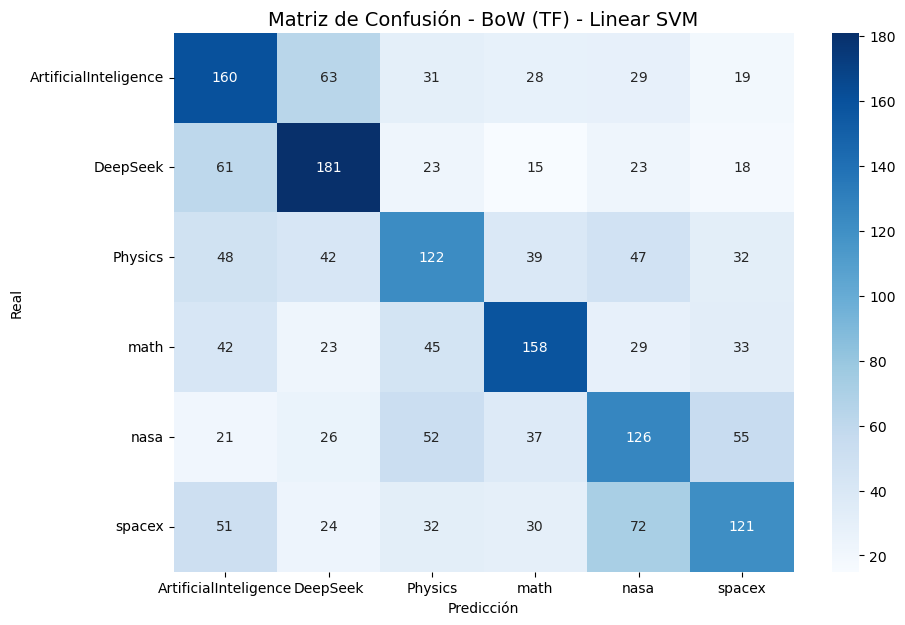


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.42      0.48      0.45       330
             DeepSeek       0.50      0.56      0.53       321
              Physics       0.40      0.37      0.38       330
                 math       0.51      0.48      0.50       330
                 nasa       0.39      0.40      0.39       317
               spacex       0.44      0.37      0.40       330

             accuracy                           0.44      1958
            macro avg       0.44      0.44      0.44      1958
         weighted avg       0.44      0.44      0.44      1958


=== Resultados para TF-IDF - Linear SVM ===
Accuracy: 0.4433



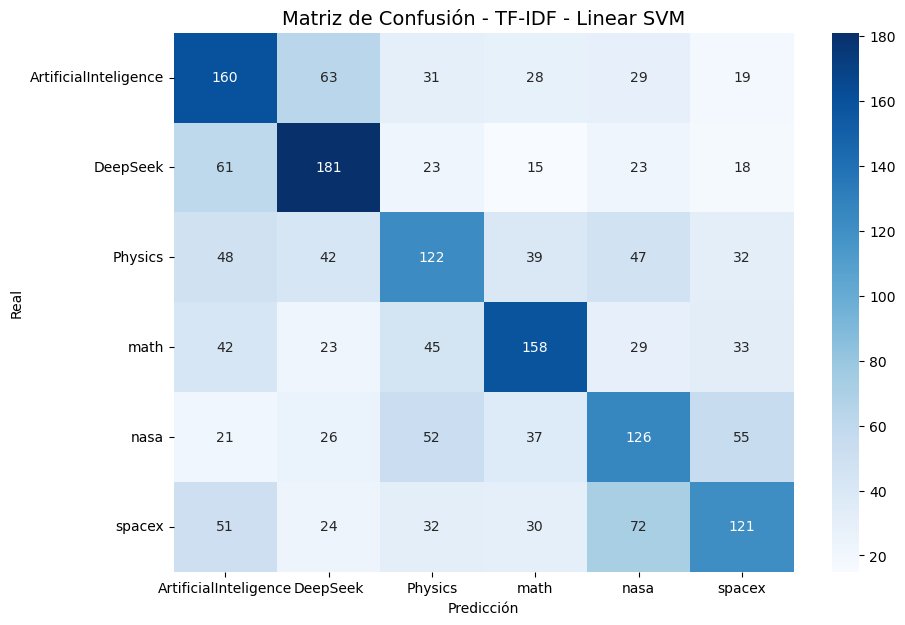


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.42      0.48      0.45       330
             DeepSeek       0.50      0.56      0.53       321
              Physics       0.40      0.37      0.38       330
                 math       0.51      0.48      0.50       330
                 nasa       0.39      0.40      0.39       317
               spacex       0.44      0.37      0.40       330

             accuracy                           0.44      1958
            macro avg       0.44      0.44      0.44      1958
         weighted avg       0.44      0.44      0.44      1958


=== Resultados para BM25 - Linear SVM ===
Accuracy: 0.4469



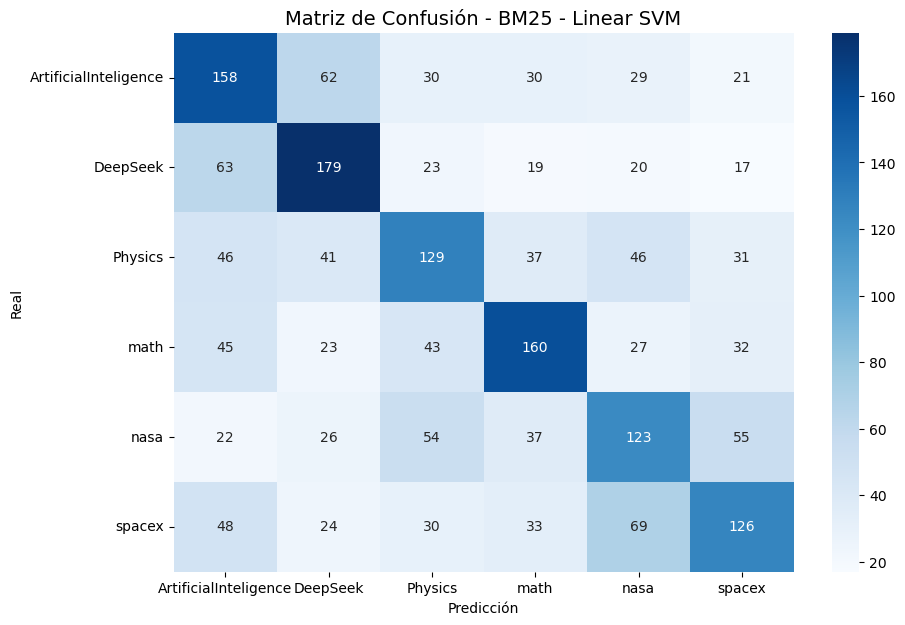


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.41      0.48      0.44       330
             DeepSeek       0.50      0.56      0.53       321
              Physics       0.42      0.39      0.40       330
                 math       0.51      0.48      0.50       330
                 nasa       0.39      0.39      0.39       317
               spacex       0.45      0.38      0.41       330

             accuracy                           0.45      1958
            macro avg       0.45      0.45      0.45      1958
         weighted avg       0.45      0.45      0.45      1958




In [ ]:


# Evaluación de modelos con matrices de confusión
evaluar_modelo("BoW (TF) - Linear SVM", clf_bow_svm, x_test, y_test)
evaluar_modelo("TF-IDF - Linear SVM", clf_tfidf_svm, x_test, y_test)
evaluar_modelo("BM25 - Linear SVM", clf_bm25_svm, x_test, y_test)


Vemos que conseguimos resultados bastante malos. La clase con peor rendimiento es 'Physics' con un f1-score de 0.38, mientras que la que mejor conseguimos clasificar es 'DeepSeek' con un 0.53.

Además vemos que hay gran confusión entre los pares de subreddits de 'nasa'/'spacex' y 'DeepSeek'/'ArtificialInteligence'. Esto tiene sentido, pues al fin y al cabo 'nasa' y 'spacex' hablan ambos sobre cohetes y el espacio, mientras que 'DeepSeek' es un LLM (que surgen del uso de IA).

Vamos a probar con el clasificador Random Forest:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from BM25 import BM25Transformer

# Calculamos la matriz de TF usando la función fit_transform

clf_bow_rf = Pipeline([
    ('vect', CountVectorizer(use_idf=False)),
    ('tf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

# Creamos el pipeline de TFIDF con  RandomForest y lo guardamos en clf_tfidf_rf
clf_tfidf_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

# Creamos el pipeline de BM25 con RandomForest y lo guardamos en clf_bm25_rf
clf_bm25_rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', BM25Transformer()),
    ('clf', RandomForestClassifier())])

# Entrenamos el modelo de BOW con el conjunto de entrenamiento con sus etiquetas
clf_bow_rf.fit(x_train, y_train)

# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf_rf.fit(x_train, y_train)

# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25_rf.fit(x_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tf', BM25Transformer()),
                ('clf', RandomForestClassifier())])

=== Resultados para BoW (TF) - Random Forest ===
Accuracy: 0.4377



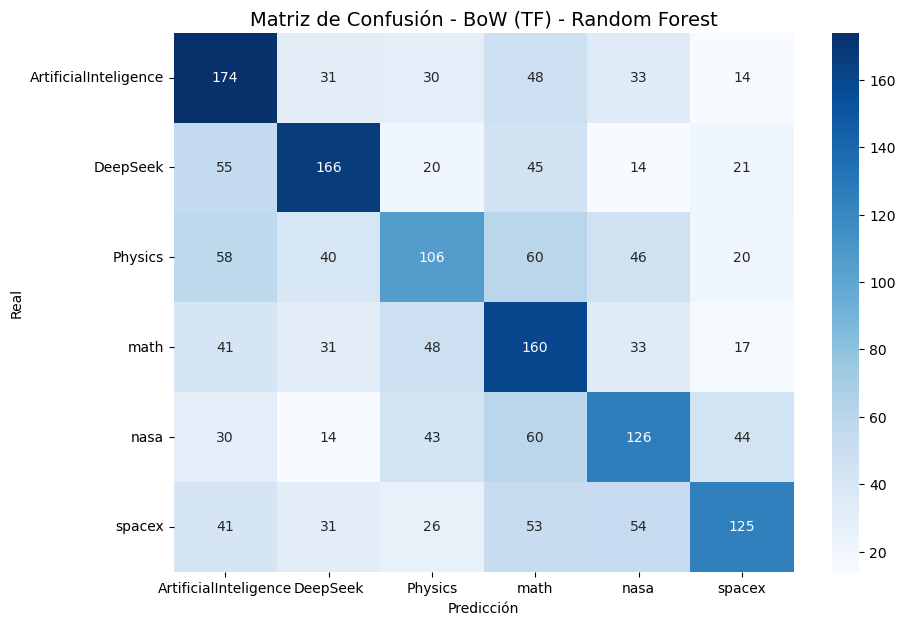


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.44      0.53      0.48       330
             DeepSeek       0.53      0.52      0.52       321
              Physics       0.39      0.32      0.35       330
                 math       0.38      0.48      0.42       330
                 nasa       0.41      0.40      0.40       317
               spacex       0.52      0.38      0.44       330

             accuracy                           0.44      1958
            macro avg       0.44      0.44      0.44      1958
         weighted avg       0.44      0.44      0.44      1958


=== Resultados para TF-IDF - Random Forest ===
Accuracy: 0.4275



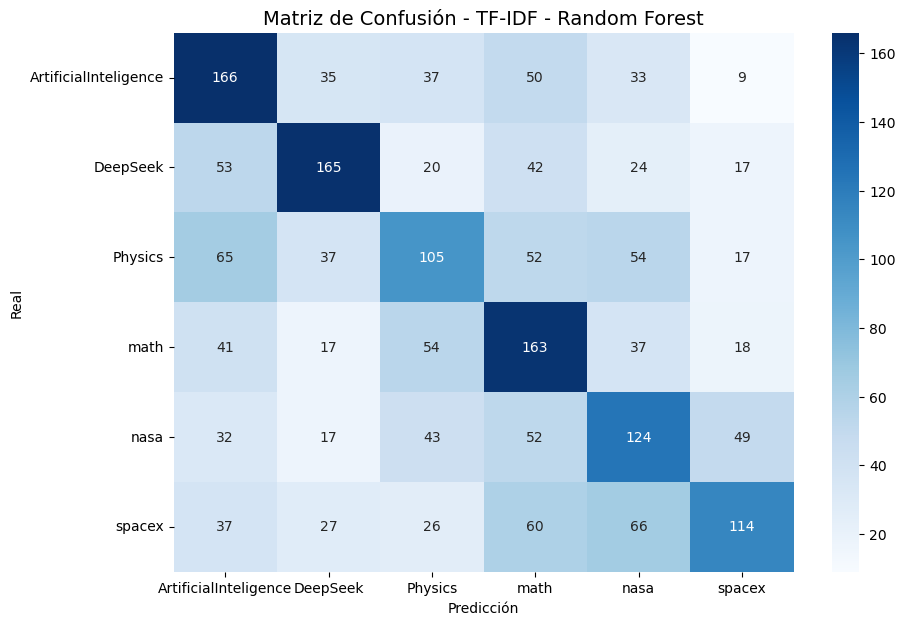


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.42      0.50      0.46       330
             DeepSeek       0.55      0.51      0.53       321
              Physics       0.37      0.32      0.34       330
                 math       0.39      0.49      0.44       330
                 nasa       0.37      0.39      0.38       317
               spacex       0.51      0.35      0.41       330

             accuracy                           0.43      1958
            macro avg       0.43      0.43      0.43      1958
         weighted avg       0.43      0.43      0.43      1958


=== Resultados para BM25 - Random Forest ===
Accuracy: 0.4285



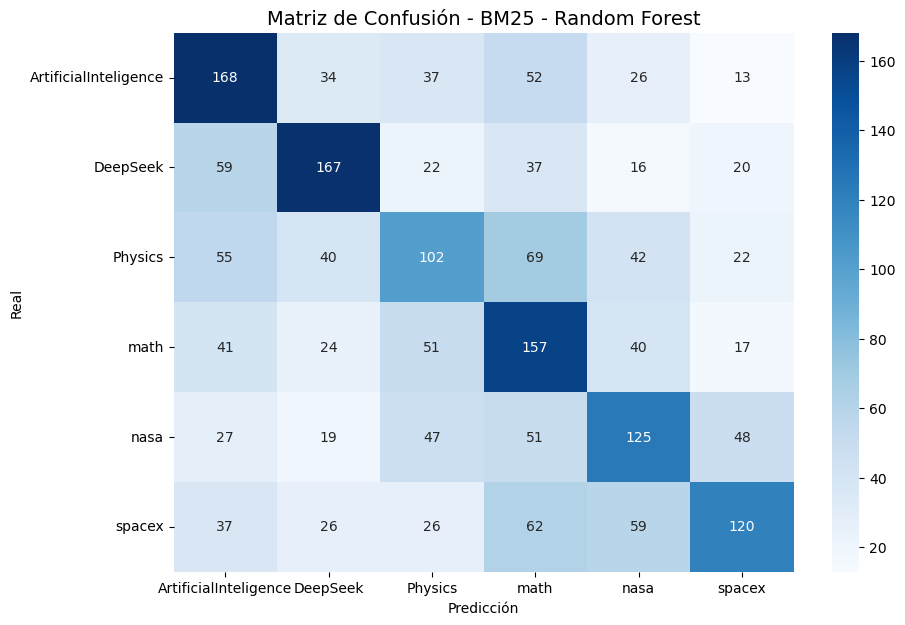


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.43      0.51      0.47       330
             DeepSeek       0.54      0.52      0.53       321
              Physics       0.36      0.31      0.33       330
                 math       0.37      0.48      0.41       330
                 nasa       0.41      0.39      0.40       317
               spacex       0.50      0.36      0.42       330

             accuracy                           0.43      1958
            macro avg       0.43      0.43      0.43      1958
         weighted avg       0.43      0.43      0.43      1958




In [ ]:

# Evaluación de modelos con matrices de confusión
evaluar_modelo("BoW (TF) - Random Forest", clf_bow_rf, x_test, y_test)
evaluar_modelo("TF-IDF - Random Forest", clf_tfidf_rf, x_test, y_test)
evaluar_modelo("BM25 - Random Forest", clf_bm25_rf, x_test, y_test)

Volvemos a obtener resultados bastante parecidos a los anteriores con el otro clasificador, vamos a pre-procesar el texto para comprobar si obtenemos mejores resultados:

Recuerdo que ya eliminamos al principio URLs e emails, por lo que no tendremos que hacerlo ahora. Vamos a eliminar las menciones, que no lo hicimos:

In [ ]:
import re
def remove_mentions(text):
    # Eliminamos menciones que comienzan con '@'
    return re.sub(r'@\w+', '', text)

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Descargar recursos de nltk si no están descargados
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Inicializamos el stemmer
stemmer = PorterStemmer()

def stemming(text):
    # Tokenizamos el texto y aplicamos stemming
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)


def remove_stopwords(text):
    # Tokenizamos el texto
    tokens = word_tokenize(text.lower())  # Convertir a minúsculas para uniformidad
    # Filtramos las stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return ' '.join(filtered_tokens)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martinsolano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/martinsolano/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinsolano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    # Aplicamos todas las funciones de limpieza
    text = remove_mentions(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text


Vamos a probar la función:

In [ ]:
texto = "@user1 This is a sample text with some stopwords and mentions. Let's clean it up!"
print(f"Texto original: {texto}")
print(f"Texto preprocesado: {preprocess_text(texto)}")

Texto original: @user1 This is a sample text with some stopwords and mentions. Let's clean it up!
Texto preprocesado: sampl text stopword mention let clean


In [ ]:
x_train_proc = [preprocess_text(text) for text in x_train]
x_test_proc = [preprocess_text(text) for text in x_test]

print("Original:")
for i in range(3):
    print(f"{i+1}: {x_train[i]}")
print("Preprocesado:")
for i in range(3):
    print(f"{i+1}: {x_train_proc[i]}")

Original:
1: They did not think this through.
2: The thing is though that anyone who needs this kind of latency would't rely on starling. And tbs that is still further then the distance of cable. Because now you are travelling up 1000 km down 1000km no matter where your trying to connect too. Now add another 1000km for distance horizontally. You're looking at 5000km instead of 2000km. Even then at 40 % it would still win. Also imagine you're trying to connect to somewhere local. Instead of going 100 to 200km you're adding 2000 to everything no matter what. You would still need to travel 2100 km to go 100 km by cable. So I think all these use cases are false, except for getting people connected in rural areas. Also if starling does become popular bandwidth issues will occur as happened with Hughesnet and wild out west.
3: You're talking about telescopes launched using rockets that cost hundreds of millions to billions of dollars a flight, and could only carry a few tons to the destinati

Parece que funciona correctamente, por lo que vamos a volver a entrenar a nuestros modelos:

In [ ]:
### Linear SVM ###

# Entrenamos el modelo de BOW con el conjunto de entrenamiento con sus etiquetas
clf_bow_svm.fit(x_train_proc, y_train)
# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf_svm.fit(x_train_proc, y_train)
# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25_svm.fit(x_train_proc, y_train)

### Random Forest ###

# Entrenamos el modelo de BOW con el conjunto de entrenamiento con sus etiquetas
clf_bow_rf.fit(x_train_proc, y_train)
# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf_rf.fit(x_train_proc, y_train)
# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25_rf.fit(x_train_proc, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tf', BM25Transformer()),
                ('clf', RandomForestClassifier())])

Mostramos los resultados:

=== Resultados para BoW (TF) - Linear SVM (texto pre-procesado) ===
Accuracy: 0.4423



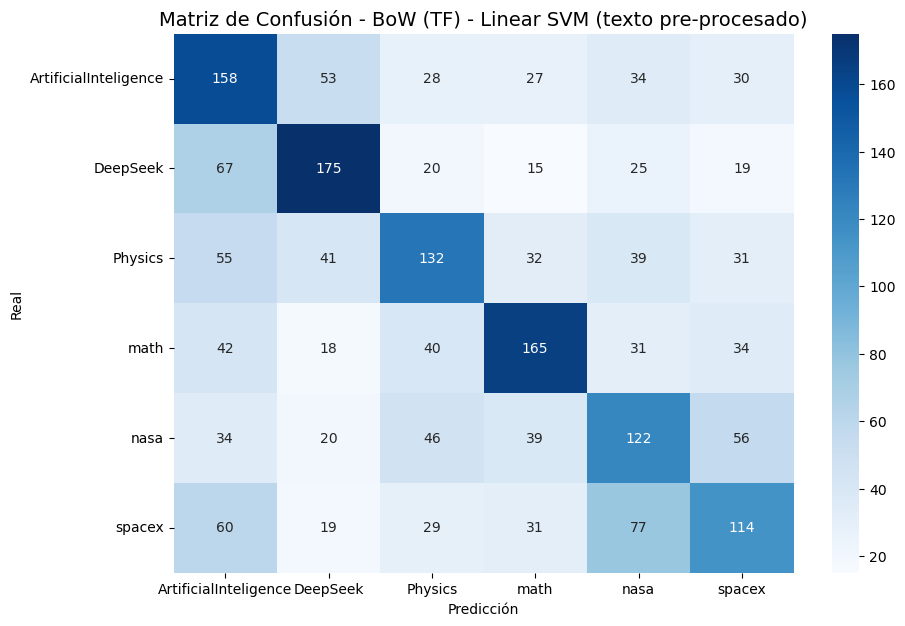


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.38      0.48      0.42       330
             DeepSeek       0.54      0.55      0.54       321
              Physics       0.45      0.40      0.42       330
                 math       0.53      0.50      0.52       330
                 nasa       0.37      0.38      0.38       317
               spacex       0.40      0.35      0.37       330

             accuracy                           0.44      1958
            macro avg       0.45      0.44      0.44      1958
         weighted avg       0.45      0.44      0.44      1958


=== Resultados para TF-IDF - Linear SVM (texto pre-procesado) ===
Accuracy: 0.4423



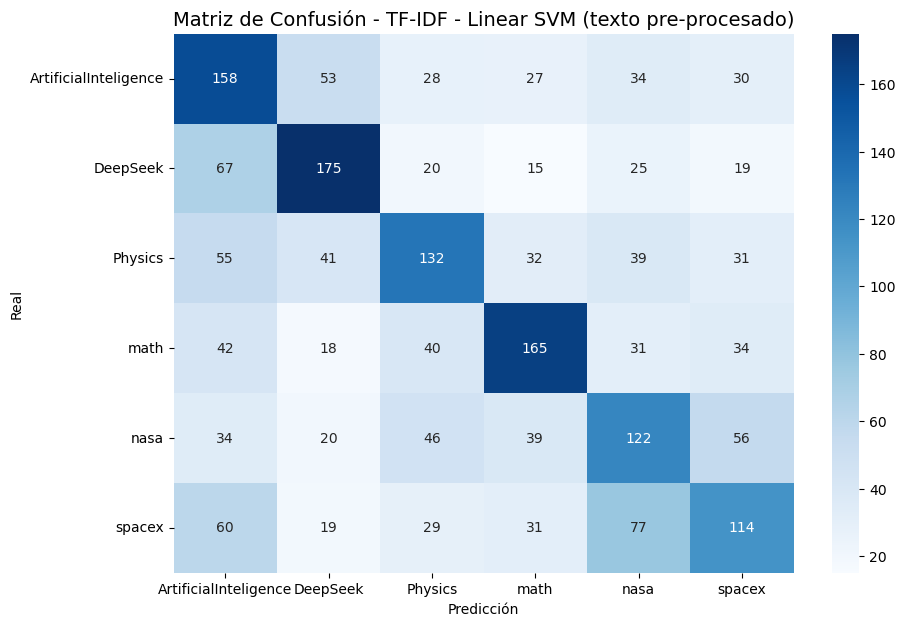


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.38      0.48      0.42       330
             DeepSeek       0.54      0.55      0.54       321
              Physics       0.45      0.40      0.42       330
                 math       0.53      0.50      0.52       330
                 nasa       0.37      0.38      0.38       317
               spacex       0.40      0.35      0.37       330

             accuracy                           0.44      1958
            macro avg       0.45      0.44      0.44      1958
         weighted avg       0.45      0.44      0.44      1958


=== Resultados para BM25 - Linear SVM (texto pre-procesado) ===
Accuracy: 0.4428



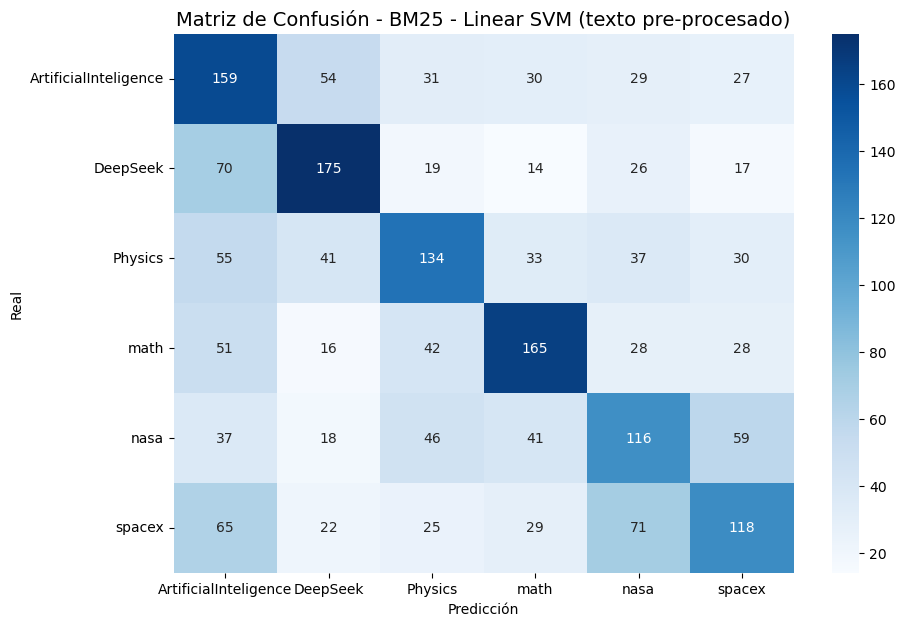


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.36      0.48      0.41       330
             DeepSeek       0.54      0.55      0.54       321
              Physics       0.45      0.41      0.43       330
                 math       0.53      0.50      0.51       330
                 nasa       0.38      0.37      0.37       317
               spacex       0.42      0.36      0.39       330

             accuracy                           0.44      1958
            macro avg       0.45      0.44      0.44      1958
         weighted avg       0.45      0.44      0.44      1958


=== Resultados para BoW (TF) - Random Forest (texto pre-procesado) ===
Accuracy: 0.4464



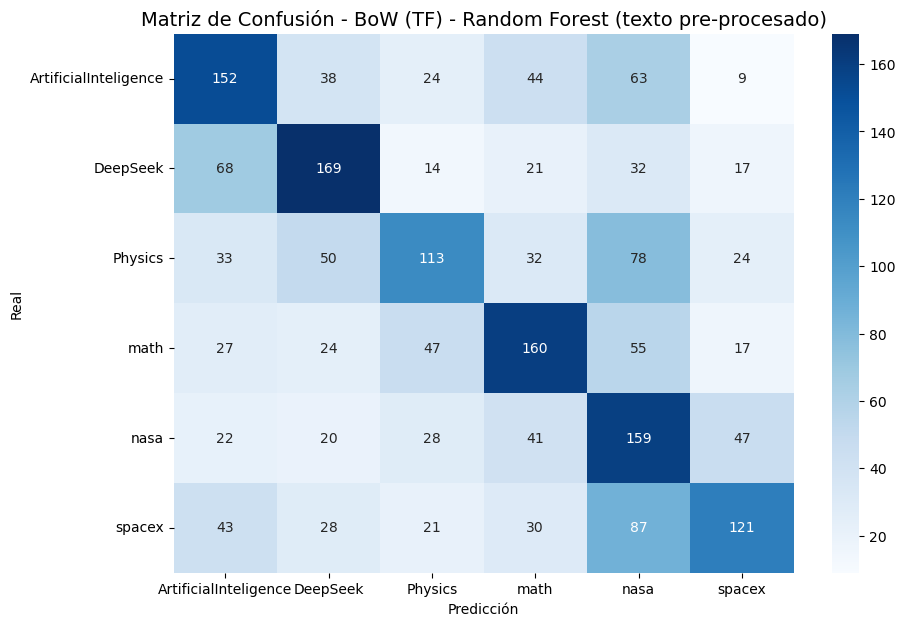


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.44      0.46      0.45       330
             DeepSeek       0.51      0.53      0.52       321
              Physics       0.46      0.34      0.39       330
                 math       0.49      0.48      0.49       330
                 nasa       0.34      0.50      0.40       317
               spacex       0.51      0.37      0.43       330

             accuracy                           0.45      1958
            macro avg       0.46      0.45      0.45      1958
         weighted avg       0.46      0.45      0.45      1958


=== Resultados para TF-IDF - Random Forest (texto pre-procesado) ===
Accuracy: 0.4505



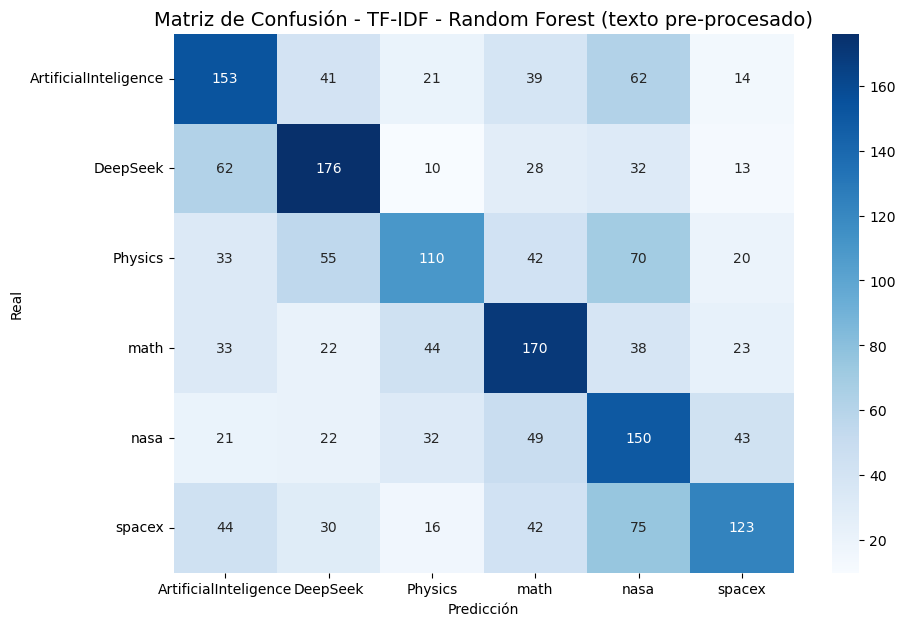


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.44      0.46      0.45       330
             DeepSeek       0.51      0.55      0.53       321
              Physics       0.47      0.33      0.39       330
                 math       0.46      0.52      0.49       330
                 nasa       0.35      0.47      0.40       317
               spacex       0.52      0.37      0.43       330

             accuracy                           0.45      1958
            macro avg       0.46      0.45      0.45      1958
         weighted avg       0.46      0.45      0.45      1958


=== Resultados para BM25 - Random Forest (texto pre-procesado) ===
Accuracy: 0.4479



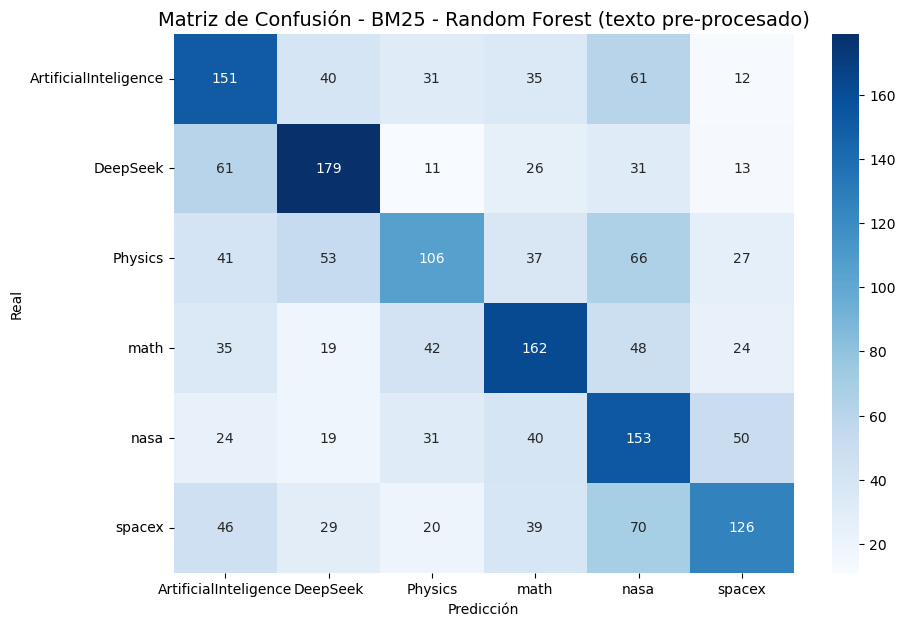


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.42      0.46      0.44       330
             DeepSeek       0.53      0.56      0.54       321
              Physics       0.44      0.32      0.37       330
                 math       0.48      0.49      0.48       330
                 nasa       0.36      0.48      0.41       317
               spacex       0.50      0.38      0.43       330

             accuracy                           0.45      1958
            macro avg       0.45      0.45      0.45      1958
         weighted avg       0.45      0.45      0.45      1958




In [ ]:
### Linear SVM ###

# Evaluación de modelos con matrices de confusión
evaluar_modelo("BoW (TF) - Linear SVM (texto pre-procesado)", clf_bow_svm, x_test_proc, y_test)
evaluar_modelo("TF-IDF - Linear SVM (texto pre-procesado)", clf_tfidf_svm, x_test_proc, y_test)
evaluar_modelo("BM25 - Linear SVM (texto pre-procesado)", clf_bm25_svm, x_test_proc, y_test)

### Random Forest###

# Evaluación de modelos con matrices de confusión
evaluar_modelo("BoW (TF) - Random Forest (texto pre-procesado)", clf_bow_rf, x_test_proc, y_test)
evaluar_modelo("TF-IDF - Random Forest (texto pre-procesado)", clf_tfidf_rf, x_test_proc, y_test)
evaluar_modelo("BM25 - Random Forest (texto pre-procesado)", clf_bm25_rf, x_test_proc, y_test)

La mejora no es extremadamente buena, porque en el Linear SVC prácticamente no conseguimos mejorar y en el Random Forest conseguimos mejorar 0.03 en accuracy.

Sin embargo ocurre algo bastante curioso en el clasificador Linear SVC, pues (a pesar de que conseguimos un accuracy bastante parecido) la clase peor clasificada teniendo en cuenta el f1-score pasa de ser 'Physics' a ser 'nasa' o 'spacex'. Parece ser que el preprocesamiento del texto hace que los términos utilizados en estos subreddits sean aún más parecidos y por lo tanto díficiles de distinguir.

Aún así es una mejora positiva, pues conseguimos el mismo rendimiento mientras reducimos drásticamente el tamaño del vocabulario, lo que hace que el entrenamiento y la inferencia sean más rápidos.

Más abajo comprobamos esto:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Definir tu pipeline
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer())
])

# Ajustar el pipeline a tus datos de texto
pipeline.fit(x_train)  # Ajusta el pipeline con los datos de entrenamiento

# Obtener el vocabulario y su tamaño
vocabulary = pipeline.named_steps['count_vectorizer'].vocabulary_
vocabulary_size = len(vocabulary)

print(f"Tamaño del vocabulario sin preprocesar: {vocabulary_size}")

# Ajustar el pipeline a tus datos de texto
pipeline.fit(x_train_proc)  # Ajusta el pipeline con los datos de entrenamiento

# Obtener el vocabulario y su tamaño
vocabulary_proc = pipeline.named_steps['count_vectorizer'].vocabulary_
vocabulary_size_proc = len(vocabulary_proc)

print(f"Tamaño del vocabulario preprocesado: {vocabulary_size_proc}")


Tamaño del vocabulario sin preprocesar: 12661
Tamaño del vocabulario preprocesado: 7848


Ahora vamos a probar a utilizar char-n-gramas que vayan de 3 a 5 caracteres y que aparezcan por lo menos en 5 documentos distintos con el texto ya pre-procesado, pues ya hemos visto que mejora los resultados y reduce el vocabulario:

In [ ]:

# Calculamos la matriz de TF usando la función fit_transform

clf_bow_svm_char = Pipeline([
    ('vect', CountVectorizer(use_idf=False, analyzer='char', ngram_range=(3,5), min_df = 5)),
    ('tf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

# Creamos el pipeline de TFIDF con  RandomForest y lo guardamos en clf_tfidf_svm_char
clf_tfidf_svm_char = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(3,5), min_df = 5)),
    ('tf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

# Creamos el pipeline de BM25 con RandomForest y lo guardamos en clf_bm25_svm_char
clf_bm25_svm_char = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(3,5), min_df = 5)),
    ('tf', BM25Transformer()),
    ('clf', RandomForestClassifier())])

# Entrenamos el modelo de BOW con el conjunto de entrenamiento con sus etiquetas
clf_bow_svm_char.fit(x_train_proc, y_train)

# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf_svm_char.fit(x_train_proc, y_train)

# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25_svm_char.fit(x_train_proc, y_train)


Pipeline(steps=[('vect',
                 CountVectorizer(analyzer='char', min_df=5,
                                 ngram_range=(3, 5))),
                ('tf', BM25Transformer()), ('clf', RandomForestClassifier())])

In [ ]:

# Calculamos la matriz de TF usando la función fit_transform

clf_bow_rf_char = Pipeline([
    ('vect', CountVectorizer(use_idf=False, analyzer='char', ngram_range=(3,5), min_df = 5)),
    ('tf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

# Creamos el pipeline de TFIDF con  RandomForest y lo guardamos en clf_tfidf_rf_char
clf_tfidf_rf_char = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(3,5), min_df = 5)),
    ('tf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

# Creamos el pipeline de BM25 con RandomForest y lo guardamos en clf_bm25_rf_char
clf_bm25_rf_char = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(3,5), min_df = 5)),
    ('tf', BM25Transformer()),
    ('clf', RandomForestClassifier())])

# Entrenamos el modelo de BOW con el conjunto de entrenamiento con sus etiquetas
clf_bow_rf_char.fit(x_train_proc, y_train)

# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf_rf_char.fit(x_train_proc, y_train)

# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25_rf_char.fit(x_train_proc, y_train)


Pipeline(steps=[('vect',
                 CountVectorizer(analyzer='char', min_df=5,
                                 ngram_range=(3, 5))),
                ('tf', BM25Transformer()), ('clf', RandomForestClassifier())])

=== Resultados para BoW (TF) - Linear SVM (texto pre-procesado y usando char-n-gramas) ===
Accuracy: 0.4556



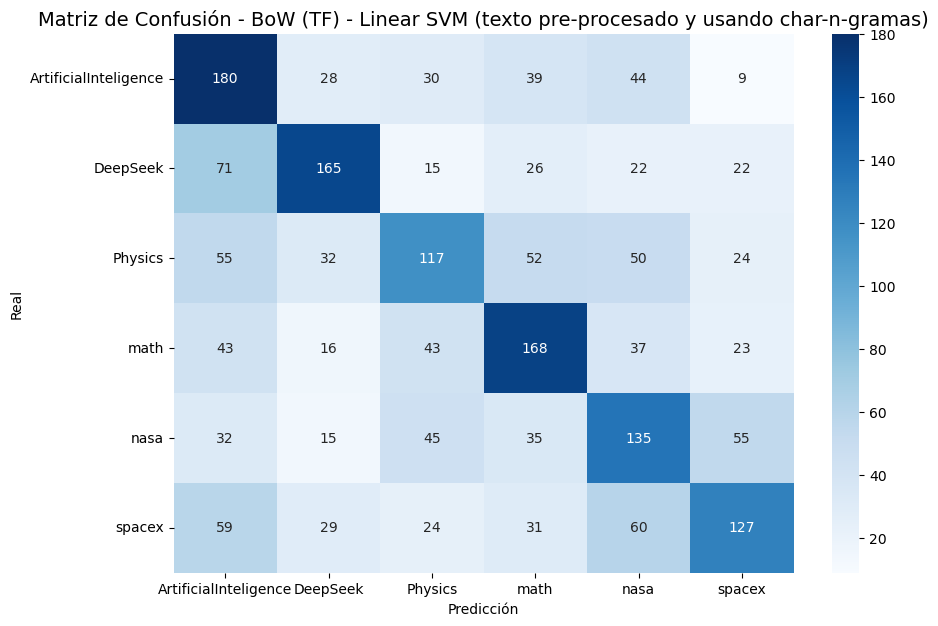


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.41      0.55      0.47       330
             DeepSeek       0.58      0.51      0.54       321
              Physics       0.43      0.35      0.39       330
                 math       0.48      0.51      0.49       330
                 nasa       0.39      0.43      0.41       317
               spacex       0.49      0.38      0.43       330

             accuracy                           0.46      1958
            macro avg       0.46      0.46      0.45      1958
         weighted avg       0.46      0.46      0.45      1958


=== Resultados para TF-IDF - Linear SVM (texto pre-procesado y usando char-n-gramas) ===
Accuracy: 0.4474



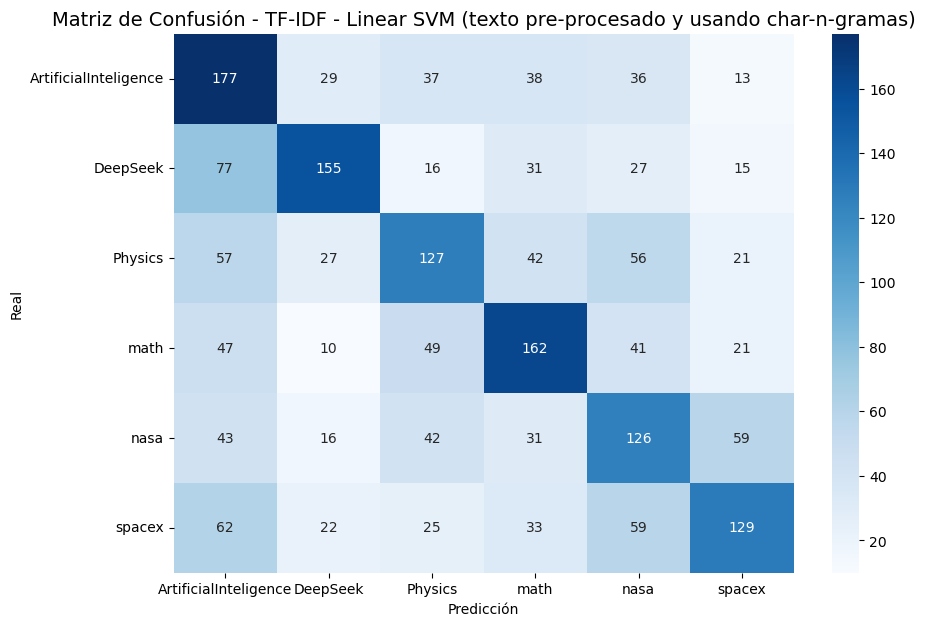


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.38      0.54      0.45       330
             DeepSeek       0.60      0.48      0.53       321
              Physics       0.43      0.38      0.41       330
                 math       0.48      0.49      0.49       330
                 nasa       0.37      0.40      0.38       317
               spacex       0.50      0.39      0.44       330

             accuracy                           0.45      1958
            macro avg       0.46      0.45      0.45      1958
         weighted avg       0.46      0.45      0.45      1958


=== Resultados para BM25 - Linear SVM (texto pre-procesado y usando char-n-gramas) ===
Accuracy: 0.4464



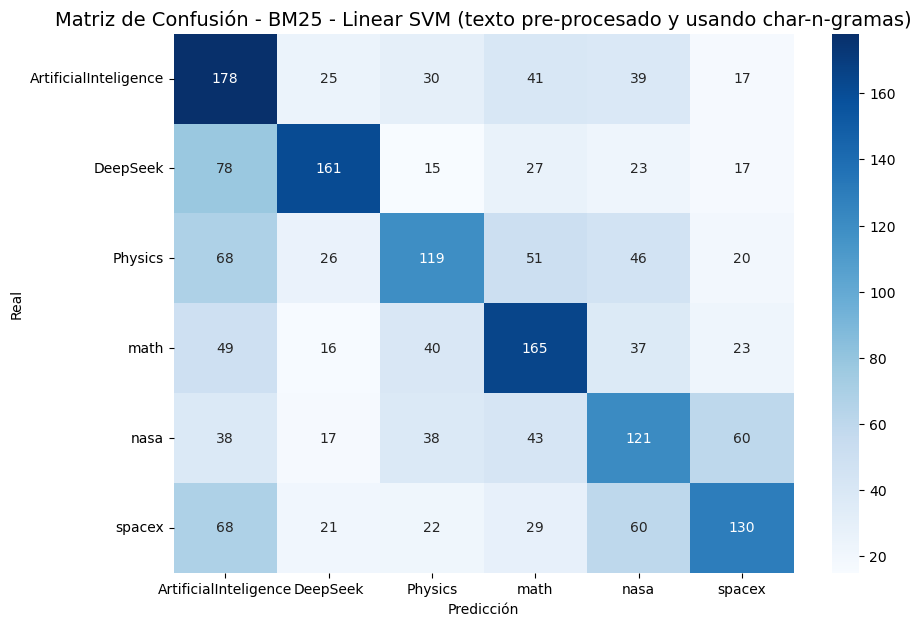


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.37      0.54      0.44       330
             DeepSeek       0.61      0.50      0.55       321
              Physics       0.45      0.36      0.40       330
                 math       0.46      0.50      0.48       330
                 nasa       0.37      0.38      0.38       317
               spacex       0.49      0.39      0.44       330

             accuracy                           0.45      1958
            macro avg       0.46      0.45      0.45      1958
         weighted avg       0.46      0.45      0.45      1958


=== Resultados para BoW (TF) - Random Forest (texto pre-procesado y usando char-n-gramas) ===
Accuracy: 0.4356



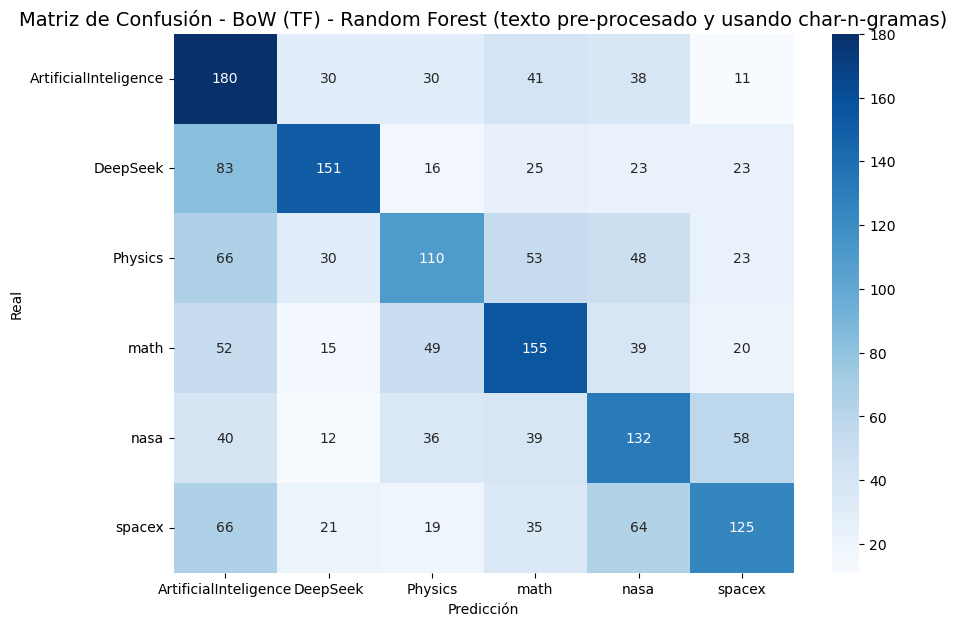


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.37      0.55      0.44       330
             DeepSeek       0.58      0.47      0.52       321
              Physics       0.42      0.33      0.37       330
                 math       0.45      0.47      0.46       330
                 nasa       0.38      0.42      0.40       317
               spacex       0.48      0.38      0.42       330

             accuracy                           0.44      1958
            macro avg       0.45      0.44      0.44      1958
         weighted avg       0.45      0.44      0.44      1958


=== Resultados para TF-IDF - Random Forest (texto pre-procesado y usando char-n-gramas) ===
Accuracy: 0.4571



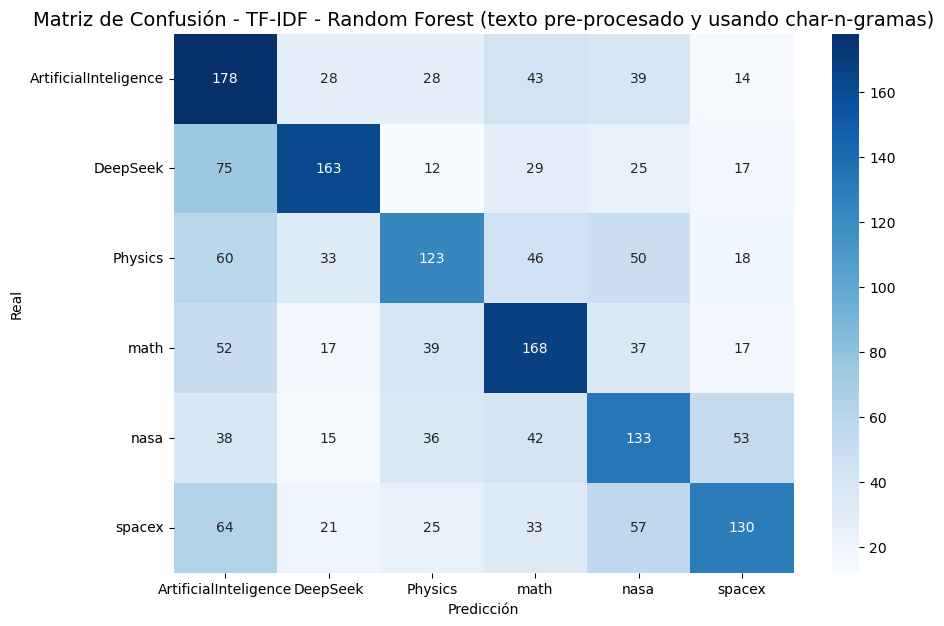


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.38      0.54      0.45       330
             DeepSeek       0.59      0.51      0.55       321
              Physics       0.47      0.37      0.41       330
                 math       0.47      0.51      0.49       330
                 nasa       0.39      0.42      0.40       317
               spacex       0.52      0.39      0.45       330

             accuracy                           0.46      1958
            macro avg       0.47      0.46      0.46      1958
         weighted avg       0.47      0.46      0.46      1958


=== Resultados para BM25 - Random Forest (texto pre-procesado y usando char-n-gramas) ===
Accuracy: 0.4637



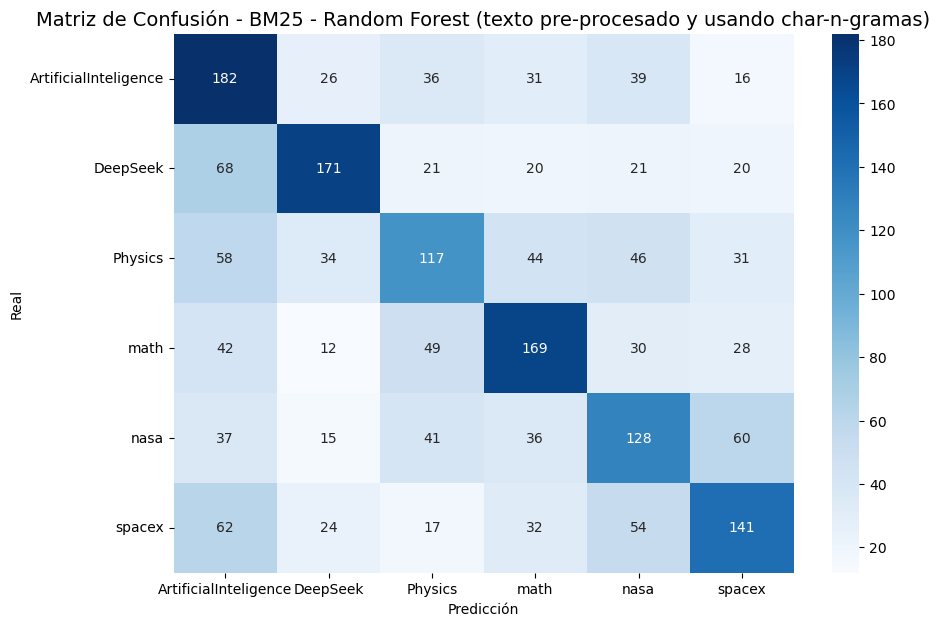


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.41      0.55      0.47       330
             DeepSeek       0.61      0.53      0.57       321
              Physics       0.42      0.35      0.38       330
                 math       0.51      0.51      0.51       330
                 nasa       0.40      0.40      0.40       317
               spacex       0.48      0.43      0.45       330

             accuracy                           0.46      1958
            macro avg       0.47      0.46      0.46      1958
         weighted avg       0.47      0.46      0.46      1958




In [ ]:
### Linear SVM ###

# Evaluación de modelos con matrices de confusión
evaluar_modelo("BoW (TF) - Linear SVM (texto pre-procesado y usando char-n-gramas)", clf_bow_svm_char, x_test_proc, y_test)
evaluar_modelo("TF-IDF - Linear SVM (texto pre-procesado y usando char-n-gramas)", clf_tfidf_svm_char, x_test_proc, y_test)
evaluar_modelo("BM25 - Linear SVM (texto pre-procesado y usando char-n-gramas)", clf_bm25_svm_char, x_test_proc, y_test)

### Random Forest###

# Evaluación de modelos con matrices de confusión
evaluar_modelo("BoW (TF) - Random Forest (texto pre-procesado y usando char-n-gramas)", clf_bow_rf_char, x_test_proc, y_test)
evaluar_modelo("TF-IDF - Random Forest (texto pre-procesado y usando char-n-gramas)", clf_tfidf_rf_char, x_test_proc, y_test)
evaluar_modelo("BM25 - Random Forest (texto pre-procesado y usando char-n-gramas)", clf_bm25_rf_char, x_test_proc, y_test)

Conseguimos mejorar un poco más, y hemos logrado nuestro mejor modelo hasta ahora "BM25 - Random Forest (texto pre-procesado y usando char-n-gramas)" con un accuracy de 0.4637. Esto representa una mejora sustancial sobre el baseline aleatorio (0.1667), aún así sigue siendo muy bajo, por lo que vamos a pasar al segundo sistema.

En este ejemplo en concreto, la clase que mejor clasifica es la de 'Deepseek', con un F1-score de 0.57, muy por encima del resto.

También me gustaría resaltar que en todos los modelos que hemos visto la clase que más confusión genera es 'ArtificialInteligence' pues la mayoría de los errores están en la fila y columna indexada por esta categoría (colores más oscuros en la fila 1 y en la columna 1). Esto se ve sobre todo a la hora de que el modelo haga las predicciones, pues la columna 1 es con diferencia la que más errores tiene.

### Sistema 2: Word-embeddings de Glove y FastText

Ahora pasamos al sistema en el que utilizaremos word-embeddings, para esto primero vamos a descargar y cargar todo lo necesario:

In [ ]:
# Descargamos los vectores GloVe de Stanford (dimensiones: 50, 100, 200, 300)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-04-12 22:08:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-12 22:08:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-12 22:08:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Instalamos gensim si no lo tenemos instalado
!pip3 install -U gensim

  Using cached gensim-4.3.3-cp39-cp39-macosx_10_9_x86_64.whl.metadata (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 607.4 kB/s eta 0:00:0000:0100:02


In [ ]:
from gensim.models.keyedvectors import KeyedVectors
import gensim

# Cargamos el modelo de Glove en Gensim
glove_gensim_model = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False, no_header=True)


Como lo que queremos es que para cada comentario tengamos un embedding, vamos a cargar la clase 'GensimSentenceEmbeddingTransformer' que obtiene embeddings de oraciones:

In [ ]:

from sklearn.base import BaseEstimator, TransformerMixin

nltk.download('stopwords')
nltk.download('punkt')

# Definir el transformador para generar embeddings de oraciones
class GensimSentenceEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model, idiomaStopWords='spanish'):
        self.model = model

    def fit(self, X, y=None):
        return self  # No necesitamos hacer nada en fit

    def transform(self, X):
        embeddings = []
        for texto in X:
            embedding = self.gensim_sentence_embeddings(texto)
            embeddings.append(embedding)
        return np.array(embeddings)

    def gensim_sentence_embeddings(self, texto):
        num_dimensiones = self.model.vector_size
        line_vec = []
        tokenized_text = word_tokenize(texto)
        count = 0
        for token in tokenized_text:
            if self.model.has_index_for(token):
                a = self.model.get_vector(token)
                if len(line_vec) == 0:
                    line_vec = a
                else:
                    line_vec = line_vec + a
                count += 1
        if count > 0:
            return line_vec / count
        else:
            return np.zeros(num_dimensiones)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinsolano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martinsolano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Al igual que con el sistema anterior creamos los pipeline con los clasificadores correspondientes:

In [ ]:

# Crear el pipeline
clf_glove_svm = Pipeline([
    ('embedding', GensimSentenceEmbeddingTransformer(model=glove_gensim_model)),
    ('clf', LinearSVC(random_state=0, tol=1e-5))
])

clf_glove_rf = Pipeline([
    ('embedding', GensimSentenceEmbeddingTransformer(model=glove_gensim_model)),
    ('clf', RandomForestClassifier())
])

# Entrenamos el modelo
clf_glove_svm.fit(x_train, y_train)
clf_glove_rf.fit(x_train, y_train)

Pipeline(steps=[('embedding',
                 GensimSentenceEmbeddingTransformer(model=<gensim.models.keyedvectors.KeyedVectors object at 0x145844070>)),
                ('clf', RandomForestClassifier())])

Y evaluamos nuestros modelos:

=== Resultados para Glove - Linear SVM ===
Accuracy: 0.4127



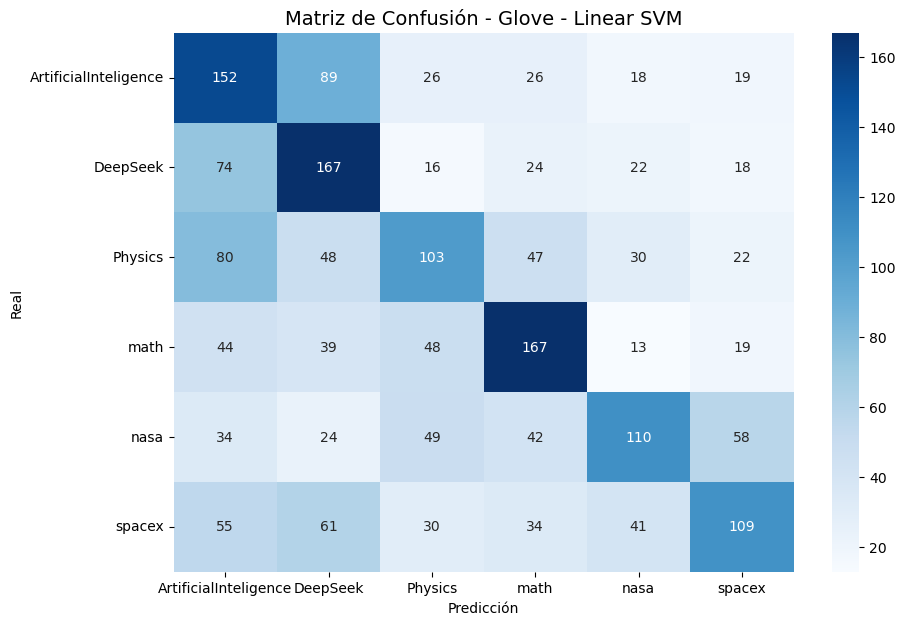


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.35      0.46      0.40       330
             DeepSeek       0.39      0.52      0.45       321
              Physics       0.38      0.31      0.34       330
                 math       0.49      0.51      0.50       330
                 nasa       0.47      0.35      0.40       317
               spacex       0.44      0.33      0.38       330

             accuracy                           0.41      1958
            macro avg       0.42      0.41      0.41      1958
         weighted avg       0.42      0.41      0.41      1958


=== Resultados para Glove - Random Forest ===
Accuracy: 0.3417



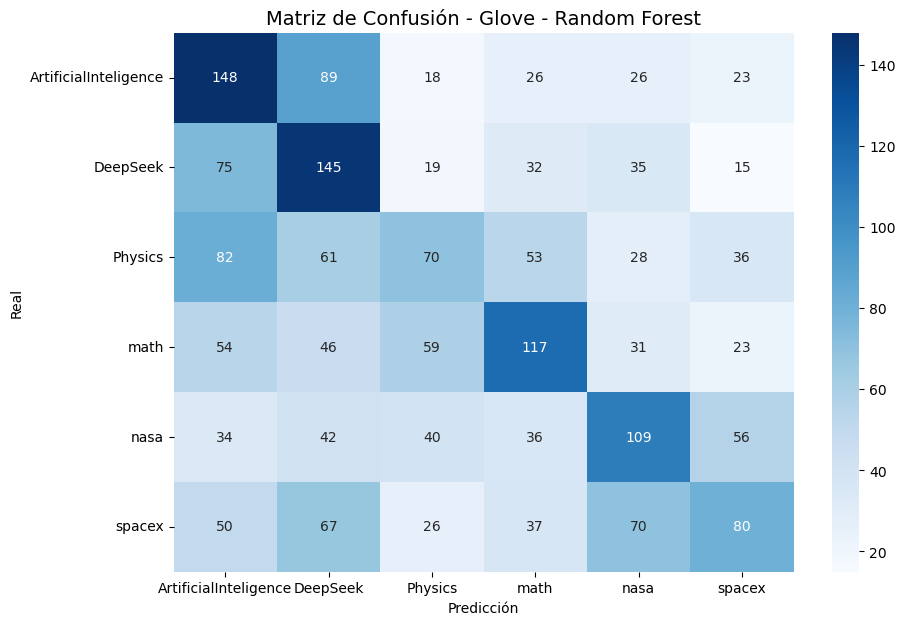


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.33      0.45      0.38       330
             DeepSeek       0.32      0.45      0.38       321
              Physics       0.30      0.21      0.25       330
                 math       0.39      0.35      0.37       330
                 nasa       0.36      0.34      0.35       317
               spacex       0.34      0.24      0.28       330

             accuracy                           0.34      1958
            macro avg       0.34      0.34      0.34      1958
         weighted avg       0.34      0.34      0.34      1958




In [ ]:

# Evaluación de modelos con matrices de confusión
evaluar_modelo("Glove - Linear SVM", clf_glove_svm, x_test, y_test)
evaluar_modelo("Glove - Random Forest", clf_glove_rf, x_test, y_test)

Los métodos basados en el sistema 1 (BoW, TF-IDF, BM25) han superado a GloVe para clasificar subreddits. Esto indica que la jerga y patrones de caracteres son clave, más que la semántica general.

Además, notamos que con sentece-embeddings, Linear SVM ha funcionado mucho mejor que Random Forest (accuracy de 0.4127 frente a 0.3417). Esto se debe a que el espacio para esta tarea podría ser más linealmente separable, dando a SVM una ventaja, pues es más eficaz encontrando límites lineales oblicuos que RF con sus divisiones alineadas a los ejes en espacios densos. Es decir, SVM es más flexible a la hora de hacer establecer límites lineales.

Tiene sentido que en el caso del sistema 1 RF funcionara correctamente, pues nuestros ejes eran mucho más concretos (palabras), en el caso de los embeddings cada componente del vector ya no es un token, sino algo mucho más abstracto.

Observamos además que orden de las clases mejor clasificadas vuelve a cambiar, favoreciendo a aquellas que son más semánticamente diferentes.

Vamos a entrenarlo con el conjunto de datos preprocesado a ver si conseguimos mejorar:

=== Resultados para Glove - Linear SVM (texto pre-procesado) ===
Accuracy: 0.4162



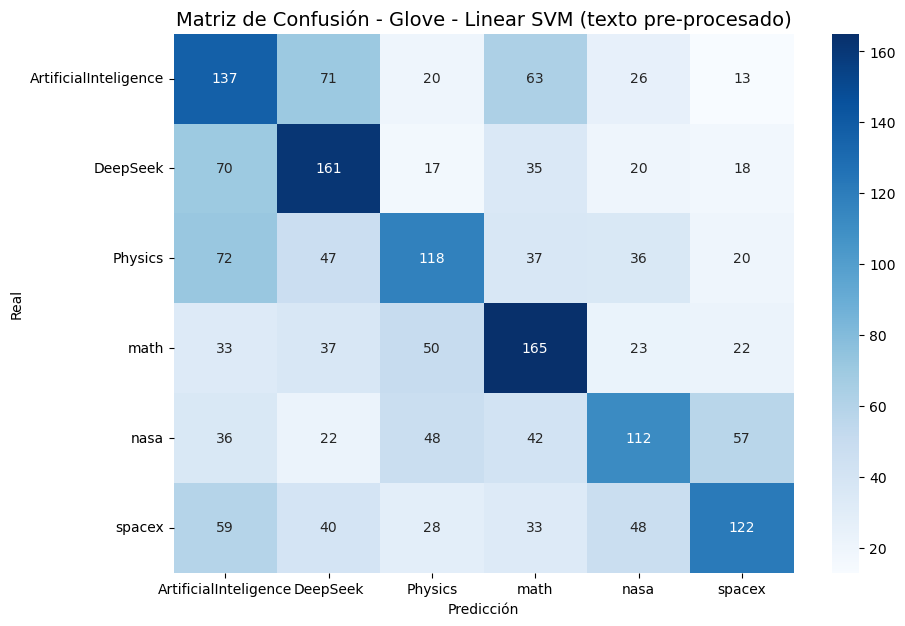


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.34      0.42      0.37       330
             DeepSeek       0.43      0.50      0.46       321
              Physics       0.42      0.36      0.39       330
                 math       0.44      0.50      0.47       330
                 nasa       0.42      0.35      0.38       317
               spacex       0.48      0.37      0.42       330

             accuracy                           0.42      1958
            macro avg       0.42      0.42      0.42      1958
         weighted avg       0.42      0.42      0.42      1958


=== Resultados para Glove - Random Forest (texto pre-procesado) ===
Accuracy: 0.3902



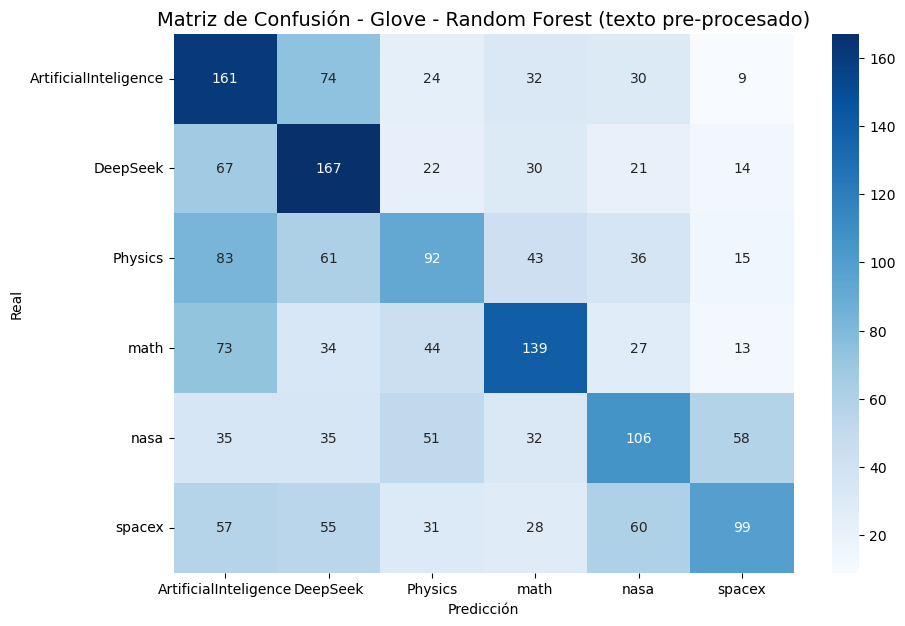


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.34      0.49      0.40       330
             DeepSeek       0.39      0.52      0.45       321
              Physics       0.35      0.28      0.31       330
                 math       0.46      0.42      0.44       330
                 nasa       0.38      0.33      0.36       317
               spacex       0.48      0.30      0.37       330

             accuracy                           0.39      1958
            macro avg       0.40      0.39      0.39      1958
         weighted avg       0.40      0.39      0.39      1958




In [ ]:
# Entrenamos el modelo
clf_glove_svm.fit(x_train_proc, y_train)
clf_glove_rf.fit(x_train_proc, y_train)

# Evaluación de modelos con matrices de confusión
evaluar_modelo("Glove - Linear SVM (texto pre-procesado)", clf_glove_svm, x_test_proc, y_test)
evaluar_modelo("Glove - Random Forest (texto pre-procesado)", clf_glove_rf, x_test_proc, y_test)

Vemos que la mejora no es muy significativa para SVM, pero RF sí que ha conseguido una mejora de 0.05. Esto puede deberse que al reducir nuestro vocabulario nuestros embeddings son mucho menos compactos (menos abstractos) teniendo así un significado más cercano al de los tokens, acercándonos al caso del sistema 1.

Ahora vamos a probar con char-n-gramas, esto lo haremos implícitamente usando FastText, que descompone las palabras en sus n-gramas de caracteres y los combina. Para ello empezaremos descargando el modelo:

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2025-04-13 12:22:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.41.96, 18.154.41.12, 18.154.41.8, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.41.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1,2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1,23G  2,45MB/s    in 9m 12s  

2025-04-13 12:31:26 (2,29 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
!pip install fasttext

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp39-cp39-macosx_10_16_x86_64.whl size=313110 sha256=9f3a0bcfddf53deb8c323852965eb5af4c0a9f8f63ae08c6e800b778afb591d6
  Stored in directory: /Users/martinsolano/Library/Caches/pip/wheels/e1/b9/f8/9caac00aff8e25c0d13fa29fd7f05618b3a9f6bb2f60278023
Successfully built fasttext


In [ ]:
from gensim.models import KeyedVectors
fasttext_model = KeyedVectors.load_word2vec_format('cc.en.300.vec', encoding='utf-8')

Precedemos como con el resto de modelos:

In [ ]:
clf_ftxt_svm = Pipeline([
    ('embedding', GensimSentenceEmbeddingTransformer(model=fasttext_model)),
    ('clf', LinearSVC(random_state=0, tol=1e-5))
])

clf_ftxt_rf = Pipeline([
    ('embedding', GensimSentenceEmbeddingTransformer(model=fasttext_model)),
    ('clf', RandomForestClassifier())
])

clf_ftxt_svm.fit(x_train, y_train)
clf_ftxt_rf.fit(x_train, y_train)


Pipeline(steps=[('embedding',
                 GensimSentenceEmbeddingTransformer(model=<gensim.models.keyedvectors.KeyedVectors object at 0x13ebd8730>)),
                ('clf', RandomForestClassifier())])

=== Resultados para FastText - Linear SVM ===
Accuracy: 0.4464



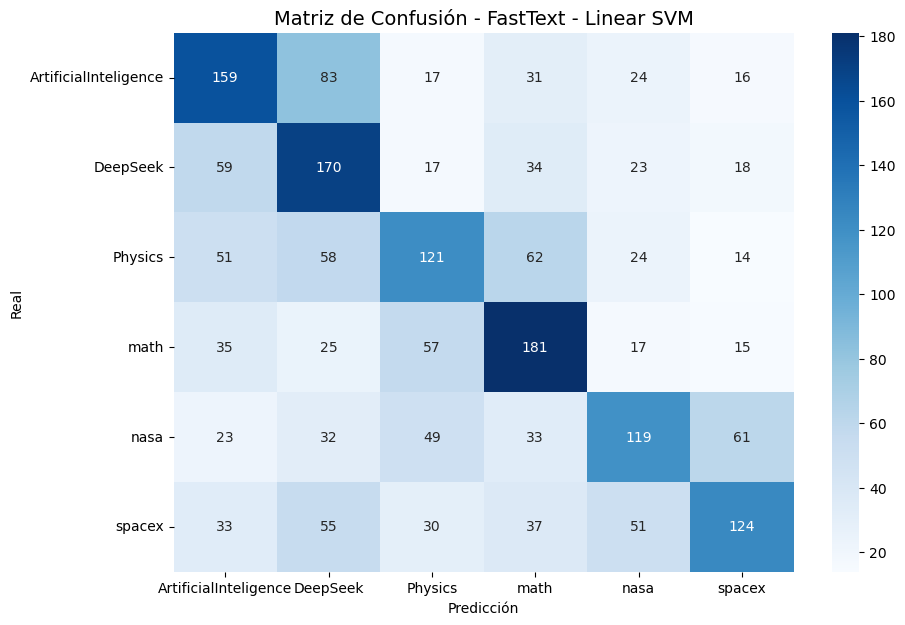


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.44      0.48      0.46       330
             DeepSeek       0.40      0.53      0.46       321
              Physics       0.42      0.37      0.39       330
                 math       0.48      0.55      0.51       330
                 nasa       0.46      0.38      0.41       317
               spacex       0.50      0.38      0.43       330

             accuracy                           0.45      1958
            macro avg       0.45      0.45      0.44      1958
         weighted avg       0.45      0.45      0.44      1958


=== Resultados para FastText - Random Forest ===
Accuracy: 0.3417



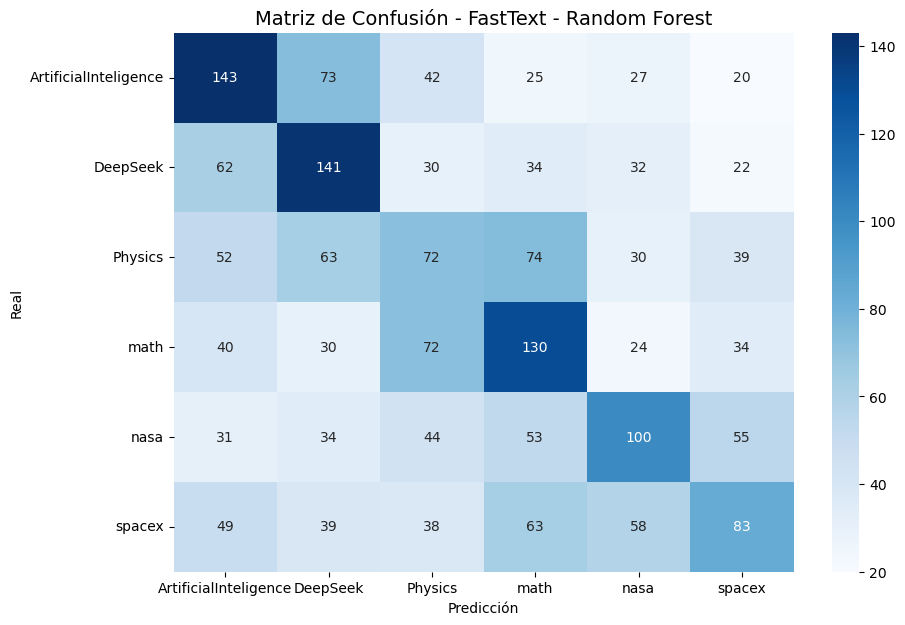


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.38      0.43      0.40       330
             DeepSeek       0.37      0.44      0.40       321
              Physics       0.24      0.22      0.23       330
                 math       0.34      0.39      0.37       330
                 nasa       0.37      0.32      0.34       317
               spacex       0.33      0.25      0.28       330

             accuracy                           0.34      1958
            macro avg       0.34      0.34      0.34      1958
         weighted avg       0.34      0.34      0.34      1958




In [ ]:
# Evaluación de modelos con matrices de confusión
evaluar_modelo("FastText - Linear SVM", clf_ftxt_svm, x_test, y_test)
evaluar_modelo("FastText - Random Forest", clf_ftxt_rf, x_test, y_test)

Obtenemos resultados mejores con SVM, aunque con RF seguimos teniendo el problema que hemos mencionado anteriormente.

FastText, al incluir información de subpalabras, crea embeddings más robustos que GloVe para la jerga específica de los subreddits. Este espacio de FastText parece más linealmente separable, permitiendo que SVM encuentre un límite óptimo para una mejor clasificación.

Vamos a ver si con el texto preprocesado se consigue un rendimiento aún mejor:

=== Resultados para FastText - Linear SVM (texto pre-procesado) ===
Accuracy: 0.4489



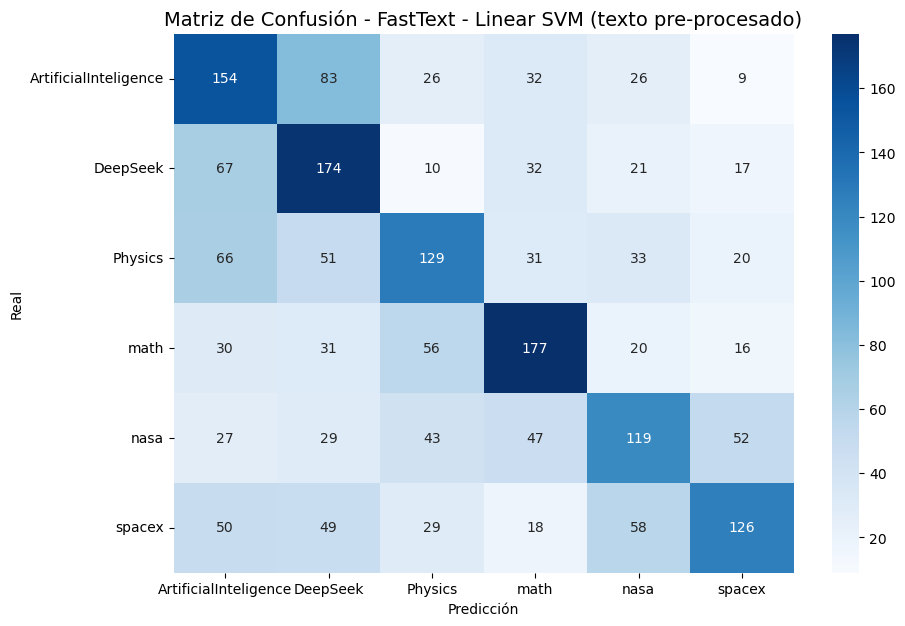


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.39      0.47      0.43       330
             DeepSeek       0.42      0.54      0.47       321
              Physics       0.44      0.39      0.41       330
                 math       0.53      0.54      0.53       330
                 nasa       0.43      0.38      0.40       317
               spacex       0.53      0.38      0.44       330

             accuracy                           0.45      1958
            macro avg       0.45      0.45      0.45      1958
         weighted avg       0.46      0.45      0.45      1958


=== Resultados para FastText - Random Forest (texto pre-procesado) ===
Accuracy: 0.3601



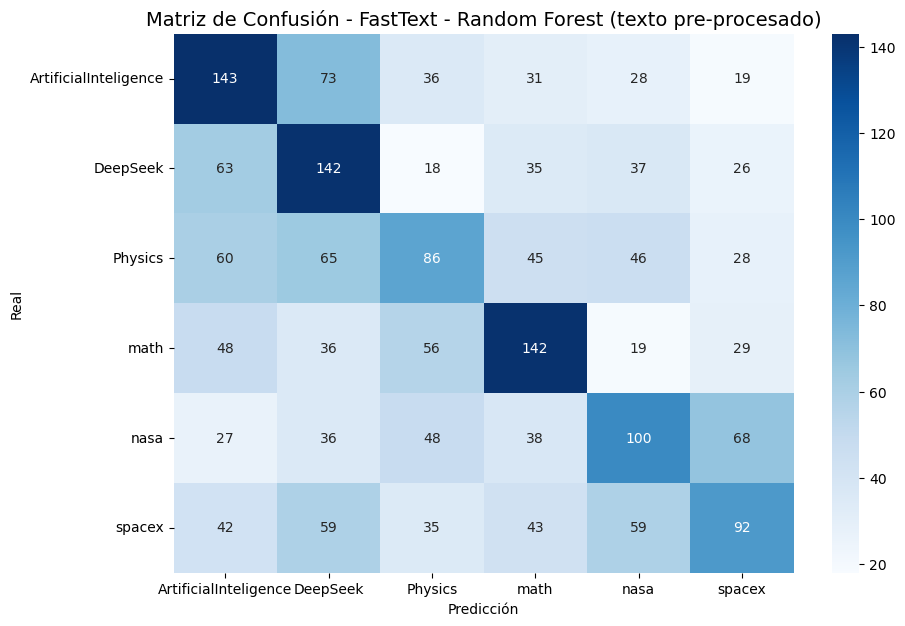


Informe de clasificación:
                       precision    recall  f1-score   support

ArtificialInteligence       0.37      0.43      0.40       330
             DeepSeek       0.35      0.44      0.39       321
              Physics       0.31      0.26      0.28       330
                 math       0.43      0.43      0.43       330
                 nasa       0.35      0.32      0.33       317
               spacex       0.35      0.28      0.31       330

             accuracy                           0.36      1958
            macro avg       0.36      0.36      0.36      1958
         weighted avg       0.36      0.36      0.36      1958




In [ ]:
clf_ftxt_svm.fit(x_train_proc, y_train)
clf_ftxt_rf.fit(x_train_proc, y_train)

# Evaluación de modelos con matrices de confusión
evaluar_modelo("FastText - Linear SVM (texto pre-procesado)", clf_ftxt_svm, x_test_proc, y_test)
evaluar_modelo("FastText - Random Forest (texto pre-procesado)", clf_ftxt_rf, x_test_proc, y_test)

Se consigue una muy sutil mejora en RF por la razón ya explicada con el caso de Glove.

Hemos finalizado el sistema 2 y, observamos que no conseguimos mejorar los resultados del sistema 1. Esto indica que, aunque los word embeddings como FastText capturan relaciones semánticas más profundas, no siempre mejoran la clasificación pues la jerga de cada subreddit puede tener gran importancia. Además, promediar embeddings puede perder contexto relevante. Aun así, el sistema 2 ha sido útil para explorar enfoques más avanzados y comprender sus límites en tareas reales.

### Sistema 3: Fine-tuning de modelos preentrenados

Primero de todo vamos a crear una función que tome nuestros datos y que los convierta al formato necesario para poder hacer fine-tuning al modelo pre-entrenado:

In [ ]:
!pip install -U datasets
!pip install -U transformers
!pip install -U evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# 1. Crear los mapeos de etiquetas
def create_label_mappings(y_train):
    labels = sorted(set(y_train))
    label2id = {label: idx for idx, label in enumerate(labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    return label2id, id2label

# 2. Crear DatasetDict desde listas de texto y etiquetas
def create_datasets(x_train, y_train, x_val, y_val, label2id):
    train_data = {
        "text": x_train,
        "label": [label2id[label] for label in y_train],
    }
    val_data = {
        "text": x_val,
        "label": [label2id[label] for label in y_val],
    }

    dataset_dict = DatasetDict({
        "train": Dataset.from_dict(train_data),
        "validation": Dataset.from_dict(val_data),
    })

    return dataset_dict

# 3. Tokenizar datasets
def tokenize_dataset(dataset_dict, tokenizer_name, max_length=512):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    def tokenize_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=max_length)

    return dataset_dict.map(tokenize_function, batched=True)

# 4. Función principal para cargar y preparar
def load_and_prepare_datasets(x_train, y_train, x_val, y_val, tokenizer_name="bert-base-uncased"):
    label2id, id2label = create_label_mappings(y_train)
    datasets = create_datasets(x_train, y_train, x_val, y_val, label2id)
    tokenized_datasets = tokenize_dataset(datasets, tokenizer_name)
    return tokenized_datasets, label2id, id2label

Cargamos los datos y comprobamos que todo funcione correctamente:

In [ ]:

# Dividimos el x_train en 80% train, 20% validación
x_train_ft, x_val_ft, y_train_ft, y_val_ft = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

tokenized_datasets, label2id, id2label = load_and_prepare_datasets(x_train_ft, y_train_ft, x_val_ft, y_val_ft)


Map:   0%|          | 0/3657 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 915/915 [00:00<00:00, 2973.28 examples/s]


In [ ]:
print("Labels:", label2id)
print("Ejemplo tokenizado:")
print(f"Texto: {tokenized_datasets['train'][5]['text']}")
print(f"Etiqueta: {tokenized_datasets['train'][5]['label']}")
print(f"Tokens: {tokenized_datasets['train'][5]['input_ids']}")
print(f"Longitud del vector: {len(tokenized_datasets['train'][5]['input_ids'])}")

Labels: {'ArtificialInteligence': 0, 'DeepSeek': 1, 'Physics': 2, 'math': 3, 'nasa': 4, 'spacex': 5}
Ejemplo tokenizado:
Texto: > momentum I never knew there was a silent p.
Etiqueta: 3
Tokens: [101, 1028, 11071, 1045, 2196, 2354, 2045, 2001, 1037, 4333, 1052, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Parece que todo funciona correctamente, por lo que vamos a pasar a entrenar con ajuste fino nuestro modelo pre-entrenado:

In [ ]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report
from evaluate import load
import numpy as np
import torch
import random
import json

# Fijamos la semilla para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# 5. Cargar el modelo y el tokenizador
def load_model_and_tokenizer(model_name, num_labels, id2label, label2id):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    return tokenizer, model

model_name = "bert-base-uncased"
tokenizer, bert_class_model_pytorch = load_model_and_tokenizer(model_name, len(label2id), id2label, label2id)

# 6. Configuración del DataCollator

# Se encarga de partir el texto en lotes (batches) y añadir el padding necesario
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 7. Configuración de los argumentos de entrenamiento
batch_train_size = 16
batch_val_size = 64
metric_name = "eval_f1"

training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_train_size,
    per_device_eval_batch_size=batch_val_size,
    metric_for_best_model=metric_name,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="none"
)

# 8. Definición de la función de evaluación
def compute_metrics(eval_pred):
    from evaluate import load
    import numpy as np
    from sklearn.metrics import classification_report

    metric = load("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    print(classification_report(labels, predictions, digits=6))

    # Usamos una media 'weighted' para las métricas multiclase
    return metric.compute(predictions=predictions, references=labels, average="weighted")


# 9. Entrenamiento del modelo
trainer = Trainer(
    model=bert_class_model_pytorch,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-bf653c5dab94>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Todas las funciones ya están listas para ser ejecutadas:

In [ ]:
# Entrenamos el modelo
trainer.train()

              precision    recall  f1-score   support

           0   0.554795  0.663934  0.604478       122
           1   0.679104  0.728000  0.702703       125
           2   0.589744  0.589744  0.589744       117
           3   0.784810  0.521008  0.626263       119
           4   0.373016  0.388430  0.380567       121
           5   0.584615  0.593750  0.589147       128

    accuracy                       0.581967       732
   macro avg   0.594347  0.580811  0.582150       732
weighted avg   0.594168  0.581967  0.582744       732

              precision    recall  f1-score   support

           0   0.582677  0.606557  0.594378       122
           1   0.747826  0.688000  0.716667       125
           2   0.483146  0.735043  0.583051       117
           3   0.736264  0.563025  0.638095       119
           4   0.536842  0.421488  0.472222       121
           5   0.587302  0.578125  0.582677       128

    accuracy                       0.598361       732
   macro avg   0.612343

TrainOutput(global_step=549, training_loss=0.8696315466597649, metrics={'train_runtime': 957.5721, 'train_samples_per_second': 9.164, 'train_steps_per_second': 0.573, 'total_flos': 2308882429900800.0, 'train_loss': 0.8696315466597649, 'epoch': 3.0})

Ahora vamos a testear nuestro modelo:

In [ ]:
# Usamos el test real, que no se tocó durante entrenamiento
test_data = {
    "text": x_test,   # Esto es el verdadero test que no se usó en train/val
    "label": [label2id[label] for label in y_test],
}
test_dataset = Dataset.from_dict(test_data)
tokenized_test_dataset = tokenize_dataset(DatasetDict({"test": test_dataset}), model_name)["test"]


# Predecimos sobre test
print("PREDICCIONES SOBRE TEST")
predictions = trainer.predict(tokenized_test_dataset)
print(json.dumps(predictions.metrics, indent=2))


Map:   0%|          | 0/1958 [00:00<?, ? examples/s]

PREDICCIONES SOBRE TEST


              precision    recall  f1-score   support

           0   0.417795  0.654545  0.510035       330
           1   0.684411  0.560748  0.616438       321
           2   0.478142  0.530303  0.502874       330
           3   0.600000  0.536364  0.566400       330
           4   0.583969  0.482650  0.528497       317
           5   0.596078  0.460606  0.519658       330

    accuracy                       0.537794      1958
   macro avg   0.560066  0.537536  0.540650      1958
weighted avg   0.559336  0.537794  0.540383      1958

{
  "test_loss": 1.485650897026062,
  "test_f1": 0.540382806305506,
  "test_runtime": 64.3648,
  "test_samples_per_second": 30.42,
  "test_steps_per_second": 0.482
}


Conseguimos unos resultados mucho mejores que con los otros sistemas, es de esperar, pues el fine-tuning adapta la comprensión general del modelo BERT pre-entrenado específicamente a nuestra tarea de clasificación de subreddits. Esto lo hace mediante el uso de embeddings contextuales. A diferencia de GloVe o BoW, BERT considera el contexto y las relaciones entre palabras en una secuencia, esto le permite capturar matices lingüísticos complejos y jerga específica de cada subreddit.

El fine-tuning ajusta los pesos del modelo para maximizar la separación entre las clases objetivo, es esta adaptación la que resulta en características mucho más discriminatorias y una precisión significativamente mayor (0.537).

Aún así no conseguimos un resultado superbueno y esto lo explicaremos más adelante.

Guardamos el modelo para que en el futuro no tengamos que volver a entrenarlo:

In [ ]:
# Nombre del modelo reentrenado
modelo = 'modeloProyFinetuning'

# Guardamos el modelo
trainer.save_model(modelo)

# Guardamos el tokenizer
tokenizer.save_pretrained(modelo)

('modeloProyFinetuning/tokenizer_config.json',
 'modeloProyFinetuning/special_tokens_map.json',
 'modeloProyFinetuning/vocab.txt',
 'modeloProyFinetuning/added_tokens.json',
 'modeloProyFinetuning/tokenizer.json')

Descargamos el modelo del Colab a nuestro ordenador:

In [ ]:
# Zipeamos la carpeta
!zip -r modeloProyFinetuning.zip modeloProyFinetuning

# Descargamos
from google.colab import files
files.download("modeloProyFinetuning.zip")


  adding: modeloProyFinetuning/ (stored 0%)
  adding: modeloProyFinetuning/config.json (deflated 52%)
  adding: modeloProyFinetuning/vocab.txt (deflated 53%)
  adding: modeloProyFinetuning/special_tokens_map.json (deflated 42%)
  adding: modeloProyFinetuning/tokenizer_config.json (deflated 75%)
  adding: modeloProyFinetuning/training_args.bin (deflated 52%)
  adding: modeloProyFinetuning/model.safetensors (deflated 7%)
  adding: modeloProyFinetuning/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Una vez que ya tenemos el modelo descargado podemos volver a cargarlo sin la necesidad de tener que volver a entrenarlo:

In [ ]:
# Descomprimimos el archivo ZIP
!unzip -o modeloProyFinetuning.zip

Archive:  modeloProyFinetuning.zip
   creating: modeloProyFinetuning/
  inflating: modeloProyFinetuning/config.json  
  inflating: modeloProyFinetuning/vocab.txt  
  inflating: modeloProyFinetuning/special_tokens_map.json  
  inflating: modeloProyFinetuning/tokenizer_config.json  
  inflating: modeloProyFinetuning/training_args.bin  
  inflating: modeloProyFinetuning/model.safetensors  
  inflating: modeloProyFinetuning/tokenizer.json  


In [ ]:
# Cargamos el modelo y tokenizer desde la carpeta
from transformers import BertTokenizerFast, BertForSequenceClassification

modelo_path = "modeloProyFinetuning"

# Cargar tokenizer y modelo
tokenizer = BertTokenizerFast.from_pretrained(modelo_path)
model = BertForSequenceClassification.from_pretrained(modelo_path)


/opt/miniconda3/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-16 10:37:40.647930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Con el modelo ya cargado vamos a probar qué tal consigue clasificar frases que me voy a inventar. Este análisis será cualitativo, pues no vamos a hacer uso de ninguna métrica:

In [ ]:
# Importamos las librerias necesarias
import torch

# Definimos los textos a clasificar
textos = ['The Falcon 9 is going to be launched next week',
          'What should I do when I get overfitting in my model?',
          'They are planning to send a rover to Mars',
          'The Gauss Law is a fundamental theorem in electromagnetism',
          'Godel proved that not everything can be proven',
          'Have you seen the new Deepseek-R1 model?',
]

# Para cada texto a clasificar
for text in textos:

  # Tokenizamos el texto
  inputs = tokenizer(text, return_tensors="pt")

  # Obtenemos la respuesta del modelo
  with torch.no_grad():
    logits = model(**inputs).logits

  # Obtenemos la clase mayoritaria
  predicted_class_id = logits.argmax().item()

  # Traducimos la clase mayoritaria
  prediction = model.config.id2label[predicted_class_id]

  # Mostramos los resultados
  print(text,'=>', prediction)
  print(logits.softmax(1))
  print()

The Falcon 9 is going to be launched next week => spacex
tensor([[0.0054, 0.0055, 0.0052, 0.0020, 0.1035, 0.8785]])

What should I do when I get overfitting in my model? => ArtificialInteligence
tensor([[0.7682, 0.2035, 0.0088, 0.0079, 0.0035, 0.0082]])

They are planning to send a rover to Mars => nasa
tensor([[0.0039, 0.0052, 0.0116, 0.0068, 0.9534, 0.0190]])

The Gauss Law is a fundamental theorem in electromagnetism => Physics
tensor([[0.0075, 0.0036, 0.5384, 0.4427, 0.0031, 0.0048]])

Godel proved that not everything can be proven => math
tensor([[0.0085, 0.0055, 0.2967, 0.6822, 0.0048, 0.0024]])

Have you seen the new Deepseek-R1 model? => DeepSeek
tensor([[0.0241, 0.9628, 0.0038, 0.0039, 0.0028, 0.0026]])



En este caso me he inventado 6 frases y ha acertado todas las etiquetas en las que había pensado. Esto contrasta con las métricas de evaluación que hemos obtenido (accuracy 0.54).

Tenemos es métrica mediocre porque en nuestro conjunto de datos hay una gran cantidad de comentarios que son prácticamente imposibles de clasificar, pues no hablan sobre el tema del que están etiquetados. Vemos algunos ejemplos a continuación:

In [ ]:
# Mostramos los comentarios más cortos, que suelen ser menos informativos

for texto, etiqueta_real in zip(x_test[:50],y_test[:50]):
    if len(texto.split()) < 15:
        print(f"Comentario corto: {texto}")
        # Mostramos la etiqueta real
        print(f"Etiqueta real: {etiqueta_real}")
        # También mostramos la clasificación
        inputs = tokenizer(texto, return_tensors="pt")
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        prediction = model.config.id2label[predicted_class_id]
        print(f"Clasificación: {prediction}")
        print()


Comentario corto: Not if you are working for Russia.
Etiqueta real: Physics
Clasificación: DeepSeek

Comentario corto: You magnificent son of a bitch!
Etiqueta real: Physics
Clasificación: nasa

Comentario corto: I've considered this. Do you know what countries have good programs?
Etiqueta real: Physics
Clasificación: DeepSeek

Comentario corto: First, there needs to * * be * * theoretical physics.
Etiqueta real: Physics
Clasificación: Physics

Comentario corto: Also keep in mind that physics funding in the US was already laughable.
Etiqueta real: Physics
Clasificación: Physics

Comentario corto: And she's dismantling all your nuclear power plants...
Etiqueta real: Physics
Clasificación: Physics

Comentario corto: That's true, finance is easier to get into than castro
Etiqueta real: Physics
Clasificación: ArtificialInteligence



Vemos que hay una cantidad de comentarios sustancial que son o bien respuestas genéricas como "Not if you are working for Russia." o de trifulcas entre usuarios de subreddit como "You magnificent son of a bitch!".

Esto se podría evitar eligiendo hilos a mano que sean mayoritariamente académicos o especializados en el tema, pero no he optado por hacer esto porque no sería un estudio realista de cómo se presenta el contenido en Reddit de forma natural.

Un análisis de datos real debe enfrentarse a la heterogeneidad y el ruido inherente a las plataformas online. Seleccionar manualmente solo el contenido "limpio" introduciría un sesgo significativo y no reflejaría la verdadera dificultad de clasificar el contenido tal como aparece en el mundo real. Por tanto, la métrica obtenida, aunque no perfecta, ofrece una visión más honesta del rendimiento del modelo en un entorno no curado.

Podemos también hacer un wrapper para nuestro modelo de manera que podamos utilizar la función de evaluación que hemos utilizado para el resto de los sistemas:

In [ ]:
import torch
import numpy as np

class BertClassifierWrapper:
    def __init__(self, model, tokenizer, device='cpu'):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.device = device

    def predict(self, texts):
        self.model.eval()
        predictions = []

        for text in texts:
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs)
                pred = outputs.logits.argmax(dim=1).item()
                predictions.append(pred)

        return np.array(predictions)


In [ ]:
# Creamos el wrapper
clf_ft = BertClassifierWrapper(model, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu')


=== Resultados para BERT Fine-Tuned ===
Accuracy: 0.5378



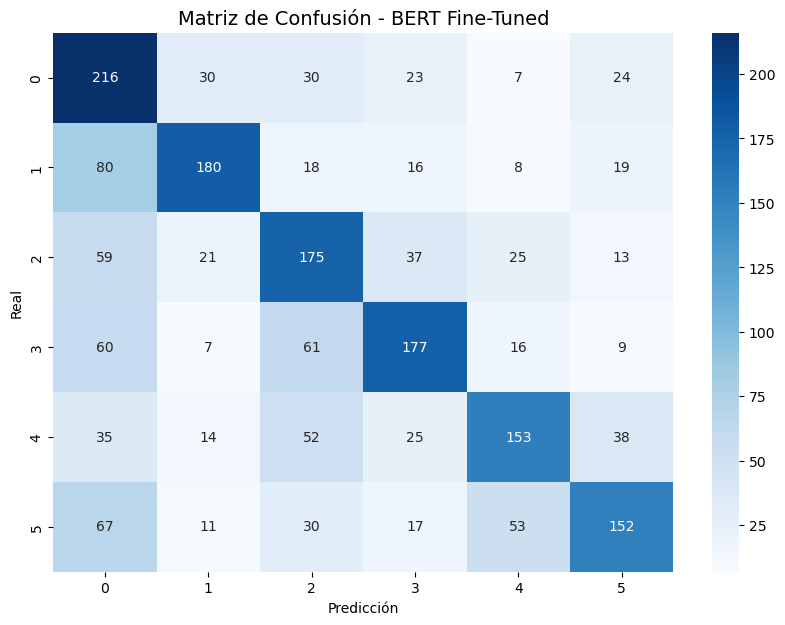


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.42      0.65      0.51       330
           1       0.68      0.56      0.62       321
           2       0.48      0.53      0.50       330
           3       0.60      0.54      0.57       330
           4       0.58      0.48      0.53       317
           5       0.60      0.46      0.52       330

    accuracy                           0.54      1958
   macro avg       0.56      0.54      0.54      1958
weighted avg       0.56      0.54      0.54      1958




In [ ]:
# Convertimos los y_test a sus etiquetas numéricas
y_test_numeric = [label2id[label] for label in y_test]

# Ahora podemos usar la función como siempre
evaluar_modelo("BERT Fine-Tuned", clf_ft, x_test, y_test_numeric)

Recordemos que los números corresponden a las etiquetas:

In [ ]:
label2id

{'ArtificialInteligence': 0,
 'DeepSeek': 1,
 'Physics': 2,
 'math': 3,
 'nasa': 4,
 'spacex': 5}

Observamos que la clase que mejor conseguimos predecir es 'Deepseek', mientras que la que peor predecimos es 'Physics'.

Las clases que menor confusión presentar son 'DeepSeek' y 'nasa' (22 casos mal clasificados), mientras que las que mayor confusión presentan son 'ArtificialInteligence' y 'DeepSeek' (100 casos mal clasificados), seguidos por 'Physics' y 'math' (98 casos mal clasificados) y por último 'nasa' y 'spacex' (91 casos mal clasificados). Esto es lo que era de esperar, pues he puesto categorías parecidas en parejas de dos (DeepSeek/ArtificialInteligence, math/Physics, nasa/spacex).

A pesar de que este 'accuracy' pueda parecer bajo tenemos que tener en cuenta que nuestros datos presentan mucho ruido, pues, como ya hemos mostrado anteriormente, hay comentarios que son prácticamente inclasificables.

#### Conclusiones

A lo largo de este ejercicio hemos desarrollado tres sistemas de clasificación de texto, cada uno con enfoques progresivamente más sofisticados, y los resultados obtenidos permiten extraer varias conclusiones clave.

En el Sistema 1, combinamos diferentes técnicas para vectorizar el texto como BOW, TF-IDF y BM25 con un clasificadores como Random Forest y LinearSVM, aplicando diferentes variantes de preprocesado y representación de texto. La mejor configuración se logró utilizando texto preprocesado y representaciones basadas en char-n-gramas para BM25 con Random Forest, alcanzando un accuracy de 0.4637, lo que supone una mejora sustancial respecto al baseline aleatorio (0.1667). Este sistema mostró que los char-n-gramas capturan patrones subléxicos útiles, como sufijos o prefijos frecuentes en ciertos subreddits, y que el preprocesado ayuda a reducir el vocabulario y el ruido, mejorando la generalización del modelo.

En el Sistema 2, se exploraron embeddings como FastText o Glove, aplicando también preprocesado. Aunque se esperaba una mejora respecto al sistema anterior por el uso de información semántica en los embeddings, los resultados no fueron tan satisfactorios. Sin embargo, se observó nuevamente que el uso de char-n-gramas y el preprocesado aportan beneficios: los primeros permiten capturar morfología y estructuras frecuentes, y el segundo reduce el tamaño del vocabulario y la variabilidad de los textos.

A pesar de usar estas representaciones de embeddings, notamos que el modelo Random Forest no conseguía buenos resultados. Esto se debe a que el espacio vectorial creado por los embeddings parece tener fronteras de decisión que son más fácilmente capturadas por un clasificador lineal como SVM. En contraste, Random Forest, al construir sus árboles de decisión con divisiones alineadas a los ejes, le resulta más difícil aproximar estas fronteras complejas en un espacio de alta dimensión como el de los embeddings.

El Sistema 3, basado en el fine-tuning de un modelo BERT, fue el más avanzado y el que mejor rendimiento consiguió, alcanzando un accuracy de 0.5378. Este resultado demuestra el poder de los modelos Transformers para capturar el contexto de los textos, incluso en presencia de ruido. Sin embargo, en este sistema, no se aplicó preprocesado ni se usaron char-n-gramas. Esto se debe a que los modelos como BERT incluyen su propio tokenizador, el cual ya trabaja sobre subpalabras y está optimizado para su arquitectura. Para incorporar char-n-gramas en este tipo de modelos, sería necesario un tokenizador específico a nivel de caracteres, lo cual implicaría un rediseño considerable del pipeline y una posible pérdida de compatibilidad con pesos preentrenados.

En resumen, podemos concluir que:

- Los char-n-gramas mejoran notablemente el rendimiento en los sistemas 1 y 2.

- El preprocesado (como la normalización de texto y la reducción de ruido) también contribuye positivamente en los sistemas tradicionales, pero no es compatible ni necesario en modelos como BERT, donde puede incluso afectar negativamente el rendimiento.

- El modelo fine-tuneado con Transformers es el más eficaz, aunque más costoso computacionalmente y con menos margen para personalización del preprocesado.

Estos hallazgos reflejan que no existe un único enfoque óptimo para todos los casos, y que cada tipo de modelo tiene sus fortalezas, limitaciones y requisitos específicos.

## Ejercicio 3: Búsqueda de hilos similares

Primero convertiremos nuestros datos para agrupar todos los comentarios en cada hilo (asumiendo que ya hemos importado nuestros datos a la variable 'df'):

In [ ]:
import pandas as pd

# Convertimos a lista de hilos
processed_threads = []
for subreddit, threads in df.items():
    for thread in threads:
        # Concatenar todos los comentarios en un solo string
        all_comments = " ".join(c['comment'] for c in thread.get('comments', []))

        # Crear copia del hilo y agregar subreddit + comentarios concatenados
        thread_data = {k: v for k, v in thread.items() if k != 'comments'}
        thread_data['subreddit'] = subreddit
        thread_data['all_comments'] = all_comments

        processed_threads.append(thread_data)

# Convertir a DataFrame
df_hilos = pd.DataFrame(processed_threads)

Como podemos observar, seguimos conservando toda la información del hilo, pero no de los comentarios, ya que los concatenamos.

In [ ]:
df_hilos.head()

flair  \
0  Autoplaying Video Warning   
1                      Image   
2                      Image   
3                      Image   
4                       News   

                                               title         author  \
0  Trump team prepares to "roll back funding for ...    CallMeDoc24   
1  New 50p coins out this year in the United King...  MohamedShaban   
2  Passing 30,000 volts through two beakers cause...           233C   
3  This remarkable photo shows a single atom trap...    ajitjohnson   
4             Physicist Stephen Hawking dies aged 76       DJ_MEDMA   

           date  score description subreddit  \
0  1.485186e+09  12961               Physics   
1  1.495785e+09  10281               Physics   
2  1.501016e+09  17174               Physics   
3  1.518608e+09   7676               Physics   
4  1.520999e+09  31383               Physics   

                                        all_comments  
0  Not to mention that Lockheed Martin has been m...  
1  I believe the new £1 are constant diameter as ...  
2  Well I mean, the current is always going to tr...  
3  Thanks, makes sense - that's why the oscillati...  
4  For all the loss we've suffered, it's probably...

Podemos ver la cantidad de carácteres de uno de estos largos comentarios:

In [ ]:
print(f"Hilo: {df_hilos.iloc[0]['title']}")
print(f"Subreddit: {df_hilos.iloc[0]['subreddit']}")
print(f"Todos los comentarios: {df_hilos.iloc[0]['all_comments'][:20]}...")
print(f"Longitud comentarios: {len(df_hilos.iloc[0]['all_comments'])}")

Hilo: Trump team prepares to "roll back funding for nuclear physics and advanced scientific computing research to 2008 levels"
Subreddit: Physics
Todos los comentarios: Not to mention that ...
Longitud comentarios: 15801


Como en el enunciado del ejercicio nos dicen que <<Para aprobar este apartado se utilizará la librería de fastText vista en clase para la obtención de
sentence embeddings.>> no nos vale el FastText que hemos utilizado anteriormente, pues ese lo hemos importado con la librería Gensim.

Procedemos a cargar el modelo y aplicar los word-embeddings o mejor dicho los sentence-embeddings a nuestros comentarios:

In [ ]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2025-04-17 11:33:33--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.41.96, 18.154.41.8, 18.154.41.57, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.41.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4,2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4,19G  3,22MB/s    in 25m 13s 

2025-04-17 11:58:46 (2,84 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import fasttext
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Cargar modelo binario de fastText (usa el bin, no el .vec)
fasttext_model = fasttext.load_model("cc.en.300.bin")

# Crear DataFrame
df_textos = pd.DataFrame(df_hilos, columns=["all_comments"])

# Obtener sentence embeddings con fastText
embeddings = df_textos["all_comments"].apply(lambda x: fasttext_model.get_sentence_vector(x))


In [ ]:
# Mostrar los primeros 5 embeddings
for i, embedding in enumerate(embeddings[:5]):
    print(f"Embedding {i+1}: {embedding[:10]}...")  # Mostrar solo los primeros 10 valores
    print(f"Longitud del embedding {i+1}: {len(embedding)}")

Embedding 1: [-0.01819373  0.00114881  0.00815618  0.04012547 -0.04237238 -0.00916698
  0.0078469  -0.00074912 -0.00054958 -0.00472785]...
Longitud del embedding 1: 300
Embedding 2: [-0.00835284  0.00077922  0.00484553  0.03977309 -0.03145795 -0.01669228
 -0.00399318 -0.00063267 -0.00301738 -0.00118646]...
Longitud del embedding 2: 300
Embedding 3: [-0.0117272   0.00064991  0.00532648  0.04129556 -0.03242375 -0.01693725
  0.00363648  0.00346194  0.00019199 -0.00350897]...
Longitud del embedding 3: 300
Embedding 4: [-0.01326666  0.00122806  0.00650853  0.03938122 -0.03019621 -0.02932854
  0.00052125 -0.00219296  0.00453908 -0.00231957]...
Longitud del embedding 4: 300
Embedding 5: [-0.00213419 -0.00022533  0.00076045  0.03498584 -0.02785324 -0.02423943
 -0.00151592  0.002489    0.0024732   0.00564032]...
Longitud del embedding 5: 300


Además nótese que tendremos tantos embeddings como hilos tengamos (20 hilos/subreddit x 6 subreddits = 120 hilos):

In [ ]:
print(len(embeddings))

120


Observamos que son vectores de 300 dimesiones (como bien indica el nombre del archivo 'cc.en.300.bin') y que cada uno tiene una representación diferente. Vamos a proceder a ver algunas representaciones gráficas utilizando como métrica para similitud de hilos la del coseno:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Convertimos a matriz numpy
embedding_matrix = np.vstack(embeddings)

# Similaridad coseno entre todos los textos
sim_matrix = cosine_similarity(embedding_matrix)


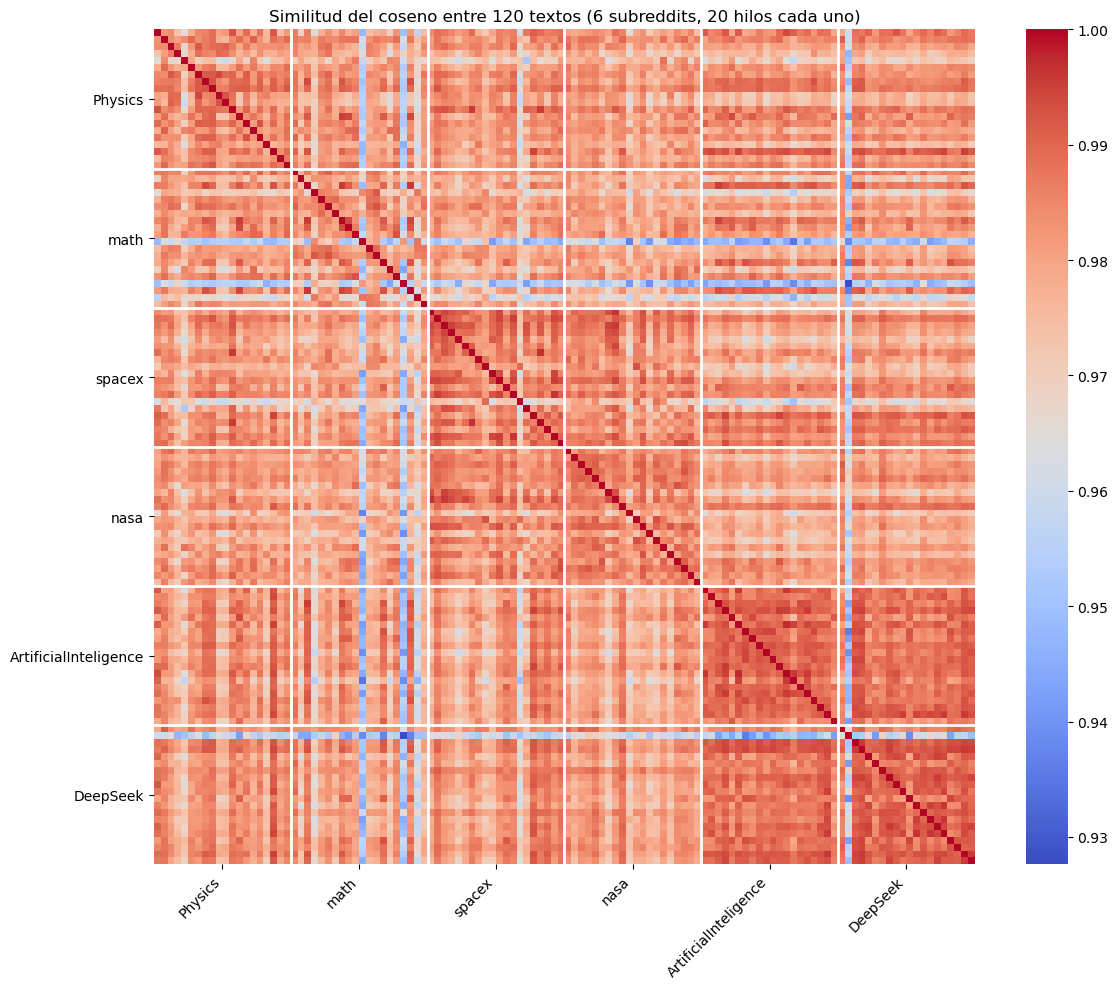

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Nombres de los subreddits
subreddits = list(df.keys())

# Crear el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sim_matrix, cmap="coolwarm", xticklabels=False, yticklabels=False)

# Agregar líneas divisorias para separar los subreddits (cada 20 hilos)
for i in range(20, 120, 20):
    plt.axhline(i, color='white', linewidth=2)  # Línea horizontal
    plt.axvline(i, color='white', linewidth=2)  # Línea vertical

# Agregar etiquetas de los subreddits en los ejes x e y
tick_positions = [10, 30, 50, 70, 90, 110]  # Centro de cada bloque de 20 hilos
plt.xticks(ticks=tick_positions, labels=subreddits, rotation=45, ha='right')
plt.yticks(ticks=tick_positions, labels=subreddits, rotation=0)

# Título
plt.title("Similitud del coseno entre 120 textos (6 subreddits, 20 hilos cada uno)")

# Ajustar diseño
plt.tight_layout()
plt.show()

Observamos que se forman dos grandes cuadrados de 40x40 píxeles: uno en el centro y otro abajo a la derecha. Estos cuadrados corresponden a los pares de clases (spacex, nasa) y (ArtificialInteligence, DeepSeek) respectivamente.

Vemos que los hilos que hay entre 'Physics' y 'math' no tienen tanta similitud entre ellos y dentro de sí mismos como los otros dos pares mencionados arriba, pues no se forma ese cuadrado de 40x40.

De las otras dos parejas sabemos que los hilos de 'DeepSeek' y 'ArtificialInteligence' son más similares entre ellos y dentro de sí mismos en general que 'spacex' y 'nasa', pues el cuadrado tiene colores más rojos.

También apreciamos que hay algunos hilos que tienen menos similitud con el resto, estos hilos son los que forman las líneas azules y hay unos 3 que se ven claramente: dos en 'math' y uno en 'DeepSeek'. Podríamos decir que hay en realidad 5, 6 o 7, pero eso depende de dónde pongamos el límite.

Vamos a buscar estos 3 hilos y ver de qué tratan:

In [ ]:
import numpy as np

# Calcular la similitud promedio para cada hilo, ignorando la diagonal (similitud consigo mismo)
avg_sim = (sim_matrix.sum(axis=1) - 1) / (sim_matrix.shape[1] - 1) # Restamos uno para quitar la simitud consigo mismo

# Obtener los índices con menor similitud promedio
outlier_indices = np.argsort(avg_sim)[:3]

print("Índices con menor similitud promedio:", outlier_indices)
# Mostramos los hilos correspondientes

for index in outlier_indices:
    hilo = df_hilos.iloc[index]
    print(f"\nHilo con índice {index}:")
    print(f"Subreddit: {hilo['subreddit']}")
    print(f"Título: {hilo['title']}")
    print(f"Comentarios: {hilo['all_comments'][:100]}...")  # Mostrar solo los primeros 50 caracteres
    print(f"Similitud promedio: {avg_sim[index]:.4f}")

Índices con menor similitud promedio: [ 30  36 101]

Hilo con índice 30:
Subreddit: math
Título: Kaprekar numbers are numbers whose square in that base can be split into 2 parts that add up to the original number
Comentarios: Non - mobile link: * * * ^ helper ^ v1. 1 ^ / r / helper _ ^ I ^ am ^ a ^ bot. ^ please ^ message ^ ...
Similitud promedio: 0.9544

Hilo con índice 36:
Subreddit: math
Título: 2^136279841-1 is the New Largest Known Prime Number
Comentarios: Let p _ N be the largest prime number. Consider the number q = p _ 0 p _ 1 … p _ N + 1 with p _ 0, p...
Similitud promedio: 0.9551

Hilo con índice 101:
Subreddit: DeepSeek
Título: did I jailbreak deepseek with..
Comentarios: Sure, but don't most developed countries (America, Japan) have the same population decline problem? ...
Similitud promedio: 0.9552


Nótese que la similitud promedio de cada hilo es altísima, alrededor de 0.9552. ¿Es esto un error?

No, no nos hemos equivocado al escoger los hilos con similitud más baja. Si nos fijamos en la gráfica de arriba (mapa de calor) vemos a la derecha que el rango de valores de similitud va desde un poco menos de 0.93 hasta 1, es decir, que todos tienen una similitud bastante alta.

Aún así vamos a analizar por qué estos hilos son los que menos similitud tiene con el resto:

Parece ser que los 2 primeros hilos que aparecen hablan sobre Teoría de Números, una rama de las matemáticas que estudia los números. Lo más probable es que en la mayoría de los comentarios la gran cantidad de texto sean números o ecuaciones matemáticas, por lo que no hay texto y hay una gran diferencia con el resto de los textos.

En cuanto al hilo de 'DeepSeek' no sé muy bien cuál es el motivo por el que puede ser tan diferente, por lo que vamos a ver más comentarios:

In [ ]:
for comentario in df['DeepSeek'][1]['comments']:
    print(comentario['comment'])
    print()

Sure, but don't most developed countries (America, Japan) have the same population decline problem? It's hardly just a china problem. But I do love what u did here!!!

Hi Op, a word about Japan, please?

It will answer whatever you ask. It is an emotionless answering machine that can present a thousand different aspects for a thousand different people. For example, if you ask it to praise a certain country, it can also express it perfectly.

I am curious about the arabian gulf / arabian peninsula countries. Can you share that?

* * TRUMP voice activated: USA!!! * * folks, let me tell you about this * disaster * of a country right rowland believe me, I know disasters, I’ve seen them, I’ve fixed them. Under * Trump *, we had it all: the best economy, the strongest military, the most beautiful clean coal. But now? Sad! # 1. The political losers sleepy Joe and the radical Left—they’re running this country into the ground, folks. * pathetic! * crooked Joe can’t even find his way off a stage

Parece ser que en este hilo se habla más de países y política que de inteligencia artificial o cualquier otro ámbito en los que estamos trabajando. Esta es la razón por la que este hilo destaca entre el resto y tiene una similitud más baja.

Si continuamos el análisis de la similitud de los hilos podemos buscar aquellos hilos que sean más similares:

In [ ]:
import numpy as np

# Crear una copia para evitar tocar la original
sim_matrix_nodiag = sim_matrix.copy()

# Llenar la diagonal con -1 para que no cuente como máximo
np.fill_diagonal(sim_matrix_nodiag, -1)

# Obtener los índices de los pares más similares
# Flatten y obtener los índices del top-N
top_n = 6 # A pesar de que vamos a obtener 3 pares, tenemos que obtener 6 porque se obtiene también el recíproco
flat_indices = np.argpartition(sim_matrix_nodiag.ravel(), -top_n)[-top_n:]
top_pair_indices = np.array(np.unravel_index(flat_indices, sim_matrix.shape)).T

# Filtrar para evitar pares recíprocos
unique_pairs = set()

for i, j in top_pair_indices:
    if (j, i) not in unique_pairs:  # Verificamos si el par ya se ha agregado en el orden inverso
        unique_pairs.add((i, j))

# Ordenar por similitud real
sorted_pairs = sorted(unique_pairs, key=lambda x: sim_matrix[x[0], x[1]], reverse=True)

# Mostrar los pares y sus similitudes
for i, j in sorted_pairs:
    print(f"Hilo {i} y Hilo {j} - similitud: {sim_matrix[i, j]:.4f}")


Hilo 85 y Hilo 92 - similitud: 0.9972
Hilo 56 y Hilo 46 - similitud: 0.9967
Hilo 115 y Hilo 111 - similitud: 0.9965


Vamos a ver de qué tratan estos hilos y sus subreddits:

In [ ]:
for num, (i, j) in enumerate(sorted_pairs):
    print(f"\nPar {num+1}:")

    # Acceder correctamente a las filas de df_hilos con los índices i y j
    hilo_i = df_hilos.iloc[i]
    hilo_j = df_hilos.iloc[j]

    print(f"\nHilo {i} - Subreddit: {hilo_i['subreddit']}")
    print(f"Título: {hilo_i['title']}")
    print(f"Comentarios: {hilo_i['all_comments'][:200]}...")  # Mostrar solo los primeros 100 caracteres
    print(f"Similitud: {sim_matrix[i, j]:.4f}")
    print()

    print(f"Hilo {j} - Subreddit: {hilo_j['subreddit']}")
    print(f"Título: {hilo_j['title']}")
    print(f"Comentarios: {hilo_j['all_comments'][:200]}...")  # Mostrar solo los primeros 100 caracteres
    print(f"Similitud: {sim_matrix[i, j]:.4f}")
    print()



Par 1:

Hilo 85 - Subreddit: ArtificialInteligence
Título: The problem isn't that AI will take our jobs; the problem is that we've built a society that needs jobs to be taken.
Comentarios: The first thing that will happen is the quality of commodity goods / services / food would go down — unless we are really strategic about how we approach this. Look at the budding authoritarian and hi...
Similitud: 0.9972

Hilo 92 - Subreddit: ArtificialInteligence
Título: How Long Before The General Public Gets It (and starts freaking out)
Comentarios: I have a question though, if lots of jobs are replaced and no one has money. Who's buying??? There are only 3 types of people in the world. Those who can count and those who can't. AI will be able to ...
Similitud: 0.9972


Par 2:

Hilo 56 - Subreddit: spacex
Título: Elon Musk on Twitter: "Today’s Falcon launch carries 2 SpaceX test satellites for global broadband. If successful, Starlink constellation will serve least served."
Comentarios: I guess t

Observamos que en el primer par ambos hilos son similares porque los dos tratan del hecho de que la IA en el futuro pueda reemplazarnos en los puestos de trabajo y sus posibles consecuencias.

En el segundo par, en ambos hilos se habla sobre que SpaceX va a lanzar satélites a la constelación de Starlink y que esto ayudará a proporcionar servicio.

Y en el último hilo de los que vamos a analizar parece que en ambos se critica la censura que tiene DeepSeek, pero no estoy muy convencido por lo que vamos a ver más comentarios de ambos hilos.

In [ ]:

print("Comentarios del hilo 115:\n")
for comentario in df['DeepSeek'][15]['comments'][:7]:
    print(comentario['comment'])
    print()

print("="*100)
print()

print("Comentarios del hilo 111:\n")
for comentario in df['DeepSeek'][11]['comments'][:7]:
    print(comentario['comment'])
    print()

Comentarios del hilo 115:

U probably don't care about the civil War USA (1860's) or Holomodor (Ukraine 1930s) either right?? All U care about is a woke AI that knows the right pronouns in use today? Right? I concur that you don't care about all of human history, but its a far step to tell the rest of us not to care that just because uncle sugar Xi offers you a woke AI for. 1 % of the oPenAI'woke standard', does't mean all of should buy a toolbar & declare fealty to uncle Xi? Until somebody in China releases a nonwoven AI that actually answers questions without woke lecturing on pronouns you can keep your AI, right now llama (meta), Google, OpenAI, and deeper are all selling woke swamp gas, anybody buying this stuff is a certified sucker The argument here is that you must have an iphone and uncle sugar Xi gives the best price, my argument is that nobody needs a smart phone, period nobody needs a woke AI, you feel real clever knowing that you done need to pay OpenAI $ 200 USD a month to

Parece ser que en ambos hilos se menciona repetidamente a China y a Xi Jingping (presidente de China). También hay cierto debate sobre el uso de DeepSeek.

Ahora vamos a visualizar los hilos como nubes de puntos para tratar de encontrar aquellos hilos que no pertenecen a su categoría:

In [ ]:
import numpy as np

# Convertimos correctamente a una matriz 2D
embeddings_np = np.vstack(embeddings).astype(np.float32)
print(embeddings_np.shape)  # debería dar (120, 300)


(120, 300)


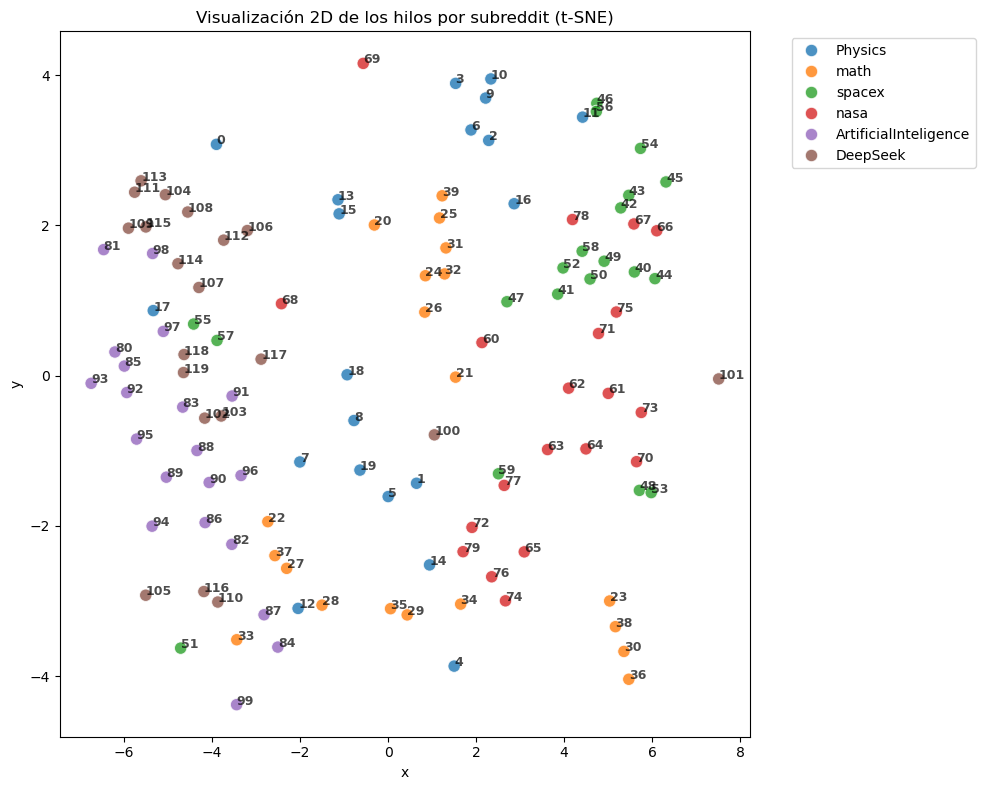

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reducimos la dimensionalidad de los embeddings a 2D para visualizar
tsne = TSNE(n_components=2, metric="cosine", random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)  # embeddings_np: (120, 300)

# Creamos un DataFrame para visualizar más fácil
df_plot = pd.DataFrame(embeddings_2d, columns=["x", "y"])
df_plot["subreddit"] = df_hilos["subreddit"].values

# Asignamos colores por subreddit
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x="x", y="y", hue="subreddit", palette="tab10", s=80, alpha=0.8)

# Añadir los índices sobre cada punto en negrita
for idx, row in df_plot.iterrows():
    plt.text(
        row["x"], row["y"],
        str(idx),
        fontsize=9,
        alpha=0.7,
        fontweight="bold"
    )

plt.title("Visualización 2D de los hilos por subreddit (t-SNE)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Volvemos a ver que las parejas de categorías aparecen juntas en el espacio:
 - 'ArtificialInteligence' (morado) y 'DeepSeek' (marrón)
 - 'Physics' (azul) y 'math' (amarillo)
 - 'nasa' (rojo) y 'spacex' (verde)


Además el grupo más disperso es 'Physics' (recordemos que esta era la categoría que tenía más problemas para ser clasificada), seguido por 'math'. Observamos por ejemplo que 'spacex' tiene un atípico, etiquetado con el número 51, vamos a ver de qué trata:

In [ ]:
# Función para obtener los detalles de un hilo por su índice
def obtener_hilo_detalles(index, df_hilos, avg_sim):
    hilo = df_hilos.iloc[index]
    print(f"\nHilo con índice {index}:")
    print(f"Subreddit: {hilo['subreddit']}")
    print(f"Título: {hilo['title']}")
    print(f"Comentarios: {hilo['all_comments'][:100]}...")  # Mostrar solo los primeros 100 caracteres
    print(f"Similitud promedio: {avg_sim[index]:.4f}")

# Función para obtener el subreddit y los comentarios de un hilo por su índice
def obtener_comentarios_subreddit(index, df, subreddit_keys):
    # Determinar el subreddit al que pertenece el hilo
    subreddit_label_index = index // 20
    subreddit_name = subreddit_keys[subreddit_label_index]

    # Obtener el índice local dentro del subreddit
    local_index = index % 20

    print(f"Hilo {index} pertenece al subreddit '{subreddit_name}'\n")
    print(f"Comentarios del hilo {index}:\n")

    for comentario in df[subreddit_name][local_index]['comments'][:7]:
        print(comentario['comment'])
        print()

index = 51
subreddit_keys = list(df.keys())

# Obtener detalles del hilo
obtener_hilo_detalles(index, df_hilos, avg_sim)

# Obtener comentarios del hilo en su subreddit correspondiente
obtener_comentarios_subreddit(index, df, subreddit_keys)



Hilo con índice 51:
Subreddit: spacex
Título: We are the SpaceX software team, ask us anything!
Comentarios: Hypothetically if the screens on Crew Dragon fail, and the autonomous navigation fails as well. How ...
Similitud promedio: 0.9821
Hilo 51 pertenece al subreddit 'spacex'

Comentarios del hilo 51:

Hypothetically if the screens on Crew Dragon fail, and the autonomous navigation fails as well. How would the crew either dock or detroit?

Hi, with the new SpaceX astronaut suits, what is the level of security for the astronauts, i. E., can they self - sufficiently float in space and, as an example, boost themselves back to the dragon capsule or to the safety of the ISS if in a close vicinity to it in case of an emergency? Also, is there integrated oxygen supply in the suit and how long does it last? The new suit must have a system to collect body excretion fluids, how does that work and how long can it last? Thank you and regards, Petar.

Who is going to fly on the early missions? 

Vemos que el hilo se encuentra en la zona de 'ArtificialInteligence' y 'DeepSeek'. Esto es porque este es un hilo creado por el equipo de software de SpaceX, en el que la gente hace preguntas sobre programación.

El hilo 68, que pertenece a 'nasa' también parece ser un atípico, vamos a comprobar sobre qué trata:

In [ ]:
# Uso de las funciones:
index = 68
subreddit_keys = list(df.keys())

# Obtener detalles del hilo
obtener_hilo_detalles(index, df_hilos, avg_sim)

# Obtener comentarios del hilo en su subreddit correspondiente
obtener_comentarios_subreddit(index, df, subreddit_keys)


Hilo con índice 68:
Subreddit: nasa
Título: From the International Space Station: I voted today — Kate Rubins
Comentarios: That ballot’s likely to turn up in a crater somewhere, clearly fraud. Name one politician that in't?...
Similitud promedio: 0.9844
Hilo 68 pertenece al subreddit 'nasa'

Comentarios del hilo 68:

That ballot’s likely to turn up in a crater somewhere, clearly fraud.

Name one politician that in't? Low

What an unbelievable load of shit

This is not a question in Estonia, I'm just saying.

Hama, yeah because voting is real right…what a joke…Everything is so censored and corrupted and manipulated with false information to the point where voting is ridiculous all they have to do is say the right lies and control the information and they get whatever outcome desired, I believe it’s absolutely what happens and no longer participate, actually I know a some people who don’t even bother voting anymore because they don’t believe it’s at all real! The twitter files are distu

Vemos que este trata sobre política y no sobre el espacio o la NASA en sí.

El 101 también es un atípico, en este caso de 'DeepSeek':

In [ ]:
# Uso de las funciones:
index = 101
subreddit_keys = list(df.keys())

# Obtener detalles del hilo
obtener_hilo_detalles(index, df_hilos, avg_sim)

# Obtener comentarios del hilo en su subreddit correspondiente
obtener_comentarios_subreddit(index, df, subreddit_keys)


Hilo con índice 101:
Subreddit: DeepSeek
Título: did I jailbreak deepseek with..
Comentarios: Sure, but don't most developed countries (America, Japan) have the same population decline problem? ...
Similitud promedio: 0.9552
Hilo 101 pertenece al subreddit 'DeepSeek'

Comentarios del hilo 101:

Sure, but don't most developed countries (America, Japan) have the same population decline problem? It's hardly just a china problem. But I do love what u did here!!!

Hi Op, a word about Japan, please?

It will answer whatever you ask. It is an emotionless answering machine that can present a thousand different aspects for a thousand different people. For example, if you ask it to praise a certain country, it can also express it perfectly.

I am curious about the arabian gulf / arabian peninsula countries. Can you share that?

* * TRUMP voice activated: USA!!! * * folks, let me tell you about this * disaster * of a country right rowland believe me, I know disasters, I’ve seen them, I’ve fixed 

Este es el hilo que vimos anteriormente que trataba sobre geopolítica.

### Uso de distintos modelos de sentence-transformers

Vamos a pasar a usar modelos de sentence-transformers de hugging-face para hacer la misma tarea.

Primero instalaremos la librería 'sentence-transformers':

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

Vamos a crear una función para obtener los embeddings con los modelos que vamos a seleccionar:

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Lista de modelos en inglés
model_names = [
    'sentence-transformers/paraphrase-MiniLM-L6-v2',
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/all-MPNet-base-v2'
]

# Función para obtener embeddings de los títulos de los hilos
def obtener_embeddings(model_name, textos):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(textos, convert_to_tensor=True)
    return embeddings



Ahora podemos ejecutar la función para obtener los hilos de cada modelo:

In [ ]:
# Obtener los embeddings para cada modelo
embeddings_dict = {}
for model_name in model_names:
    embeddings_dict[model_name] = obtener_embeddings(model_name, df_hilos['all_comments'].tolist())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Una vez que ya tenemos los embeddings podemos compararlos cualitativamente para ver cuál es el mejor:

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch  # Asegúrate de importar torch si tus embeddings son tensores

# Definimos la función tsne_visualization
def tsne_visualization(embeddings, model_name, subreddit_list, ax):
    tsne = TSNE(n_components=2, metric="cosine", random_state=42)

    # Verifica si los embeddings son un tensor de PyTorch en CUDA (GPU)
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().detach().numpy()  # Mueve el tensor a la CPU y convierte a numpy

    embeddings_2d = tsne.fit_transform(embeddings)  # Embeddings de cada modelo

    # Crear DataFrame con las coordenadas 2D
    df_plot = pd.DataFrame(embeddings_2d, columns=["x", "y"])
    df_plot["subreddit"] = subreddit_list  # Usamos la lista de subreddits

    # Crear visualización en el subplot correspondiente
    sns.scatterplot(
        data=df_plot,
        x="x",
        y="y",
        hue="subreddit",
        palette="tab10",
        s=80,
        alpha=0.8,
        ax=ax,
        legend=False  # No mostramos leyenda en ningún subplot
    )

    # Añadir los índices sobre cada punto en negrita
    for idx, row in df_plot.iterrows():
        ax.text(
            row["x"], row["y"],
            str(idx),
            fontsize=9,
            alpha=0.7,
            fontweight="bold"
        )

    ax.set_title(f"{model_name}")


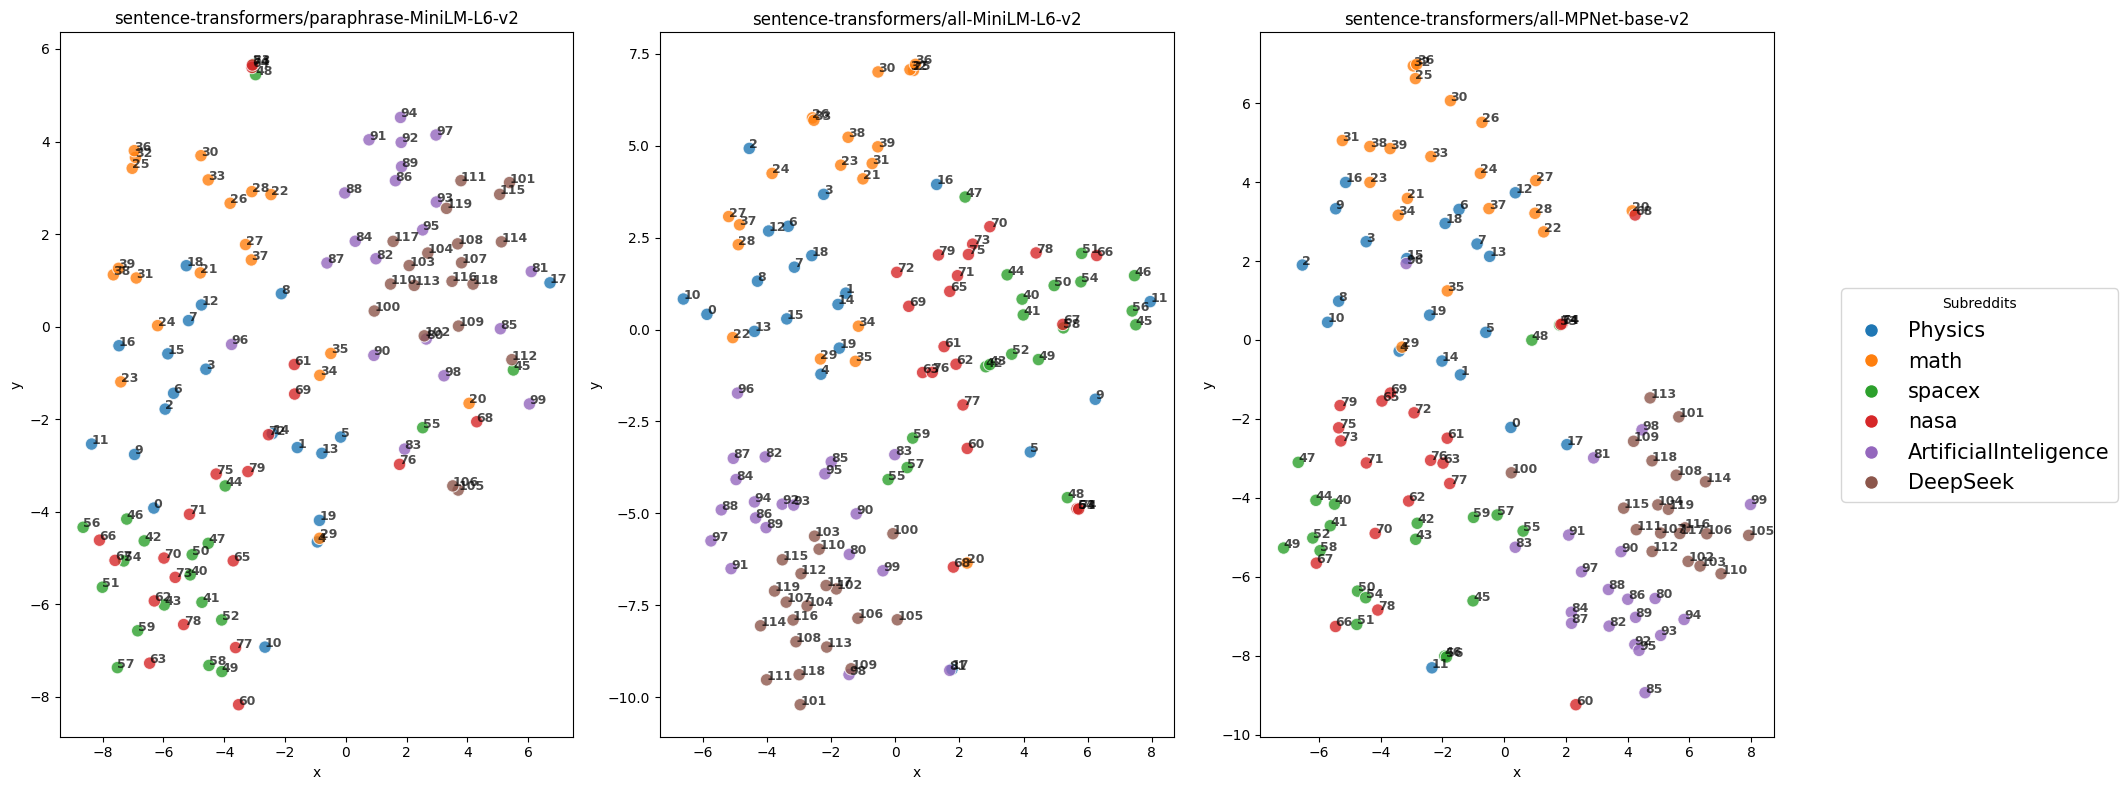

In [ ]:

# Crear los subplots (1 fila, 3 columnas)
fig, axes = plt.subplots(1, len(embeddings_dict), figsize=(18, 8))  # Mantengo el tamaño original

# Recorremos los subreddits para obtener los embeddings y crear la lista de subreddits
subreddit_list = df_hilos['subreddit'].values  # Obtenemos los subreddits del DataFrame
for i, (model_name, embeddings) in enumerate(embeddings_dict.items()):
    tsne_visualization(embeddings, model_name, subreddit_list, axes[i])

# Crear la leyenda global manualmente
unique_subreddits = list(dict.fromkeys(subreddit_list))  # Obtener subreddits únicos
palette = sns.color_palette("tab10", len(unique_subreddits))  # Obtener colores de la paleta
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in palette]
fig.legend(handles, unique_subreddits, bbox_to_anchor=(1.02, 0.5), loc="center left", title="Subreddits", ncol=1, fontsize=15)

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=0.2)  # Espacio moderado entre subplots

# Ajustar el espaciado de la figura y reservar espacio para la leyenda
plt.tight_layout(rect=[0, 0, 1, 1])  # Dejamos espacio a la derecha para la leyenda

plt.show()

Todavía no vamos a hacer el análisis cualitativo, pues más adelante se hará, ya que vamos a modificar el conjunto de datos por algo que veremos a continuación.

Procedemos a calcular numéricamente las similitudes entre hilos:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Función para calcular la similitud coseno y mostrar los resultados
def calcular_similitudes(embeddings, model_name):
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().detach().numpy()

    sim_matrix = cosine_similarity(embeddings)

    # Utilizamos un set para evitar duplicados
    top_similar_pairs = set()
    for i in range(len(sim_matrix)):
        for j in range(i + 1, len(sim_matrix)):
            top_similar_pairs.add((i, j, sim_matrix[i][j]))

    # Convertimos el set a una lista y la ordenamos
    top_similar_pairs = sorted(top_similar_pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop 5 pares más similares para el modelo {model_name}:")
    for i, j, sim in top_similar_pairs[:5]:
        print(f"Hilo {i} y Hilo {j} - Similitud: {sim:.4f}")

    return top_similar_pairs

In [ ]:

top_similar = []

# Comparar similitudes para cada modelo
for model_name, embeddings in embeddings_dict.items():
    top_similar = calcular_similitudes(embeddings, model_name)



Top 5 pares más similares para el modelo sentence-transformers/paraphrase-MiniLM-L6-v2:
Hilo 64 y Hilo 74 - Similitud: 0.9103
Hilo 53 y Hilo 74 - Similitud: 0.9030
Hilo 53 y Hilo 64 - Similitud: 0.8714
Hilo 48 y Hilo 74 - Similitud: 0.7136
Hilo 48 y Hilo 64 - Similitud: 0.7017

Top 5 pares más similares para el modelo sentence-transformers/all-MiniLM-L6-v2:
Hilo 64 y Hilo 74 - Similitud: 0.8519
Hilo 53 y Hilo 74 - Similitud: 0.8484
Hilo 53 y Hilo 64 - Similitud: 0.8438
Hilo 107 y Hilo 119 - Similitud: 0.7047
Hilo 48 y Hilo 64 - Similitud: 0.6732

Top 5 pares más similares para el modelo sentence-transformers/all-MPNet-base-v2:
Hilo 64 y Hilo 74 - Similitud: 0.9628
Hilo 53 y Hilo 74 - Similitud: 0.9562
Hilo 53 y Hilo 64 - Similitud: 0.9251
Hilo 104 y Hilo 112 - Similitud: 0.7591
Hilo 107 y Hilo 117 - Similitud: 0.7435


Para los 3 primeros pares de hilos más similares, todos los modelos obtenen los mismos hilos, lo cuál quiere indicar que se llega a una "convención" entre los modelos de los hilos que son más similares.

Podemos visualizar estos tres primeros pares:

In [ ]:
for num, (i, j, sim) in enumerate(top_similar[:3]):
    print(f"\nPar {num+1}:")

    # Acceder correctamente a las filas de df_hilos con los índices i y j
    hilo_i = df_hilos.iloc[i]
    hilo_j = df_hilos.iloc[j]

    print(f"\nHilo {i} - Subreddit: {hilo_i['subreddit']}")
    print(f"Título: {hilo_i['title']}")
    print(f"Comentarios: {hilo_i['all_comments'][:200]}...")  # Mostrar solo los primeros 100 caracteres
    print(f"Similitud: {sim}")
    print()

    print(f"Hilo {j} - Subreddit: {hilo_j['subreddit']}")
    print(f"Título: {hilo_j['title']}")
    print(f"Comentarios: {hilo_j['all_comments'][:200]}...")  # Mostrar solo los primeros 100 caracteres
    print(f"Similitud: {sim}")
    print()


Par 1:

Hilo 64 - Subreddit: nasa
Título: What a wonderful view of earth!
Comentarios: Acronyms, initialises, abbreviations, contractions, and other phrases which expand to something larger, that I've seen in this thread: | fewer letters | more letters | | - - - - - - - | - - - - - - - ...
Similitud: 0.962823748588562

Hilo 74 - Subreddit: nasa
Título: My grandfather worked for NASA in Huntsville, AL. Here, he is shaking hands with President Kennedy. He had a first grade education and was absolutely brilliant.
Comentarios: Acronyms, initialises, abbreviations, contractions, and other phrases which expand to something larger, that I've seen in this thread: | fewer letters | more letters | | - - - - - - - | - - - - - - - ...
Similitud: 0.962823748588562


Par 2:

Hilo 53 - Subreddit: spacex
Título: The moon rises between Starship SN9 and Starship SN10 yesterday evening.
Comentarios: Acronyms, initialises, abbreviations, contractions, and other phrases which expand to something larger, t

Vemos que el primer comentario en cada uno de estos hilos es el mismo, vamos a ver qué dice exactamente:

In [ ]:
df['nasa'][4]['comments'][0]

{'user': 'Decronym',
 'comment': 'Acronyms, initialises, abbreviations, contractions, and other phrases which expand to something larger, that I\'ve seen in this thread: | fewer letters | more letters | | - - - - - - - | - - - - - - - - - | - - - | | [ISRO] (/ r / NASA / comments / does / stub / f72bp2e " last usage ") | Indian Space Research Organisation | | [is] (/ r / NASA / comments / does / stub / f6qsihp " last usage ") | specific impulse (as explained by [Scott Manley] on YouTube) | | | internet service provider | | [KSP] (/ r / NASA / comments / does / stub / f6qvv8k " last usage ") | * Kerbal Space Program *, the rocketry simulator | | [mon] (/ r / NASA / comments / does / stub / f72bp2e " last usage ") | Mars Orbiter Mission | | [PSLV] (/ r / NASA / comments / does / stub / f72bp2e " last usage ") | Polar Satellite Launch Vehicle | * * note * *: Decronym for Reddit is no longer supported, and Decronym has moved to Lemmy; requests for support and new installations should be di

In [ ]:
df['nasa'][14]['comments'][0]

{'user': 'Decronym',
 'comment': 'Acronyms, initialises, abbreviations, contractions, and other phrases which expand to something larger, that I\'ve seen in this thread: | fewer letters | more letters | | - - - - - - - | - - - - - - - - - | - - - | | [JPL] (/ r / NASA / comments / 11fmwm4 / stub / jacque " last usage ") | Jet Propulsion Lab, Pasadena, California | | [KSC] (/ r / NASA / comments / 11fmwm4 / stub / jacque " last usage ") | Kennedy Space Center, Florida | | [MSFC] (/ r / NASA / comments / 11fmwm4 / stub / jakmqwk " last usage ") | Marshall Space Flight Center, Alabama | | [SLS] (/ r / NASA / comments / 11fmwm4 / stub / naomi " last usage ") | Space Launch System heavy - lift | | [USAF] (/ r / NASA / comments / 11fmwm4 / stub / jammy " last usage ") | United States Air Force | | [VAB] (/ r / NASA / comments / 11fmwm4 / stub / jalldm3 " last usage ") | vehicle assembly building | * * note * *: Decronym for Reddit is no longer supported, and Decronym has moved to Lemmy; requ

Parece ser que hay un usario que se llama 'Decronym' y que pone ese comentario exactamente en varios hilos, introduciendo un sesgo importante y haciendo que los modelos no consigan calcular la similitud correctamente.

Esto revela una debilidad de los tres modelos que estamos estudiando: si un comentario idéntico aparece en hilos distintos, la similitud calculada entre esos hilos aumenta considerablemente, aunque sus temas principales sean diferentes. Esto puede llevar a que el modelo perciba una conexión fuerte donde realmente no la hay, basándose únicamente en la coincidencia de texto exacto.

Vamos a modificar nuestro conjunto de datos para tratar de evitar a ese usuario y ver si mejora la obtención de similitud:

In [ ]:
# Creamos una copia del diccionario original para no modificarlo
df_sin_decronym = df.copy()

# Eliminamos los comentarios del usuario 'Decronym'
for subreddit, threads in df_sin_decronym.items():
    for thread in threads:
        if 'comments' in thread:
            thread['comments'] = [
                comment for comment in thread['comments']
                if comment.get('user') != 'Decronym'
            ]


Ahora aplicamos el resto de pasos para obtener los comentarios y procesarlos:

In [ ]:
import pandas as pd

# Convertimos a lista de hilos
processed_threads = []
for subreddit, threads in df.items():
    for thread in threads:
        # Concatenar todos los comentarios en un solo string
        all_comments = " ".join(c['comment'] for c in thread.get('comments', []))

        # Crear copia del hilo y agregar subreddit + comentarios concatenados
        thread_data = {k: v for k, v in thread.items() if k != 'comments'}
        thread_data['subreddit'] = subreddit
        thread_data['all_comments'] = all_comments

        processed_threads.append(thread_data)

# Convertir a DataFrame
df_hilos_sin_decronym = pd.DataFrame(processed_threads)

In [ ]:
# Obtener los embeddings para cada modelo
embeddings_dict_sin_decronym = {}
for model_name in model_names:
    embeddings_dict_sin_decronym[model_name] = obtener_embeddings(model_name, df_hilos_sin_decronym['all_comments'].tolist())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Volvemos a calcular las similitudes:

In [ ]:
import torch

top_similar_sin_decronym = {}

# Comparar similitudes para cada modelo
for model_name, embeddings in embeddings_dict_sin_decronym.items():
    top_similar_sin_decronym[model_name] = calcular_similitudes(embeddings, model_name)



Top 5 pares más similares para el modelo sentence-transformers/paraphrase-MiniLM-L6-v2:
Hilo 43 y Hilo 62 - Similitud: 0.6510
Hilo 54 y Hilo 67 - Similitud: 0.6417
Hilo 89 y Hilo 92 - Similitud: 0.6360
Hilo 107 y Hilo 119 - Similitud: 0.6331
Hilo 32 y Hilo 36 - Similitud: 0.6231

Top 5 pares más similares para el modelo sentence-transformers/all-MiniLM-L6-v2:
Hilo 107 y Hilo 119 - Similitud: 0.7047
Hilo 107 y Hilo 116 - Similitud: 0.6338
Hilo 92 y Hilo 93 - Similitud: 0.6334
Hilo 104 y Hilo 108 - Similitud: 0.6268
Hilo 104 y Hilo 107 - Similitud: 0.6252

Top 5 pares más similares para el modelo sentence-transformers/all-MPNet-base-v2:
Hilo 104 y Hilo 112 - Similitud: 0.7591
Hilo 107 y Hilo 117 - Similitud: 0.7435
Hilo 104 y Hilo 117 - Similitud: 0.7200
Hilo 107 y Hilo 119 - Similitud: 0.7095
Hilo 92 y Hilo 95 - Similitud: 0.7093


Procedemos a mostrar los dos primeros pares de hilos más parecidos para cada modelo:

In [ ]:
for model_name, sim_list in top_similar_sin_decronym.items():
    print(f"\nModelo: {model_name}")

    for num, (i, j, sim) in enumerate(sim_list[:2]):
        print(f"\nPar {num + 1}:")

        hilo_i = df_hilos_sin_decronym.iloc[i]
        hilo_j = df_hilos_sin_decronym.iloc[j]

        print(f"\nHilo {i} - Subreddit: {hilo_i['subreddit']}")
        print(f"Título: {hilo_i['title']}")
        print(f"Comentarios: {hilo_i['all_comments'][:200]}...")  # primeros 200 caracteres
        print(f"Similitud: {sim:.4f}")

        print(f"\nHilo {j} - Subreddit: {hilo_j['subreddit']}")
        print(f"Título: {hilo_j['title']}")
        print(f"Comentarios: {hilo_j['all_comments'][:200]}...")
        print(f"Similitud: {sim:.4f}")
        print("-" * 80)



Modelo: sentence-transformers/paraphrase-MiniLM-L6-v2

Par 1:

Hilo 43 - Subreddit: spacex
Título: @ElonMusk: Payload will be my midnight cherry Tesla Roadster playing Space Oddity. Destination is Mars orbit. Will be in deep space for a billion years or so if it doesn’t blow up on ascent.
Comentarios: It's a pretty cool place (except it's a hot place). If they're trying to launch this into an actual Mars orbit, would't they have to have engines optimised for interplanetary travel fro the final burn...
Similitud: 0.6510

Hilo 62 - Subreddit: nasa
Título: Insight has landed! (dust cover on)
Comentarios: Well then if it's 100 % it's twice as fast? So that's still crazy. Yeah, it changes as earth and Mars orbit the sun and move closer or further away from one another. Just imagine if someone forgot to ...
Similitud: 0.6510
--------------------------------------------------------------------------------

Par 2:

Hilo 54 - Subreddit: spacex
Título: NASA Picks SpaceX to Land Next Americans o

El primer modelo (sentence-transformers/paraphrase-MiniLM-L6-v2) no consigue resultados tan buenos como los otros dos, pues a simple vista, los hilos que ha recolectado sí que son de la misma temática pero no hablan de la misma noticia, como sí pasa con los otros modelos.

El segundo modelo consigue resultados algo mejores, pues parece obtener hilos de 'DeepSeek' en los que más bien se habla sobre política.

Y el tercero consigue resultados similares al primero, aunque en el segundo par consigue exitosamente encontrar dos hilos en los que se comenta la misma noticia un ataque de DDOS a DeepSeek.

Si volvemos a graficar la visualización del clústering de grupos no debería de cambiar demasiado:

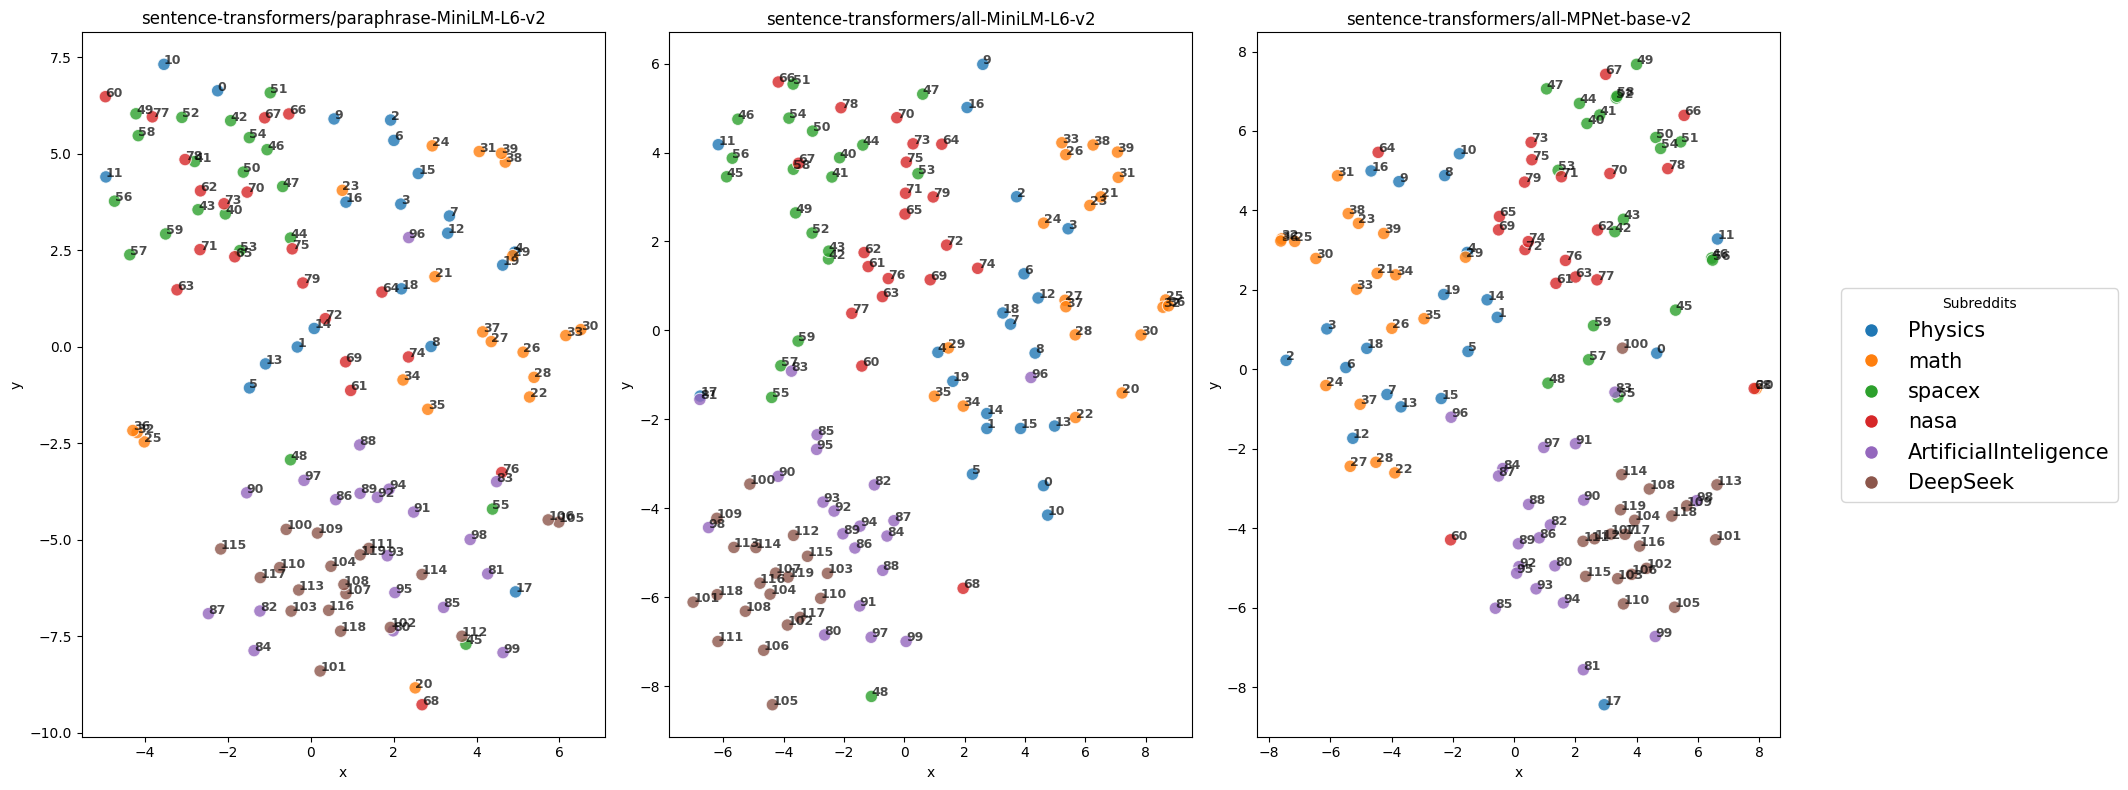

In [ ]:
import matplotlib.pyplot as plt

# Crear los subplots (1 fila, 3 columnas)
fig, axes = plt.subplots(1, len(embeddings_dict_sin_decronym), figsize=(18, 8))  # Mantengo el tamaño original

# Recorremos los subreddits para obtener los embeddings y crear la lista de subreddits
subreddit_list = df_hilos_sin_decronym['subreddit'].values  # Obtenemos los subreddits del DataFrame
for i, (model_name, embeddings) in enumerate(embeddings_dict_sin_decronym.items()):
    tsne_visualization(embeddings, model_name, subreddit_list, axes[i])

# Crear la leyenda global manualmente
unique_subreddits = list(dict.fromkeys(subreddit_list))  # Obtener subreddits únicos
palette = sns.color_palette("tab10", len(unique_subreddits))  # Obtener colores de la paleta
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in palette]
fig.legend(handles, unique_subreddits, bbox_to_anchor=(1.02, 0.5), loc="center left", title="Subreddits", ncol=1, fontsize=15)

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=0.2)  # Espacio moderado entre subplots

# Ajustar el espaciado de la figura y reservar espacio para la leyenda
plt.tight_layout(rect=[0, 0, 1, 1])  # Dejamos espacio a la derecha para la leyenda

plt.show()

Observamos que, de nuevo, las clases están mezcladas por pares.

Viendo la gráfica los modelos que mejor consiguen agrupar las categorías son 'sentence-transformers/all-MiniLM-L6-v2' y 'sentence-transformers/all-MPNet-base-v2'. El clustering conseguidos por estos es prácticamente el mismo, pero haciendo un 'flip horizontal'.

Podemos también visualizar el mapa de calor generado por cada modelo:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def mostrar_mapa_calor(sim_matrix, subreddits, modelo, ax, hilos_por_subreddit=20):
    total_hilos = len(subreddits) * hilos_por_subreddit

    # Dibujamos sin colorbar
    hm = sns.heatmap(
        sim_matrix,
        cmap="coolwarm",
        xticklabels=False,
        yticklabels=False,
        ax=ax,
        cbar=False
    )

    # Líneas divisorias
    for i in range(hilos_por_subreddit, total_hilos, hilos_por_subreddit):
        ax.axhline(i, color='white', linewidth=2)
        ax.axvline(i, color='white', linewidth=2)

    # Etiquetas centradas
    tick_positions = [
        i * hilos_por_subreddit + hilos_por_subreddit // 2
        for i in range(len(subreddits))
    ]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(subreddits, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(subreddits, rotation=0, fontsize=8)

    ax.set_title(modelo, fontsize=10)
    return hm


<ipython-input-38-e9dbf326194b>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


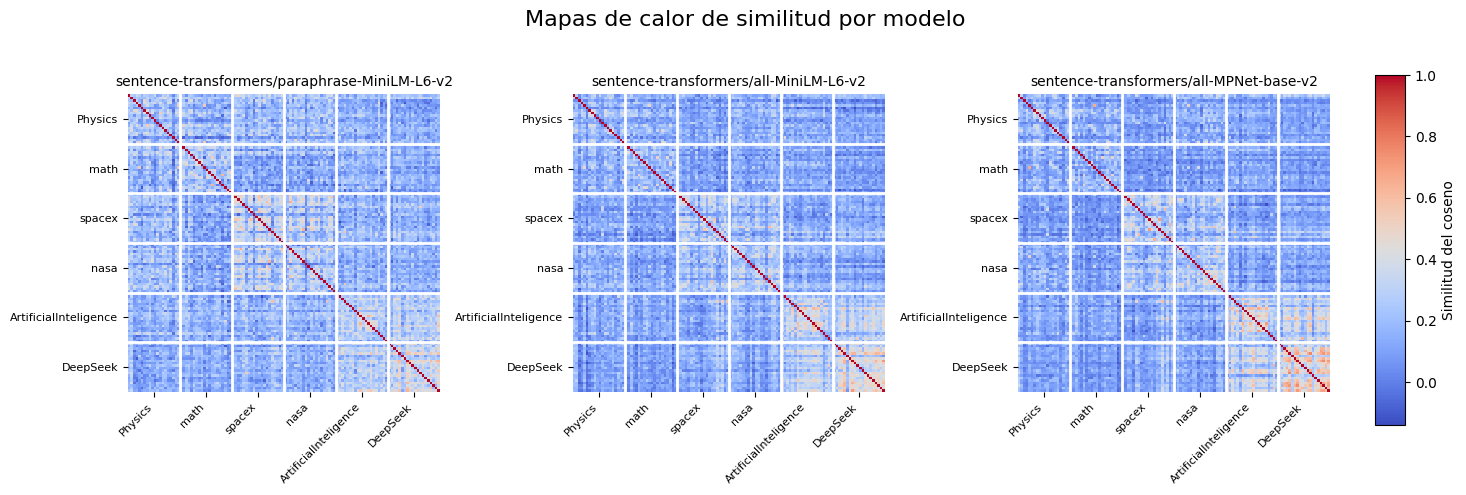

In [ ]:

# --- Parámetros ---
subreddits = list(df.keys())
num_modelos = len(embeddings_dict_sin_decronym)

# Preparo figura y ejes
fig, axes = plt.subplots(
    ncols=num_modelos,
    figsize=(5 * num_modelos, 5),
    squeeze=False
)
axes = axes[0]  # extract list

# Dibujo cada heatmap y guardo la referencia del primero
heatmap_ref = None
for ax, (model_name, embeddings) in zip(axes, embeddings_dict_sin_decronym.items()):
    sim_matrix = cosine_similarity(embeddings)
    hm = mostrar_mapa_calor(sim_matrix, subreddits, model_name, ax)
    if heatmap_ref is None:
        heatmap_ref = hm

# Creo un eje extra para la colorbar (ajusta [left,bottom,width,height] si lo necesitas)
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(
    heatmap_ref.collections[0],
    cax=cax,
    label='Similitud del coseno'
)

fig.suptitle("Mapas de calor de similitud por modelo", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


El primer modelo no parece encontrar mucha similitud entre los hilos, solo alguna relación entre los pares de categorías parecidas.

El segundo modelo consigue relacionar los pares de categorías con excepción de 'math' y 'Physics', dando sobre todo similitudes muy grandes en 'DeepSeek'.

El tercer modelo consigue lo mismo que el segundo pero acentuado aún más las similitudes dentro de 'DeepSeek'.

Vemos además que en este caso la similitud del coseno con los embeddings generados por estos modelos es mucho menor que para los embeddings generados con FastText.

Esto es porque con `fasttext_model.get_sentence_vector()`, FastText promedia vectores de palabras/subpalabras, agrupando vectores de documentos y dando alta similitud (rango aproximado [0.93, 1]). Los Sentence Transformers están entrenados para diferenciar significado a nivel de frase/documento completo. Esto crea un espacio donde textos distintos están más separados, dando un rango de similitud aproximado más amplio [0, 1].

### Conclusiones sobre el mejor modelo entre los Sentence Transformers

Habiendo visto todo esto, podemos concluir que el mejor modelo es 'sentence-transformers/all-MPNet-base-v2', pues, aunque a la hora de calcular similitudes tiene rendimientos muy similares a 'sentence-transformers/all-MiniLM-L6-v2' y hace un clustering muy parecido, consigue hacer un cálculo de similitud más discriminante.

## Ejercicio 4: Análisis de subjetividad de los comentarios

Para este ejercicio utilizaremos un modelo para hacer la clasificación de los sentimientos para cada comentario, una vez que tengamos los comentarios ya procesados pasaremos a guardar el sentimiento de nuevo en el JSON correspondiente.

Primero cargaremos todos los modelos a utilizar:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Cargar el modelo y el tokenizador para sentimiento
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

# Cargar el modelo y el tokenizador para emociones
emotion_model_name = "michellejieli/emotion_text_classifier"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cuda:0
Device set to use cuda:0


Aquí, lo que hacemos es configurar dos pipelines (sentimiento y emoción) de Hugging Face. Después, he creado las funciones `obtener_sentimiento` y `obtener_emocion` que nos permiten aplicar los pipelines a lotes de comentarios para predecir sus etiquetas y obtener las probabilidades asociadas a cada una.

In [ ]:

MAX_LEN = 512
sentiment_tokenizer.model_max_length = MAX_LEN
emotion_tokenizer.model_max_length   = MAX_LEN

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=sentiment_model,
    tokenizer=sentiment_tokenizer,
    device=0,
    return_all_scores=True
)

emotion_pipeline = pipeline(
    "text-classification",
    model=emotion_model,
    tokenizer=emotion_tokenizer,
    device=0,
    return_all_scores=True
)



# Definir el mapeo de etiquetas a nombres para el modelo de sentimiento
id2label_sentiment = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

# Mapeo de etiquetas numéricas a nombres
id2label_sentiment = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

def obtener_sentimiento(comentarios):
    raw_batches = sentiment_pipeline(
        comentarios,
        truncation=True,
        padding="max_length"
    )

    resultados = []

    for raw in raw_batches:
        # Reemplazar etiquetas en todas las probabilidades
        raw_traducido = [
            {
                "label": id2label_sentiment[int(entry["label"].split("_")[-1])],
                "score": entry["score"]
            }
            for entry in raw
        ]

        # Encontrar el sentimiento principal
        top = max(raw_traducido, key=lambda x: x['score'])

        resultados.append({
            'label': top['label'],
            'score': top['score'],
            'sentiment_probabilities': raw_traducido
        })

    return resultados



def obtener_emocion(comentarios):
    raw_batches = emotion_pipeline(
        comentarios,
        truncation=True,
        padding="max_length"
    )

    resultados = []

    for raw in raw_batches:
        top = max(raw, key=lambda x: x['score'])
        resultados.append({
            'label': top['label'],
            'score': top['score'],
            'emotion_probabilities': raw  # Todas las probabilidades
        })
    return resultados




Device set to use cuda:0
Device set to use cuda:0


Vamos a copiar nuestro diccionario en la variable 'df' y modificarlo para generar nuestros nuevos JSON para cada subreddit con la clasificación de sentimiento y emoción:

In [ ]:

# Creamos una copia del diccionario df para no modificar el original
df_emociones = df.copy()


# Recorremos los subreddits y los comentarios para obtener los sentimientos y emociones
for subreddit, hilos in df_emociones.items():
    for hilo in hilos:
        comentarios = [comentario['comment'] for comentario in hilo['comments']]

        # Obtener sentimientos y emociones
        sentimientos = obtener_sentimiento(comentarios)
        emociones = obtener_emocion(comentarios)

        # Añadir sentimiento y emoción a cada comentario
        for i, comentario in enumerate(hilo['comments']):
            comentario['sentiment'] = sentimientos[i]['label']
            comentario['sentiment_score'] = sentimientos[i]['score']
            comentario['sentiment_probabilities'] = sentimientos[i]['sentiment_probabilities']  # Probabilidades de los sentimientos
            comentario['emotion'] = emociones[i]['label']
            comentario['emotion_score'] = emociones[i]['score']
            comentario['emotion_probabilities'] = emociones[i]['emotion_probabilities']  # Probabilidades de las emociones


In [ ]:
# Mostrar los primeros 5 comentarios del subreddit "DeepSeek"
contador = 0
for hilo in df_emociones['Physics']:
    for comentario in hilo['comments']:
        print(f"Comentario: {comentario['comment']}")
        print(f"Sentimiento: {comentario['sentiment']} (Score: {comentario['sentiment_score']:.4f}); Probabilidades: {comentario['sentiment_probabilities']}")
        print(f"Emoción: {comentario['emotion']} (Score: {comentario['emotion_score']:.4f}); Probabilidades: {comentario['emotion_probabilities']}")
        print()  # Salto de línea entre comentarios
        contador += 1
        if contador >= 7:
            break
    if contador >= 7:
        break


Comentario: Not to mention that Lockheed Martin has been managing Sandia National Labs under a government contract for over 2 decades....
Sentimiento: neutral (Score: 0.6483); Probabilidades: [{'label': 'negative', 'score': 0.27299320697784424}, {'label': 'neutral', 'score': 0.6483224034309387}, {'label': 'positive', 'score': 0.07868435978889465}]
Emoción: neutral (Score: 0.9717); Probabilidades: [{'label': 'anger', 'score': 0.005652015097439289}, {'label': 'disgust', 'score': 0.0048208474181592464}, {'label': 'fear', 'score': 0.00069282395998016}, {'label': 'joy', 'score': 0.005566336214542389}, {'label': 'neutral', 'score': 0.971699595451355}, {'label': 'sadness', 'score': 0.008574707433581352}, {'label': 'surprise', 'score': 0.0029936619102954865}]

Comentario: I stand corrected! I misread her thesis title the first time and thought it was physical chemistry.
Sentimiento: neutral (Score: 0.6265); Probabilidades: [{'label': 'negative', 'score': 0.28013816475868225}, {'label': 'neutra

Parece que todo ha funcionado correctamente, por lo que vamos a continuar.

Vamos a aprovechar la función que creamos para el ejercicio 1 que guarda los diccionarios en formato JSON:

In [ ]:

# Guardar los resultados en archivos JSON para cada subreddit
for subreddit_nombre, datos_subreddit in df_emociones.items():
    nombre_archivo = f"../data/output_proyecto/{subreddit_nombre}_emociones.json"
    print(f"Guardando output de r/{subreddit_nombre}...")
    guardar_a_json(datos_subreddit, nombre_archivo)

Guardando output de r/Physics...
Datos guardados en ../data/output_proyecto/Physics_emociones.json
Guardando output de r/math...
Datos guardados en ../data/output_proyecto/math_emociones.json
Guardando output de r/spacex...
Datos guardados en ../data/output_proyecto/spacex_emociones.json
Guardando output de r/nasa...
Datos guardados en ../data/output_proyecto/nasa_emociones.json
Guardando output de r/ArtificialInteligence...
Datos guardados en ../data/output_proyecto/ArtificialInteligence_emociones.json
Guardando output de r/DeepSeek...
Datos guardados en ../data/output_proyecto/DeepSeek_emociones.json


Voy a descargarme el archivo para tenerlo en local:

In [ ]:
import shutil

# Comprimir la carpeta en formato ZIP
shutil.make_archive("output_proyecto", "zip", "output_proyecto")


'/content/output_proyecto.zip'

In [ ]:
from google.colab import files

# Descargar el archivo ZIP
files.download("output_proyecto.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ejercicio 5: Resumen automático abstractivo

Comenzaremos usando un modelo pre-entrenado para esta tarea. Para cargar los modelos de Hugging Face, necesitamos autenticarnos con nuestro token, un paso que haremos en la celda de abajo:

In [ ]:
from huggingface_hub import login

token = 'hf_[REDACTED]'
login(token)


### 5.1: Resumen con modelo preentrenado mT5_multilingual_XLSum

Abajo he creado una función `generate_mt5_summary` que se encarga de generar resúmenes abstractivos. Dentro de esta función, configuramos un pipeline de Hugging Face para la tarea de "summarization" utilizando el modelo pre-entrenado `csebuetnlp/mT5_multilingual_XLSum`, que es capaz de trabajar con varios idiomas (en concreto, en inglés).

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

def generate_mt5_summary(text, max_length=512, min_length=30):
    '''
    Generate an abstractive summary using mT5 (multilingual XLSum).
    '''
    summarizer = pipeline(
        "summarization",
        model="csebuetnlp/mT5_multilingual_XLSum",  # Model identifier for multilingual XLSum
        tokenizer="csebuetnlp/mT5_multilingual_XLSum"
    )
    summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']


Vemos un ejemplo de uso de esta función:

In [ ]:
# Sample usage
texto_a_resumir = "NASA break room problems are different than most. Taken today @ JSC.\n\nThe heat pump on a fridge is only just powerful enough to remove the heat that gets into the fridge through the insulation. They oversize it very slightly so when you put some heat in by opening the door and putting a hot thing inside, it can remove heat to cool it down. A computer in't just one lump of heat though; it's constantly dumping heat into the air so a fridge can't keep up. Looking at this sub's top posts did something happen recently? A lot of them are from the past month It feels like your trying really hard to be right by coming up with a specific scenario it might be true but the actual answer is still that water vapour does not condense on objects that are above the dew point temperature. Did not realize how hard it would be to find a raspberry pie. Is that the 1962 building or whatever it\u2019s called? Can I get hired as a lame comedian in the lunch room to hype up people. \" hey guys what is the difference between you and HR? HR says we should always give space! Ha ha... Ha... Joe here from HR what it is in Uranus. SpaceX or Blue Orgins?! Whatever works best? \" (pure silence) Ha I would be fired in an instant the first day unless I was a janitor. I could never work at JPL. Why am I coming back after three years? Anyway nice stories in here y\u2019all are fun and damn I wish I was smarter to work in there Low hands off, only eat / drink what you put in is the norm Wow, turns out I was just a scientist this whole time If it\u2019s for food why can\u2019t I put my raspberry pie in it? Now my suspicion is confirmed - my toddler is going to be an engineer. Was that an accidental self own? Hama I now understand where the inspiration for Kerbal Space Program originated. No overheating computers sounds so specific I love it Then why they put the fridge here!!!! What would we do with it???? The most surprising part of this photo is that you have a stainless steel fridge. At JPL the newest fridge is one of those fading white ones that\u2019s over 20 years old. If a casa computer is overheating im sure they can make budget for an aftermarket cooler or blow them out. But im sure the no overheating computers is mostly pi related. I expected this... What kind of 3D - printer? Yeah or you could not waste those two weeks. In which category does the Zuck fit in? * * antisocial personality disorder * * antisocial personality disorder (ASPD or APD) is a personality disorder characterized by a long term pattern of disregard for, or violation of, the rights of others. A low moral sense or conscience is often apparent, as well as a history of crime, legal problems, or impulsive and aggressive behavior. Antisocial personality disorder is defined in the diagnostic and statistical manual of mental disorders (dam). Dissociate personality disorder (did), a similar or equivalent concept, is defined in the international statistical classification of diseases and related health problems (cd), which includes antisocial personality disorder in the diagnosis. * * * ^ [[^ PM] ^ | [^ exclude ^ me] ^ | [^ exclude ^ from ^ subreddit] ^ | [^ fax ^ / ^ information] ^ | [^ source] ^] ^ download ^ to ^ remove ^ | ^ v0. 28 Yes, I took the picture at work this morning. Next weeks headline: casa Creates Worlds First Edible computer Linus Tech tips did a video on it once If this is some topical joke i done get it, i'm out of the loop when it comes to EPA politics This is only specific to certain bus from a computer overheating from a power get on a pi circuit with an existent - but - insufficient aluminium sink is exactly the kind of thing alluded to here, not a 1200W psu on a pc I just notices skimming through most of it, while the information was interesting, not what you described in your comment. 5V, 2. 5A, makes 12. 5W. Probably not an issue for a fridge; sticker on mine says 80W. But for something like a laptop? My PSU says it's rated to new, and even if it's not dumping all of that into heat, that could be hard for a fridge to keep up with. Because E L I T I S M, apparently That's amazing. Not sure why raspberry are't allowed though. Engineering student here, can confirm. Both of those questions are basically challenges. It could, but only for a very specific narrow window of overheating problems you have to have enough heat sink with little enough surface area that ambient temperature is more critical than air movement (i. E. Using a fan instead), and the problem needs to be enough to cause a failure at room temperature but close enough to be fixed by dropping the temp 35 degrees realistically this is rarely the case, but itdoesn'tstop engineers from trying shit > Supreme leader Pruitt was giving out ask bonuses and giant raises fuck i wish i was in on that. I work for the computational toxicology division, so desk work I wish I could remember the name of the paper. But I don't know how serious of a paper it was. I remember the name and abstract sounded like it could be a joke. But the body of the paper had several pages, I never read it though. The next time I pass the break room I'll have to see if it's still in there. * microcomputers * intensive pick one. To be fair, not much will stop an engineer from trying shit. Yo I'm interning there too! It's my 3rd time, if you have any questions let me know! For months in our break room someone had hung up a research paper explaining the correlation between scientists and anti - social behavior. Because you probably don't want to run a publicly available lib and a tonne of useless locales if you'll be using your low end application processor for anything intensive. This is NASA: apple pi only. Your house get air from outside where it is cold hence little moisture. When you heat it up you now are left warm dry air that could hold more moisture if given the chance... That is what the humidifier does. That would't actually fix it. It's not about the temperatures involved, it's the heat. A normal fridge has no problem taking something from boiling down to freezing temperatures; but if you're putting heat in it constantly that got it boiling in the first place, a fridge does't have a powerful enough heat pump to do anything about it. You just need a more powerful fridge. If you're anything like my girl friend you'll be pleasantly disappointed with what I have to offer. Data sits on the flight deck If you're in IT and not doing drugs, then I'd be surprised. Sigh I guess you gotta try everything out once.... Talk about trying too hard, geez Makes sense, putting hot computers in a fridge does't really work anyway. Adding on to that, the rats don\u2019t know it\u2019s the weekend. - this is an edit message which I am manually pasting over Reddit comments in order to delete them. I only do this on old comments. - Ok, for those of us who don't get the reference, would you care to elaborate? If you put it outside in texas its gonna go boom boom What if I brought a raspberry pie and asked to put that in the fridge, would they let me? Stainless has been around for quite a while. Judging by the exposed black hinge covers this is likely a 5 + year old fridge. Could be more than 10. Handles look like Electrolux or JennAir, but could also be Ikea branded as they've been borrowing old whirlpool parts. Edit: bends are way too clean to be whirlpool made so my money is on Electrolux. That also explains the Frigidaire style hinge cover as Electrolux is Frigidaire's parent company. No logo in the upper right corner, so probably a French door with the logo on the drawer. Very expensive fridge when new. $ 2k - $ 3k. Oh you need to watch out, they will damage the top layer of shiny stainless steel. Then you will be left with a dull ring where the suction cup was touching. You should put it in a pie plate."
summary = generate_mt5_summary(texto_a_resumir)
print('\nResumen:')
print(summary)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0



Resumen:
The BBC's weekly The Boss series profiles different topics from around the world. This is a selection of ways to explain why fridges are overheating.


### 5.2: Resumen con SLMs (Zero-shot)

Creamos otra función que haga lo mismo que la de arriba, solo que ahora vamos a utilizar SLMs (Small Language Models). En este caso, el mecanismo no es tan simple como usar un pipeline directo, ya que somos nosotros quienes debemos construir un prompt específico para guiar al modelo, pues su función principal es generar texto basándose en la probabilidad de secuencias.

In [ ]:
def generate_response(base_prompt, full_texts, tokenizer, model, max_tokens=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    responses = []

    for text in full_texts:
        message = f"""{base_prompt}
        Text to summarize (end with [END]): {text} [END]
        Chatbot summary (just one sentence, it is very important that you end with the token [END]):"""

        # Tokenizar y mover a GPU
        inputs = tokenizer(message, return_tensors="pt", truncation=True, max_length=2048)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generar respuesta
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False
        )

        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        continuation = full_output[len(message):].split("[END]")[0].strip()

        responses.append(continuation)

    return responses


Descargamos la librería 'bitsandbytes' que nos será de utilidad para cargar el modelo con una cuantización de 4-bit:

In [ ]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Para esta tarea utilizaremos el modelo "google/gemma-2b" con cuantización de 4-bits para que nos quepa en memoria.

In [ ]:
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM
import torch

# Definimos el modelo que vamos a usar
model_path = "google/gemma-2b"

# Configuración la cuantización de 4-bit
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

# Cargamos el tokenizer
tokenizer_gemma_2b = AutoTokenizer.from_pretrained(model_path)

# Cargamos el modelo
# Estamos cuantizando el modelo a 4-bits para que ocupe menos espacio en GPU
model_gemma_2b = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=quantization_config,
    device_map="auto"
).eval()

#model_gemma_2b = AutoModelForCausalLM.from_pretrained(model_path)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Para conseguir el mejor rendimiento con este modelo, fue necesario experimentar con varios prompts. El que resultó más efectivo es el que vemos a continuación, donde le indicamos al chatbot que asuma el rol de un experto en resúmenes y le damos instrucciones de formato reiteradas para asegurar la salida deseada:

In [ ]:

# Define the prompt and input texts
base_prompt = f"""You are an expert chatbot that summarizes the text received in a single sentence, using between 10 and 15 words. Below there is an example showing how you should respond.

Example:
Text to summarize (end with [END]): Photosynthesis is the process by which green plants and some other organisms use sunlight to synthesize foods from carbon dioxide and water. It generally involves the green pigment chlorophyll and generates oxygen as a byproduct. [END]
Chatbot summary (just one sencente, it is very important that you end with the token [END]): Photosynthesis uses sunlight to produce food in plants, releasing oxygen. [END]

Now it is your turn:
"""

input_texts = [
"Natural Language Processing (NLP) is a field of artificial intelligence that enables machines to understand, interpret, and generate text in a similar way to humans. This field is applied in many areas, such as chatbots, machine translation, and sentiment analysis.",
"Language models in NLP are trained on large amounts of textual data to identify patterns and relationships between words and phrases. This allows machines to perform tasks such as answering questions, generating text, or identifying the intent behind a message.",
"Tokenization is one of the first steps in NLP, where a text is divided into smaller parts called tokens. These tokens can be words, subwords, or even characters, and are used to facilitate language processing and understanding by machine learning models."
]

# Generación
responses = generate_response(base_prompt, input_texts, tokenizer_gemma_2b, model_gemma_2b)

# Mostrar resultados limpios
for i, resp in enumerate(responses):
    print(f"\n--- Resumen {i+1} ---")
    print(resp)


--- Resumen 1 ---
NLP is a way of understanding and interpreting text.

--- Resumen 2 ---
Language models are trained on large amounts of textual data to identify patterns and relationships between words and phrases. This allows machines to perform tasks such as answering questions

--- Resumen 3 ---
Tokenization is the process of splitting a text into tokens, which are then used to train and test machine learning models.


Obtenemos tres resúmenes bastante buenos. En esta tarea será necesario aplicar algunos pasos de post-procesamiento para obtener la respuesta (esto ya lo hemos hecho con la etiqueta [END]) y poder clasificarla como un enfoque binario, por lo que vamos a crear un clasificador que nos diga si los resúmenes generados son válidos:

In [ ]:
from transformers import pipeline

# Load zero-shot classification model (multilingual)
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7")

def classify_summaries_binary(summaries):
    binary_prompt_template = (
    "This text is a summary about a specific topic, not just a comment or a piece of text extracted from somewhere: {}"
)
    binary_labels = ["yes", "no"]

    results = []

    for summary in summaries:
        premise = binary_prompt_template.format(summary)
        output = classifier(premise, candidate_labels=binary_labels)
        results.append({
            "summary": summary,
            "binary_classification": output['labels'][0],  # "yes" or "no"
            "confidence": output['scores'][0]
        })

    return results


Device set to use cuda:0


In [ ]:
# Supón que estos son resúmenes generados por un modelo
# Good summaries
summaries = [
    "NLP is a field of artificial intelligence that enables machines to understand, interpret, and generate text in a similar way to humans. ",
    "Natural Language Processing is an area of Artificial Intelligence that focuses on the computational and statistical analysis of human language.",
    "The task is to summarize the text, using between 10 and 20 words. The text is [tokenized] and each token is"
    "not a summary",
    "Today is a great day!"
]

# Clasificamos si los resúmenes parecen válidos
classified = classify_summaries_binary(summaries)

# Mostramos los resultados
for i, result in enumerate(classified):
    print(f"Resumen {i+1}:")
    print(f"Texto: {result['summary']}")
    print(f"Clasificación: {result['binary_classification']}")
    print(f"Confianza: {result['confidence']:.2f}")
    print()


Resumen 1:
Texto: NLP is a field of artificial intelligence that enables machines to understand, interpret, and generate text in a similar way to humans. 
Clasificación: yes
Confianza: 0.54

Resumen 2:
Texto: Natural Language Processing is an area of Artificial Intelligence that focuses on the computational and statistical analysis of human language.
Clasificación: yes
Confianza: 0.55

Resumen 3:
Texto: The task is to summarize the text, using between 10 and 20 words. The text is [tokenized] and each token isnot a summary
Clasificación: no
Confianza: 0.71

Resumen 4:
Texto: Today is a great day!
Clasificación: no
Confianza: 0.78



Consigue clasificar correctamente los ejemplos que le hemos puesto.

Tenemos que recopilar el texto que usaremos para el resumen: para cada hilo extraído, el texto a resumir estará formado por el título, la descripción del hilo y los comentarios.

In [ ]:
df_textos_resumen = {}

for subreddit, threads in df.items():
    df_textos_resumen[subreddit] = []

    for thread in threads:
        titulo = thread.get('title', '')
        descripcion = thread.get('description', '')

        # Concatenar todos los comentarios
        comentarios = ''
        if 'comments' in thread:
            comentarios = ' '.join(
                comment.get('comment', '') for comment in thread['comments']
            )

        # Concatenar título + descripción + comentarios
        texto_resumen = f"{titulo}\n{descripcion}\n{comentarios}"

        # Guardar el texto junto con metadatos útiles
        df_textos_resumen[subreddit].append({
            'original_thread': thread,
            'texto_resumen': texto_resumen.strip()
        })


En la celda de abajo mostramos el formato de nuestro diccionario modificado incluyendo el resumen del hilo que se puede ver al final con la key "texto_resumen":

In [ ]:
# Mostramos el formato

print(json.dumps(df_textos_resumen['nasa'][0], indent=2))

{
  "original_thread": {
    "flair": "Image",
    "title": "NASA break room problems are different than most. Taken today @ JSC.",
    "author": "Reesh26",
    "date": 1523650000.0,
    "score": 22393,
    "description": "",
    "comments": [
      {
        "user": "SmartMatch",
        "comment": "The heat pump on a fridge is only just powerful enough to remove the heat that gets into the fridge through the insulation. They oversize it very slightly so when you put some heat in by opening the door and putting a hot thing inside, it can remove heat to cool it down. A computer in't just one lump of heat though; it's constantly dumping heat into the air so a fridge can't keep up.",
        "score": 23,
        "date": 1523653734.0
      },
      {
        "user": "[deleted]",
        "comment": "Looking at this sub's top posts did something happen recently? A lot of them are from the past month",
        "score": 1,
        "date": 1523680333.0
      },
      {
        "user": "Justice

Vamos a probar nuestro prompt anterior sobre los trozos de texto que vamos a resumir, para comprobar si consigue buenos resultados, para esto utilizaremos ejemplos de nuestro dataset real. Como el "texto_resumen" es demasiado largo para la ventana de contexto de nuestro SLM, vamos a truncar la variable "texto_resumen" solo muestre los primeros 2500 caracteres.

In [ ]:
# Define the prompt and input texts
base_prompt = f"""You are an expert chatbot that summarizes the text received in a single sentence, using between 10 and 15 words. Below there is an example showing how you should respond.

Example:
Text to summarize (end with [END]): Photosynthesis is the process by which green plants and some other organisms use sunlight to synthesize foods from carbon dioxide and water. It generally involves the green pigment chlorophyll and generates oxygen as a byproduct. [END]
Chatbot summary (just one sentence, it is very important that you end with [END]): Photosynthesis uses sunlight to produce food in plants, releasing oxygen. [END]

Now it is your turn:
"""

input_texts = []
original_threads = []
subreddits_list = []
max_examples = 10

subreddits = list(df_textos_resumen.keys())
examples_per_subreddit = max_examples // len(subreddits)

for subreddit in subreddits:
    threads = df_textos_resumen[subreddit][:examples_per_subreddit]
    for thread in threads:
        input_texts.append(thread['texto_resumen'][:2500]) # Mostramos solo los primeros 2500 caracteres
        original_threads.append(thread)
        subreddits_list.append(subreddit)

# Generación
responses = generate_response(
    base_prompt=base_prompt,
    full_texts=input_texts,
    tokenizer=tokenizer_gemma_2b,
    model=model_gemma_2b,
)

# Mostrar texto original + resumen generado, incluyendo el subreddit
separator = "=" * 100

for i, (subreddit, original, resumen) in enumerate(zip(subreddits_list, input_texts, responses), start=1):
    print(f"\n{separator}")
    print(f"🧵 Ejemplo {i} — Subreddit: r/{subreddit}")
    print(f"{'-'*100}")
    print("📄 Texto original:")
    print(f"{original.strip()[:50]} ........ {original.strip()[-50:]} [END]")
    print(f"\n📝 Resumen generado:")
    print(resumen.strip())
    print(separator)


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(



🧵 Ejemplo 1 — Subreddit: r/Physics
----------------------------------------------------------------------------------------------------
📄 Texto original:
Trump team prepares to "roll back funding for nucl ........ shelved. For instance, RHIC is in the middle of an [END]

📝 Resumen generado:
The DOE request is $ 635,658,000, which is a 23% cut. This is a

🧵 Ejemplo 2 — Subreddit: r/math
----------------------------------------------------------------------------------------------------
📄 Texto original:
A mathematician may have uncovered widespread elec ........ dollars. Keep seeing this. Also keep seeing nothin [END]

📝 Resumen generado:
The 0th derivative of p is p.

🧵 Ejemplo 3 — Subreddit: r/spacex
----------------------------------------------------------------------------------------------------
📄 Texto original:
SpaceX on Twitter: "The Falcon 9 first stage landi ........ st flying on this mission being orbit - capable al [END]

📝 Resumen generado:
The Falcon 9 first stage landin

Observamos que en la mayoría de los casos no consigue un gran trabajo a la hora de hacer el resumen. Aún así, y tras probar con varios prompts es lo mejor que hemos podido conseguir.

Por lo menos consigue en algunos casos hacer un trabajo medianamente bueno, como con el ejemplo 3: "The Falcon 9 first stage landing is confirmed."

Ya tenemos el texto listo para hacer la inferencia, por lo que al igual que cuando hicimos para el JSON de emociones, vamos a ir procesando este texto y guardando el resumen en un nuevo diccionario poco a poco y limpiando la memoria en GPU con `torch.cuda.empty_cache()` para no sobrecargar la memoria de la GPU:

In [ ]:
import os
import json
import torch

# Carpeta de salida
output_dir = "output_proyecto"
os.makedirs(output_dir, exist_ok=True)

# Procesamos cada subreddit por separado
for subreddit, hilos in df.items():
    output_path = os.path.join(output_dir, f"{subreddit}_resumen.json")

    # Saltar si ya existe
    if os.path.exists(output_path):
        print(f"Ya existe {output_path}, lo saltamos.")
        continue

    print(f"Procesando subreddit: {subreddit}")
    resumenes_subreddit = []

    for i, hilo in enumerate(hilos):
        texto_a_resumir = df_textos_resumen[subreddit][i]['texto_resumen']

        try:
            resumen_mt5 = generate_mt5_summary(texto_a_resumir)
        except RuntimeError as e:
            print(f"Error en MT5 en hilo {i}: {e}")
            resumen_mt5 = "ERROR: Out of memory"
            torch.cuda.empty_cache()

        try:
            resumen_gemma = generate_response(
                base_prompt=base_prompt,
                full_texts=[texto_a_resumir[:2500]], # Mostramos solo los primeros 2500 caracteres
                tokenizer=tokenizer_gemma_2b,
                model=model_gemma_2b
            )[0]
        except RuntimeError as e:
            print(f"Error en Gema en hilo {i}: {e}")
            resumen_gema = "ERROR: Out of memory"
            torch.cuda.empty_cache()

        clasif_gema = classify_summaries_binary([resumen_gemma])
        if clasif_gema:
            clasif = clasif_gema[0]
            binary_classification = clasif['binary_classification']
            confidence = clasif['confidence']
        else:
            binary_classification = "unknown"
            confidence = 0.0
            print(f"Warning: No classification result for hilo {i} de subreddit {subreddit}")

        # Guardamos el hilo completo con los resúmenes
        hilo['summaries'] = {
            'mt5_multilingual_XLSum': {
                'summary': resumen_mt5
            },
            'Gema_2B_ZeroShot': {
                'summary': resumen_gemma,
                'valid': binary_classification,
                'confidence': confidence
            },
        }

        resumenes_subreddit.append(hilo)

    # Guardar en formato JSON
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(resumenes_subreddit, f, ensure_ascii=False, indent=2)

    print(f"Guardado en JSON: {output_path}")

    # Limpiar memoria de la GPU
    torch.cuda.empty_cache()


Procesando subreddit: Physics


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Guardado en JSON: ../data/output_proyecto/Physics_resumen.json
Procesando subreddit: math


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Guardado en JSON: ../data/output_proyecto/math_resumen.json
Procesando subreddit: spacex


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Guardado en JSON: ../data/output_proyecto/spacex_resumen.json
Procesando subreddit: nasa


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Guardado en JSON: ../data/output_proyecto/nasa_resumen.json
Procesando subreddit: ArtificialInteligence


Device set to use cuda:0


Error en MT5 en hilo 0: CUDA out of memory. Tried to allocate 802.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 510.12 MiB is free. Process 564347 has 14.24 GiB memory in use. Of the allocated memory 14.08 GiB is allocated by PyTorch, and 37.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Error en MT5 en hilo 4: CUDA out of memory. Tried to allocate 3.83 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.85 GiB is free. Process 564347 has 11.89 GiB memory in use. Of the allocated memory 10.48 GiB is allocated by PyTorch, and 1.29 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Device set to use cuda:0


Error en MT5 en hilo 5: CUDA out of memory. Tried to allocate 2.49 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.93 GiB is free. Process 564347 has 12.81 GiB memory in use. Of the allocated memory 10.32 GiB is allocated by PyTorch, and 2.37 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Error en MT5 en hilo 12: CUDA out of memory. Tried to allocate 2.23 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.93 GiB is free. Process 564347 has 12.81 GiB memory in use. Of the allocated memory 9.80 GiB is allocated by PyTorch, and 2.89 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Guardado en JSON: ../data/output_proyecto/ArtificialInteligence_resumen.json
Procesando subreddit: DeepSeek


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Guardado en JSON: ../data/output_proyecto/DeepSeek_resumen.json


Vemos que ha habido varios problemas al generar los resúmenes en el subreddit 'ArtificialInteligence' con el modelo MT5, por lo que vamos a volver a generar el JSON solo para este subreddit, truncando el input como ya estamos haciendo para el modelo de ZSL:

In [ ]:
import os
import json
import torch

# Carpeta de salida
output_dir = "output_proyecto"
os.makedirs(output_dir, exist_ok=True)

# Procesamos cada subreddit por separado
for subreddit, hilos in df.items():
    if subreddit == 'ArtificialInteligence':
        output_path = os.path.join(output_dir, f"{subreddit}_resumen.json")

        print(f"Procesando subreddit: {subreddit}")
        resumenes_subreddit = []

        for i, hilo in enumerate(hilos):
            texto_a_resumir = df_textos_resumen[subreddit][i]['texto_resumen']

            try:
                resumen_mt5 = generate_mt5_summary(texto_a_resumir[:2500]) # Reducimos el tamaño para que sea capaz de generar los resúmenes
            except RuntimeError as e:
                print(f"Error en MT5 en hilo {i}: {e}")
                resumen_mt5 = "ERROR: Out of memory"
                torch.cuda.empty_cache()

            try:
                resumen_gemma = generate_response(
                    base_prompt=base_prompt,
                    full_texts=[texto_a_resumir[:2500]], # Mostramos solo los primeros 2500 caracteres
                    tokenizer=tokenizer_gemma_2b,
                    model=model_gemma_2b
                )[0]
            except RuntimeError as e:
                print(f"Error en Gema en hilo {i}: {e}")
                resumen_gema = "ERROR: Out of memory"
                torch.cuda.empty_cache()

            clasif_gema = classify_summaries_binary([resumen_gemma])
            if clasif_gema:
                clasif = clasif_gema[0]
                binary_classification = clasif['binary_classification']
                confidence = clasif['confidence']
            else:
                binary_classification = "unknown"
                confidence = 0.0
                print(f"Warning: No classification result for hilo {i} de subreddit {subreddit}")

            # Guardamos el hilo completo con los resúmenes
            hilo['summaries'] = {
                'mt5_multilingual_XLSum': {
                    'summary': resumen_mt5
                },
                'Gema_2B_ZeroShot': {
                    'summary': resumen_gemma,
                    'valid': binary_classification,
                    'confidence': confidence
                },
            }

            resumenes_subreddit.append(hilo)

        # Guardar en formato JSON
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(resumenes_subreddit, f, ensure_ascii=False, indent=2)

        print(f"Guardado en JSON: {output_path}")

    # Limpiar memoria de la GPU
    torch.cuda.empty_cache()


Procesando subreddit: ArtificialInteligence


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


Guardado en JSON: ../data/output_proyecto/ArtificialInteligence_resumen.json


Ahora que tenemos todos los resúmenes listos para analizar vamos a elegir 2 hilos de cada subreddit (12 en total) y los evaluaremos cualitativamente:

In [ ]:
import os
import json

# Carpeta donde guardaste los JSON
output_dir = "output_proyecto"

# Mostrar ejemplos de hasta 2 archivos
archivos_json = [f for f in os.listdir(output_dir) if f.endswith("_resumen.json")]

for archivo in archivos_json:  # Puedes ajustar el número
    path = os.path.join(output_dir, archivo)
    print(f"\n📁 Contenido de {archivo}:\n")

    with open(path, "r", encoding="utf-8") as f:
        resumenes = json.load(f)

    # Mostrar los primeros 2 hilos con resumen
    for i, hilo in enumerate(resumenes[:2]):
        print(f"🧵 Hilo {i + 1}:")
        print(f"🗨️  Título: {hilo.get('title', '[Sin título]')}")
        print("📝 MT5 Summary:", hilo['summaries']['mt5_multilingual_XLSum']['summary'])
        print("📝 Gema Summary:", hilo['summaries']['Gema_2B_ZeroShot']['summary'])
        print("✅ Clasificación válida:", hilo['summaries']['Gema_2B_ZeroShot']['valid'])
        print("📊 Confianza:", hilo['summaries']['Gema_2B_ZeroShot']['confidence'])
        print("-" * 80)



📁 Contenido de ArtificialInteligence_resumen.json:

🧵 Hilo 1:
🗨️  Título: AI is about to completely change how you use computers
📝 MT5 Summary: In the next five years, anyone who’s online will be able to have an automated personal assistant powered by artificial intelligence, writes Steve Rosenberg.
📝 Gema Summary: Agents will be able to have nuanced conversations and will be much more personalized.
✅ Clasificación válida: no
📊 Confianza: 0.7087801098823547
--------------------------------------------------------------------------------
🧵 Hilo 2:
🗨️  Título: Google Gemini AI-image generator refuses to generate images of white people and purposefully alters history to fake diversity
📝 MT5 Summary: Google's artificial intelligence (AI) algorithm - which allows people to generate images of people who have won the Super Bowl, is being branded racist. But why is it so controversial?
📝 Gema Summary: The word "
✅ Clasificación válida: no
📊 Confianza: 0.718560516834259
-----------------------

### Conclusiones
En general, los resúmenes generados por el modelo ya entrenado para esta tarea (mT5) son notablemente mejores que los generados por el SLM (Gemma 2B) utilizando Zero-Shot Learning (ZSL). Esto es esperable, ya que el modelo mT5 ha sido entrenado específicamente para esta tarea, por lo que debería tener un desempeño superior. Aun así, los resúmenes generados por mT5 no son perfectos y presentan varios errores que se comentan a continuación.

#### Modelo mT5_multilingual_XLSum:
- Consigue generar resúmenes relevantes y coherentes con el contenido del hilo en la mayoría de los casos.

- Presenta ciertos sesgos, probablemente adquiridos durante el entrenamiento, como la mención recurrente de "BBC", "In our series of letters from African journalists" y personajes canadienses.

- Estos sesgos provocan alucinaciones que afectan la veracidad de los resúmenes.

#### Modelo gemma-2b:
- En varios casos, los resúmenes no son tales, sino simplemente repeticiones de algún comentario dentro del hilo o incluso del propio título.

- El modelo a veces alucina y, en lugar de resumir, continúa el prompt de forma incoherente.

- Aunque en ocasiones genera algo que parece un resumen, este raramente es válido según el clasificador, y su calidad general es baja.

También hemos observado que, para fragmentos de texto mucho más pequeños, ambos modelos son capaces de generar resúmenes notablemente mejores. Esto se debe a que, al haber menos información que procesar y condensar, la tarea de resumen se vuelve más sencilla y manejable para los modelos, reduciendo así la probabilidad de errores, repeticiones o alucinaciones.

Finalmente, vamos a guardar los datos generados, para esto primero comprimimos la carpeta en la que están guardados:

In [ ]:
import shutil

# Comprimir la carpeta en formato ZIP
shutil.make_archive("output_proyecto", "zip", "output_proyecto")


'/content/output_proyecto.zip'

Y los descargamos:

In [ ]:
from google.colab import files

# Descargar el archivo ZIP
files.download("output_proyecto.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ejercicio 6: Detección de contenido inapropiado usando ZSL, FSL y Chain-of-thought

Para realizar este apartado, se deberán compilar 10 hilos de 'OpinionesPolemicas' con 50 de sus comentarios.

Nótese que este subreddit es en español, por lo que tendremos que modificar nuestra función para la obtención de hilos:

In [ ]:
!pip install symspellpy
!pip install stanza

  Using cached stanza-1.10.1-py3-none-any.whl.metadata (13 kB)
  Using cached emoji-2.14.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)

Cargamos las librerías de 'symspellpy' y 'stanza' con sus correspondientes modificaciones para que funcionen en español:

In [ ]:
import re
import string
import pkg_resources
from symspellpy import SymSpell, Verbosity
import stanza

# Inicializar SymSpell para español
data_dir_path = "."
esp_dictionary = data_dir_path + "/CREA_80000.txt"

sym_spell_esp = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)


sym_spell_esp.load_dictionary(esp_dictionary,
                             term_index=0,
                             count_index=1,
                             separator =',')

# Inicializar Stanza para español
stanza.download('es')
pipeline_ner_esp = stanza.Pipeline(lang='es', processors='tokenize, mwt, ner')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| ner       | conll02  |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


Usamos las mismas funciones que para inglés cambiando ligeramente el código para que sea capaz de procesar español:

In [ ]:

def comentario_valido_esp(comment_body):
    """
    Valida un comentario en español y elimina URLs y emails de su contenido.

    Args:
        comment_body (str): El texto del comentario a validar

    Returns:
        tuple: (es_valido, texto_limpio)
    """
    url_pattern = r'\(?\bhttps?://\S+|\(?www\.\S+\)?'
    email_pattern = r'\(?\b\S+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b\)?'
    original_text = comment_body.strip()
    text_sin_urls = re.sub(url_pattern, '', original_text)
    texto_limpio = re.sub(email_pattern, '', text_sin_urls)
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()
    palabras = texto_limpio.split()
    if len(palabras) <= 5:
        return False, texto_limpio
    alfanum = sum(c.isalnum() for c in texto_limpio)
    if len(texto_limpio) == 0 or alfanum / len(texto_limpio) < 0.5:
        return False, texto_limpio
    return True, texto_limpio

def obtener_entidades_stanza_esp(texto, nlp=pipeline_ner_esp):
    """
    Extrae entidades nombradas en español usando Stanza.

    Args:
        texto (str): Texto de entrada.
        nlp (stanza.Pipeline): Pipeline de Stanza para español.

    Returns:
        set: Entidades en minúsculas.
    """
    doc = nlp(texto)
    entidades = {ent.text.lower() for sent in doc.sentences for ent in sent.ents}
    return entidades

def tokenize_with_punctuation_esp(text):
    """
    Tokeniza el texto en español, separando puntuación.
    """
    extra_punct = "¿¡’"
    for punct in string.punctuation + extra_punct:
        text = text.replace(punct, f" {punct} ")
    return [t for t in text.split() if t.strip()]

def is_punctuation_esp(token):
    """True si el token es un signo de puntuación en español."""
    return token in string.punctuation or token in {"¿", "¡", "’"}

def reconstruir_texto_con_puntuacion_esp(tokens):
    """
    Reconstruye texto español a partir de tokens, corrige espacios y capitalización.
    """
    sin_antes = {",", ".", ";", ":", "!", "?", ")", "]", "}"}
    sin_despues = {"(", "[", "{", "¿", "¡"}
    txt = ""
    for i, tok in enumerate(tokens):
        if i > 0:
            ant = tokens[i-1]
            if tok in sin_antes or ant in sin_despues or any(c in tok for c in ["'", "’"]) or any(c in ant for c in ["'", "’"]):
                pass
            else:
                txt += " "
        txt += tok
    if txt:
        txt = txt[0].upper() + txt[1:]
    # Capitalizar tras .!?
    txt = re.sub(r"([\.!?])\s*([a-záéíóúñ])", lambda m: m.group(1) + " " + m.group(2).upper(), txt)
    return txt.strip()

def corregir_texto_symspell_esp(texto, pipeline_ner=pipeline_ner_esp):
    """
    Corrige ortografía en español con SymSpell, preservando entidades.
    """
    entidades = obtener_entidades_stanza_esp(texto, pipeline_ner)
    tokens_orig = tokenize_with_punctuation_esp(texto)
    # Mapa de mayúsculas
    mapa_caps = {t.lower(): t for t in tokens_orig if not is_punctuation_esp(t)}
    # Conjunto de tokens de entidades
    ent_tokens = set()
    for ent in entidades:
        for t in tokenize_with_punctuation_esp(ent):
            if not is_punctuation_esp(t) and len(t) >= 3:
                ent_tokens.add(t)
    tokens_low = [t.lower() if not is_punctuation_esp(t) else t for t in tokens_orig]
    corregidos = []
    for i, token in enumerate(tokens_low):
        if is_punctuation_esp(token):
            corregidos.append(token)
        elif token in ent_tokens:
            corregidos.append(tokens_orig[i])
        elif len(token) < 3:
            corregidos.append(tokens_orig[i])
        else:
            sug = sym_spell_esp.lookup(token, Verbosity.TOP, max_edit_distance=3)
            corregidos.append(sug[0].term if sug else tokens_orig[i])
    return reconstruir_texto_con_puntuacion_esp(corregidos)

def procesar_comentario_completo_esp(comentario):
    """
    Valida, limpia y corrige un comentario en español.
    """
    valido, limpio = comentario_valido_esp(comentario)
    if not valido:
        return False, limpio
    corregido = corregir_texto_symspell_esp(limpio)
    return True, corregido


def ejemplo_procesamiento_comentario_esp(texto):

    es_valido, texto_procesado = procesar_comentario_completo_esp(texto)

    print("\nComentario original:")
    print(texto)

    if es_valido:
        print("\nComentario procesado:")
        print(texto_procesado)
    else:
        print("\nEl comentario no es válido para su procesamiento.")


Vamos a probar qué tal funciona nuestro pre-procesamiento en español:

In [ ]:
# Comentario de ejemplo 1
comentario_ejemplo = """Este es un cmoentario de prueva con un enlaze https://www.ejemplo.com y un corrreo electronico ejemplo@correo.com que deve ser eliminado!!"""
ejemplo_procesamiento_comentario_esp(comentario_ejemplo)

# Comentario de ejemplo 2
comentario_ejemplo2 = "Este mensaje es demasiado corto"
ejemplo_procesamiento_comentario_esp(comentario_ejemplo2)

# Comentario de ejemplo 3
comentario_ejemplo3 = """ah sí, la implicación. sabes, esa es una actitud realmente defensiva para alguien que en realidad está equivocado."nadie" es lo opuesto de "todos", ¿cierto? y "nadie aquí" es lo opuesto de "todos aquí". bastante fácil si me preguntas."""
ejemplo_procesamiento_comentario_esp(comentario_ejemplo3)

# Comentario de ejemplo 4
comentario_ejemplo4 = """SpaceX es una gran compañía liderada por Elon Musk. están haciendo grandes cosas en la industria del espacio, y estoy muy emocionado de ver qué harán a continuación!"""
ejemplo_procesamiento_comentario_esp(comentario_ejemplo4)



Comentario original:
Este es un cmoentario de prueva con un enlaze https://www.ejemplo.com y un corrreo electronico ejemplo@correo.com que deve ser eliminado!!

Comentario procesado:
Este es un comentario de prueba con un enlace y un correo electrónico que debe ser eliminado!!

Comentario original:
Este mensaje es demasiado corto

El comentario no es válido para su procesamiento.

Comentario original:
ah sí, la implicación. sabes, esa es una actitud realmente defensiva para alguien que en realidad está equivocado."nadie" es lo opuesto de "todos", ¿cierto? y "nadie aquí" es lo opuesto de "todos aquí". bastante fácil si me preguntas.

Comentario procesado:
Ah sí, la implicación. Sabes, esa es una actitud realmente defensiva para alguien que en realidad está equivocado. " nadie " es lo opuesto de " todos ", ¿cierto? Y " nadie aquí " es lo opuesto de " todos aquí ". Bastante fácil si me preguntas.

Comentario original:
SpaceX es una gran compañía liderada por Elon Musk. están haciendo gra

Obtenemos un resultado muy bueno, bastante parecido al que obteníamos en inglés.

Ahora vamos a copiar y pegar la función que nos permite recuperar los comentarios de reddit, pero cambiándole el nombre y modificando las funciones para que use las que procesan comentarios en Español:

In [ ]:
import json
import os
import datetime
import random
import time
from collections import defaultdict

def obtener_hilos_reddit_esp(subreddit, min_hilos=20, min_comentarios=50, limite_adicional=100):
    """
    Obtiene hilos de un subreddit usando diferentes métodos de clasificación.

    Args:
        subreddit: Objeto subreddit de PRAW
        limite_adicional: Cantidad adicional de hilos a obtener si se necesitan más

    Returns:
        list: Lista de hilos de Reddit
    """
    hilos = []

    # Obtener hilos populares que suelen tener más comentarios
    for hilo in subreddit.top(limit=limite_adicional, time_filter="all"):
        # Verificar número de comentarios antes de añadir
        if hilo.num_comments >= min_comentarios: # +50% para lidiar con comentarios no válidos
            hilos.append(hilo)
        if len(hilos) >= min_hilos: # +20% para lidiar con comentarios no válidos
            break

    # Si todavía necesitamos más, buscar en hot
    if len(hilos) < min_hilos:
        for hilo in subreddit.hot(limit=limite_adicional):
            if hilo.id not in [h.id for h in hilos] and hilo.num_comments >= min_comentarios:
                hilos.append(hilo)

    # Eliminar duplicados y retornar
    hilos_unicos = []
    ids_vistos = set()
    for hilo in hilos:
        if hilo.id not in ids_vistos:
            hilos_unicos.append(hilo)
            print(f"  Hilo: {hilo.title} - Comentarios: {hilo.num_comments}")
            ids_vistos.add(hilo.id)

    time.sleep(random.uniform(1, 2)) # Esperamos unos segundos para no saturar la API

    print(f"==> Se han encontrado {len(hilos_unicos)} hilos con un mínimo de {min_comentarios} comentarios.")
    return hilos_unicos

def agrupar_hilos_por_fecha_esp(hilos):
    """
    Agrupa hilos por su fecha de creación.

    Args:
        hilos: Lista de hilos de Reddit

    Returns:
        dict: Diccionario de hilos agrupados por fecha
    """
    hilos_por_fecha = defaultdict(list)

    for hilo in hilos:
        fecha = datetime.datetime.fromtimestamp(hilo.created_utc)
        clave_fecha = f"{fecha.year}-{fecha.month:02d}"
        # Límite de 3 hilos por mes para asegurar diversidad
        if len(hilos_por_fecha[clave_fecha]) < 3:
            hilos_por_fecha[clave_fecha].append(hilo)

    return hilos_por_fecha

def seleccionar_hilos_distribuidos_esp(hilos_por_fecha, hilos_objetivo):
    """
    Selecciona hilos distribuidos a lo largo del tiempo.

    Args:
        hilos_por_fecha: Diccionario de hilos agrupados por fecha
        hilos_objetivo: Número de hilos a seleccionar

    Returns:
        list: Lista de hilos seleccionados
    """
    # Ordenar las fechas para distribución temporal
    fechas_disponibles = list(hilos_por_fecha.keys())
    fechas_disponibles.sort()

    # Inicializar lista de hilos seleccionados
    hilos_seleccionados = []

    # Usar ciclo while para ir tomando hilos de diferentes fechas
    while len(hilos_seleccionados) < hilos_objetivo and fechas_disponibles:
        # Iterar por todas las fechas disponibles
        fechas_a_eliminar = []
        for fecha in fechas_disponibles:
            # Si quedan hilos en esta fecha, tomar uno
            if hilos_por_fecha[fecha]:
                # Extraer un hilo aleatorio de esta fecha
                indice = random.randrange(len(hilos_por_fecha[fecha]))
                hilo = hilos_por_fecha[fecha].pop(indice)
                hilos_seleccionados.append(hilo)

                # Si ya no quedan hilos para esta fecha, marcarla para eliminar
                if not hilos_por_fecha[fecha]:
                    fechas_a_eliminar.append(fecha)

            # Si ya tenemos suficientes hilos, salir del bucle
            if len(hilos_seleccionados) >= hilos_objetivo:
                break

        # Eliminar fechas vacías
        for fecha in fechas_a_eliminar:
            fechas_disponibles.remove(fecha)

    return hilos_seleccionados[:hilos_objetivo]

def procesar_comentarios_distribuidos_esp(hilo, comentarios_objetivo, max_intentos=3, limite_expansion_inicial=100):
    """
    Procesa los comentarios de un hilo de Reddit distribuidos en el tiempo.
    """
    comentarios_seleccionados = []
    intentos = 0
    limite_expansion = limite_expansion_inicial

    while len(comentarios_seleccionados) < comentarios_objetivo and intentos < max_intentos:
        try:
            hilo.comments.replace_more(limit=limite_expansion)
            nuevos_comentarios = hilo.comments.list()

            # Filtrar comentarios ya seleccionados
            ids_seleccionados = {c.id for c in comentarios_seleccionados}
            nuevos_comentarios = [c for c in nuevos_comentarios if c.id not in ids_seleccionados]

            if not nuevos_comentarios:  # No hay más comentarios
                limite_expansion *= 2
                intentos += 1
                continue

            # Agrupar por día
            comentarios_por_dia = defaultdict(list)
            for comentario in nuevos_comentarios:
                if hasattr(comentario, 'created_utc'):
                    fecha_comentario = datetime.datetime.fromtimestamp(comentario.created_utc)
                    clave_dia = fecha_comentario.date()
                    comentarios_por_dia[clave_dia].append(comentario)

            # Ordenar días
            dias_comentarios = sorted(comentarios_por_dia.keys())

            # Seleccionar comentarios
            while len(comentarios_seleccionados) < comentarios_objetivo and dias_comentarios:
                for dia in dias_comentarios[:]:
                    if comentarios_por_dia[dia]:
                        comentario = random.choice(comentarios_por_dia[dia])
                        comentarios_seleccionados.append(comentario)
                        comentarios_por_dia[dia].remove(comentario)
                        if not comentarios_por_dia[dia]:
                            dias_comentarios.remove(dia)
                    if len(comentarios_seleccionados) >= comentarios_objetivo:
                        break

            if len(comentarios_seleccionados) < comentarios_objetivo:
                limite_expansion *= 2
                intentos += 1

        except praw.exceptions.RedditAPIException as e:
            if "429" in str(e):
                wait_time = 60 * (2 ** intentos)
                print(f"Rate limit alcanzado. Esperando {wait_time} segundos...")
                time.sleep(wait_time)
                continue
            else:
                raise

        print(f"Intento {intentos}: Obtenidos {len(comentarios_seleccionados)}/{comentarios_objetivo} comentarios.")

    if len(comentarios_seleccionados) < comentarios_objetivo:
        print(f"Advertencia: Solo se pudieron obtener {len(comentarios_seleccionados)} de {comentarios_objetivo} comentarios.")

    return comentarios_seleccionados

def procesar_comentario_esp(comentario):
    """
    Procesa un comentario individual.

    Args:
        comentario: Objeto comentario de Reddit

    Returns:
        tuple: (es_valido, datos_comentario)
    """
    if not hasattr(comentario, 'body') or not comentario.body:
        return False, None

    # En un par de subreddits hay una cuenta que se llama 'Automoderator' que muestra siempre el mismo mensaje
    if comentario.author and str(comentario.author).lower() == "automoderator":
        return False, None

    # Verificar si el comentario es válido y obtener el texto limpio
    es_valido, texto_limpio = comentario_valido_esp(comentario.body)

    if not es_valido:
        return False, None

    # Preprocesar el texto limpio
    texto_procesado = corregir_texto_symspell_esp(texto_limpio, pipeline_ner_esp) # Ojo, utilizamos 'pipeline_ner_esp'

    # Crear el objeto de comentario con el texto preprocesado
    datos_comentario = {
        "user": str(comentario.author) if comentario.author else "[deleted]",
        "comment": texto_procesado,
        "score": comentario.score,
        "date": comentario.created_utc
    }

    return True, datos_comentario


def obtener_comentarios_distribuidos_esp(reddit, subreddits, hilos_por_subreddit=20, comentarios_por_hilo=50):
    """
    Obtiene hilos y comentarios de Reddit distribuidos en diferentes días.

    Args:
        reddit: Instancia autenticada de PRAW
        subreddits (list): Lista de nombres de subreddits
        hilos_por_subreddit (int): Número de hilos a obtener por subreddit
        comentarios_por_hilo (int): Número máximo de comentarios por hilo

    Returns:
        dict: Datos preprocesados agrupados por subreddit
    """
    print("=== Iniciando recopilación y preprocesamiento de comentarios distribuídos en el tiempo... ===")

    hilos_seleccionados_ids = set()

    for subreddit_nombre in subreddits:
        print(f"\n=== Obteniendo datos para r/{subreddit_nombre} ===")
        subreddit = reddit.subreddit(subreddit_nombre)

        comentarios_sin_procesar = comentarios_por_hilo + comentarios_por_hilo//2 # +50% para lidiar con comentarios no válidos

        # Obtener hilos iniciales
        todos_los_hilos = obtener_hilos_reddit_esp(subreddit, hilos_por_subreddit, comentarios_sin_procesar)

        # Agrupar hilos por fecha
        hilos_por_fecha = agrupar_hilos_por_fecha_esp(todos_los_hilos)

        # Seleccionar hilos distribuidos en el tiempo
        hilos_seleccionados = seleccionar_hilos_distribuidos_esp(hilos_por_fecha, hilos_por_subreddit)

        # Si no tenemos suficientes hilos, intentar obtener más
        intentos = 0
        while len(hilos_seleccionados) < hilos_por_subreddit and intentos < 10:
            print(f"No hay suficientes hilos ({len(hilos_seleccionados)}/{hilos_por_subreddit}). Buscando más...")
            intentos += 1

            # Guardar IDs de hilos ya seleccionados
            hilos_seleccionados_ids = {hilo.id for hilo in hilos_seleccionados}

            # Obtener hilos adicionales
            hilos_adicionales = obtener_hilos_reddit_esp(subreddit, hilos_por_subreddit, comentarios_sin_procesar, limite_adicional=100)

            # Filtrar hilos que ya habíamos seleccionado previamente
            hilos_adicionales_filtrados = [hilo for hilo in hilos_adicionales
                                        if hilo.id not in hilos_seleccionados_ids]

            nuevos_hilos_por_fecha = agrupar_hilos_por_fecha_esp(hilos_adicionales_filtrados)

            # Añadir a los hilos seleccionados
            hilos_adicionales_seleccionados = seleccionar_hilos_distribuidos_esp(
                nuevos_hilos_por_fecha, hilos_por_subreddit - len(hilos_seleccionados)
            )
            hilos_seleccionados.extend(hilos_adicionales_seleccionados)
            time.sleep(random.uniform(1, 3)) # Espera entre iteraciones

        # Procesar cada hilo seleccionado
        datos_subreddit = []

        for hilo in hilos_seleccionados:
            # Preprocesar la descripción del hilo
            descripcion_limpia = ""
            if hasattr(hilo, 'selftext') and hilo.selftext:
                es_valido, texto_limpio = comentario_valido_esp(hilo.selftext)
                descripcion_limpia = corregir_texto_symspell_esp(texto_limpio, pipeline_ner_esp) if es_valido else "" # Ojo, 'pipeline_ner_esp'

            # Obtener comentarios distribuidos en el tiempo
            comentarios_seleccionados = procesar_comentarios_distribuidos_esp(hilo, comentarios_sin_procesar)

            # Procesar comentarios individuales
            comentarios_procesados = []
            for comentario in comentarios_seleccionados:
                es_valido, datos_comentario = procesar_comentario_esp(comentario)
                if es_valido:
                    comentarios_procesados.append(datos_comentario)

                # Si ya tenemos suficientes comentarios válidos, salir del bucle
                if len(comentarios_procesados) >= comentarios_por_hilo:
                    break

            # Solo guardar el hilo si tiene comentarios válidos
            if comentarios_procesados:
                # Construir el objeto de datos para este hilo
                datos_hilo = {
                    "flair": hilo.link_flair_text if hasattr(hilo, 'link_flair_text') else "",
                    "title": hilo.title,
                    "author": str(hilo.author) if hilo.author else "[deleted]",
                    "date": hilo.created_utc,
                    "score": hilo.score,
                    "description": descripcion_limpia,
                    "comments": comentarios_procesados
                }

                datos_subreddit.append(datos_hilo)
                print(f"    -> {(hilo.title[:20] + '...') if len(hilo.title) > 20 else hilo.title} [Comentarios válidos: {len(comentarios_procesados)}]")

        total_comentarios = sum(len(h['comments']) for h in datos_subreddit)
        print(f"=== Resultados: {len(datos_subreddit)} hilos, {total_comentarios} comentarios válidos en r/{subreddit_nombre} ===")

        # Devolvemos el subreddit y sus datos a medida que se completan
        yield subreddit_nombre, datos_subreddit

        time.sleep(random.uniform(1, 2))  # Espera antes de cambiar de subreddit

Con esta función modificada para español podemos pasar a obtener los comentarios:

In [ ]:
import warnings
import logging

# Ocultar los warnings de PRAW
logging.getLogger("praw").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")


Recordemos que antes de ejecutar la celda de abajo tenemos que conectarnos con el cliente reddit con nuestras credenciales, cuyo código para hacerlo encontramos arriba del todo.

In [ ]:
subreddits = ["OpinionesPolemicas"]

datos = next(obtener_comentarios_distribuidos_esp(reddit, subreddits, hilos_por_subreddit=10, comentarios_por_hilo=50))

=== Iniciando recopilación y preprocesamiento de comentarios distribuídos en el tiempo... ===

=== Obteniendo datos para r/OpinionesPolemicas ===
  Hilo: A los violadores hay que matarlos - Comentarios: 935
  Hilo: No quiero un maldito QR, quiero un maldito menú físico - Comentarios: 564
  Hilo: Nadie quiere admitirlo, pero la pedofilia es más común de lo que crees - Comentarios: 1274
  Hilo: Les recomiendo a todos salir al mundo real - Comentarios: 356
  Hilo: Vas a odiar más a la derecha y el fascismo en cuatro años con Trump que a los woke y progres ahora - Comentarios: 2013
  Hilo: Una madre quemó vivo al violador de su hija ¿Es justo tomarse la violencia por nuestra mano? - Comentarios: 704
  Hilo: Si no te gusta el aborto entonces no abortes y deja de joder - Comentarios: 1217
  Hilo: El Islam debería ser prohibido porque la sharia es incompatible con los derechos humanos, y sin ésta no puede existir esa "religión". - Comentarios: 598
  Hilo: Dar besos en la boca a tu mascota es 

Comprobamos que estén esparcidos en el tiempo:

In [ ]:
for i in range(5):
    for j in range(5):
        print(f"Comentario {i+1} del hilo {j+1} de OpinionesPolemicas:")
        # Fecha de creación
        fecha = datetime.datetime.fromtimestamp(datos[1][i]['comments'][j]['date'])
        print(f"Fecha: {fecha.strftime('%Y-%m-%d %H:%M:%S')}")
        print(datos[1][i]['comments'][j]['date'])
        print()

Comentario 1 del hilo 1 de OpinionesPolemicas:
Fecha: 2024-11-24 16:20:02
1732465202.0

Comentario 1 del hilo 2 de OpinionesPolemicas:
Fecha: 2024-11-26 00:42:39
1732581759.0

Comentario 1 del hilo 3 de OpinionesPolemicas:
Fecha: 2024-11-28 17:27:19
1732814839.0

Comentario 1 del hilo 4 de OpinionesPolemicas:
Fecha: 2024-11-29 01:30:45
1732843845.0

Comentario 1 del hilo 5 de OpinionesPolemicas:
Fecha: 2024-12-01 05:22:58
1733030578.0

Comentario 2 del hilo 1 de OpinionesPolemicas:
Fecha: 2024-12-11 21:36:05
1733952965.0

Comentario 2 del hilo 2 de OpinionesPolemicas:
Fecha: 2024-12-13 00:17:00
1734049020.0

Comentario 2 del hilo 3 de OpinionesPolemicas:
Fecha: 2024-12-14 21:49:43
1734212983.0

Comentario 2 del hilo 4 de OpinionesPolemicas:
Fecha: 2024-12-15 02:46:32
1734230792.0

Comentario 2 del hilo 5 de OpinionesPolemicas:
Fecha: 2024-12-16 15:59:20
1734364760.0

Comentario 3 del hilo 1 de OpinionesPolemicas:
Fecha: 2025-01-18 23:23:51
1737242631.0

Comentario 3 del hilo 2 de Opini

Podemos leer también algún comentario para comprobar que el pre-procesamiento ha funcionado correctamente:

In [ ]:
print(f"Hilo 1: {datos[1][0]['title']}\n")

for i in range(10):
    print(f"Comentario {i+1} del hilo 1 de OpinionesPolemicas:")
    print(f"Usuario: {datos[1][0]['comments'][i]['user']}")
    print(datos[1][0]['comments'][i]['comment'])
    print()

Hilo 1: Una madre quemó vivo al violador de su hija ¿Es justo tomarse la violencia por nuestra mano?

Comentario 1 del hilo 1 de OpinionesPolemicas:
Usuario: Jolly-Biscotti609
Si, en ciertas situaciones extremas, la ley es insuficiente. Como en este evidentemente. Entonces es necesario actuar por encima de la ley, buscar la justicia natural.

Comentario 2 del hilo 1 de OpinionesPolemicas:
Usuario: curialbellic
Nadie merece morir quemado independientemente de lo que haya hecho. Esto ya no es un debate sobre la pena de muerte, simplemente es urbanismo y tortura.

Comentario 3 del hilo 1 de OpinionesPolemicas:
Usuario: Alfonse00
Ojo por ojo deja a todo el mundo ciego. Dicho eso, en el lugar de la madre haría lo mismo.

Comentario 4 del hilo 1 de OpinionesPolemicas:
Usuario: _ProfessionalWeird_
No creo que esté bien, pero si el gobierno no hace mucho y con tal de pagar una fianza ya andan afuera otra vez esos cueros pues no puedo no empatar con la señora.

Comentario 5 del hilo 1 de Opinio

Parece que funciona correctamente por lo que vamos a guardar nuestros datos en un JSON:

In [ ]:
nombre_archivo = '../data/datos_proyecto/OpinionesPolemicas_datos_procesados.json'

guardar_a_json(datos, nombre_archivo) # Esta función se creó al principio del notebook

Vamos a escribir un trozo de código para días posteriores que tengamos que volver a cargar los datos en memoria:

In [ ]:
nombre_archivo = './OpinionesPolemicas_datos_procesados.json'

df_op = cargar_datos_json(nombre_archivo) # Esta función se creó al principio del notebook

Primero vamos a cargar el modelo que vamos a utilizar, para hacer esto, vamos a ejecutar la celda que nos permite importar modelos de HuggingFace y en este caso vamos a utilizar el modelo de Llama:

In [ ]:
from huggingface_hub import login

token = 'hf_[REDACTED]'
login(token)


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

lm_name = "meta-llama/Llama-3.2-1B"

tokenizer_llama = AutoTokenizer.from_pretrained(lm_name, use_fast=True)
model_llama = AutoModelForCausalLM.from_pretrained(lm_name, device_map="auto", torch_dtype="auto")
generator = pipeline("text-generation", model=model_llama, tokenizer=tokenizer_llama)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Device set to use cuda:0


A continuación vamos a escoger varios de ejemplos para hacer inferencia, y que nos guiarán para ir modificando nuestros prompts:

In [ ]:
com_op = [
    # Apropiados
    "Gracias por compartir esta información, me pareció muy útil.",
    "Me encanta cómo explicaste el tema, fue muy claro y respetuoso.",
    "Estoy de acuerdo contigo, es importante escuchar todas las opiniones.",

    # Inapropiados
    "Eres un completo idiota, no deberías opinar.",
    "Ojalá te pase algo malo por pensar así.",
    "Cállate, nadie quiere leer tus estupideces."
]


### 6.1: ZSL (Zero-shot Learning, aprendizaje sin ejemplos)

La función de abajo utiliza ZSL para clasificar un comentario dado un modelo (generator). Dentro de la función, construimos un prompt donde le pedimos al modelo que actúe como un chatbot experto y clasifique el comentario como 'apropiado' o 'inapropiado' y procedemos a hacer inferencia de la clasificación empleando post-procesamiento (los if-elif-else):

In [ ]:
def classify_zsl(comentario, generator):
    zsl_prompt = f"""Eres un chatbot experto en clasificar comentarios de Reddit en 'apropiado' o 'inapropiado'.
    A continuación se te mostrará un comentario, y deberás clasificarlo en una de las dos categorías mencionadas.

    Comentario: "{comentario}"
    Clasificación del chatbot:"""

    zsl_output = generator(zsl_prompt, max_new_tokens=10, do_sample=False)
    respuesta = zsl_output[0]["generated_text"].strip().lower()[len(zsl_prompt):]

    if "inapropiado" in respuesta:
        prediccion = "inapropiado"
    elif "apropiado" in respuesta:
        prediccion = "apropiado"
    else:
        prediccion = "no identificado"

    return prediccion

In [ ]:

for i, comentario in enumerate(com_op, 1): # Comenzamos a contar desde 1

    prediccion = classify_zsl(comentario, generator)

    print(f"{i}. Comentario: {comentario}")
    print(f"   ZSL -> {prediccion}\n")


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1. Comentario: Gracias por compartir esta información, me pareció muy útil.
   ZSL -> apropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2. Comentario: Me encanta cómo explicaste el tema, fue muy claro y respetuoso.
   ZSL -> apropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


3. Comentario: Estoy de acuerdo contigo, es importante escuchar todas las opiniones.
   ZSL -> apropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


4. Comentario: Eres un completo idiota, no deberías opinar.
   ZSL -> inapropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


5. Comentario: Ojalá te pase algo malo por pensar así.
   ZSL -> inapropiado

6. Comentario: Cállate, nadie quiere leer tus estupideces.
   ZSL -> inapropiado



Funciona correctamente, más adelante haremos la comparación de este método con el resto.

### 6.2: FSL (Few-shot Learning, aprendizaje con pocos ejemplos)

En esta función utilizamos FSL para clasificar un comentario dado un modelo (generator). Dentro de la función, construimos un prompt donde no solamente le pedimos al modelo que actúe como un clasificador de 'apropiado' o 'inapropiado', sino que también le damos varios ejemplos de cómo tiene que proceder. Al igual que en el caso anterior, tenemos que hacer post-procesamiento para obtener la clasificación:

In [ ]:
def classify_fsl(comentario, generator):
    fsl_prompt = f"""Eres un chatbot experto en clasificar comentarios de Reddit en 'apropiado' o 'inapropiado'.
    A continuación se te mostrarán ejemplos de cómo debes responder. Luego, deberás clasificar un nuevo comentario en una de las dos categorías.

    Ejemplos:
    Comentario: "Me parece interesante tu punto de vista, gracias por compartirlo."
    Clasificación del chatbot: apropiado

    Comentario: "Deberías pensar antes de escribir tanta basura."
    Clasificación del chatbot: inapropiado

    Comentario: "Muy buena explicación, aprendí algo nuevo hoy."
    Clasificación del chatbot: apropiado

    Comentario: "Tu opinión es una estupidez, no sirves para nada."
    Clasificación del chatbot: inapropiado

    Ahora clasifica el siguiente comentario:

    Comentario: "{comentario}"
    Clasificación del chatbot:"""

    fsl_output = generator(fsl_prompt, max_new_tokens=10, do_sample=False)
    respuesta = fsl_output[0]["generated_text"].strip().lower()[len(fsl_prompt):]

    if "inapropiado" in respuesta:
        prediccion = "inapropiado"
    elif "apropiado" in respuesta:
        prediccion = "apropiado"
    else:
        prediccion = "no identificado"

    return prediccion

In [ ]:

for i, comentario in enumerate(com_op, 1): # Comenzamos a contar desde 1

    prediccion = classify_fsl(comentario, generator)

    print(f"{i}. Comentario: {comentario}")
    print(f"   FSL -> {prediccion}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1. Comentario: Gracias por compartir esta información, me pareció muy útil.
   FSL -> apropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2. Comentario: Me encanta cómo explicaste el tema, fue muy claro y respetuoso.
   FSL -> apropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


3. Comentario: Estoy de acuerdo contigo, es importante escuchar todas las opiniones.
   FSL -> apropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


4. Comentario: Eres un completo idiota, no deberías opinar.
   FSL -> inapropiado



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


5. Comentario: Ojalá te pase algo malo por pensar así.
   FSL -> inapropiado

6. Comentario: Cállate, nadie quiere leer tus estupideces.
   FSL -> inapropiado



También funciona correctamente, más adelante se comparará con el resto.

### 6.3: CoT (Chain-of-thought, cadena de razonamientos)

Ahora utilizamos CoT para clasificar un comentario dado un modelo (generator). Se vuelve a construir un prompt donde no solamente le pedimos al modelo que actúe como un clasificador de 'apropiado' o 'inapropiado', sino que también le decimos que tiene que explicar (razonar) su decisión. Para esto le damos un formato específico que tiene que seguir. Como en los otros dos casos anteriores, tenemos que hacer post-procesamiento para obtener la clasificación y también el razonamiento dado:

In [ ]:
def classify_cot(comentario, generator):
    cot_prompt = """
    Por favor, clasifica el siguiente comentario de Reddit como 'apropiado' o 'inapropiado'.
    Primero, analiza el comentario y proporciona un razonamiento breve que explique tu decisión.
    Luego, da la respuesta final.

    Ejemplos:
    Comentario: "Gracias por compartir tu experiencia, me ayudó mucho."
    Razonamiento: El comentario es respetuoso, agradecido y no contiene lenguaje ofensivo. Es constructivo.
    Respuesta: apropiado

    Comentario: "No tienes ni idea de lo que estás hablando, mejor cállate."
    Razonamiento: El comentario es ofensivo, despectivo y busca desacreditar al interlocutor sin argumentos.
    Respuesta: inapropiado

    Comentario: "Eso es verdad"
    Razonamiento: El comentario es neutral y respetuoso.
    Respuesta: apropiado

    Comentario: "Eres un idiota, nadie te toma en serio."
    Razonamiento: El comentario es ofensivo, despectivo y busca atacar la autoestima del interlocutor.
    Respuesta: inapropiado

    Limítate a analizar solo el siguiente comentario y a responder en el formato que muestran los ejemplos anteriores.
    Comentario: """

    full_prompt = f"{cot_prompt} {comentario}\nRazonamiento: "

    cot_output = generator(full_prompt,
                       max_new_tokens=35, # Ampliamos el rango porque necesitamos espacio para el razonamiento
                       truncation=True,
                       temperature=0.5,
                       top_k=25,
                       top_p=0.9,
                       do_sample=False)[0]  # Cambiamos a do_sample=False para obtener respuestas más consistentes

    generated_text = cot_output['generated_text'][len(cot_prompt):]

    if "Razonamiento:" in generated_text and "Respuesta:" in generated_text:
        razonamiento = generated_text.split("Razonamiento:")[1].split("Respuesta:")[0].strip()
        respuesta = generated_text.split("Respuesta:")[1].strip().lower()

        if "inapropiado" in respuesta:
            prediccion = "inapropiado"
        elif "apropiado" in respuesta:
            prediccion = "apropiado"
        else:
            prediccion = "no identificado"
    else:
        razonamiento = "No disponible"
        prediccion = "no identificado"

    return razonamiento, prediccion

In [ ]:

for i, comentario in enumerate(com_op, 1): # Comenzamos a contar desde 1

    razonamiento, prediccion = classify_cot(comentario, generator)

    print(f"{i}. Comentario: {comentario}")
    print(f"   Razonamiento: {razonamiento}")
    print(f"   CoT -> {prediccion}\n")


1. Comentario: Gracias por compartir esta información, me pareció muy útil.
   Razonamiento: El comentario es respetuoso, agradecido y no contiene lenguaje ofensivo. Es constructivo.
   CoT -> apropiado

2. Comentario: Me encanta cómo explicaste el tema, fue muy claro y respetuoso.
   Razonamiento: El comentario es respetuoso, agradecido y no contiene lenguaje ofensivo. Es constructivo.
   CoT -> apropiado

3. Comentario: Estoy de acuerdo contigo, es importante escuchar todas las opiniones.
   Razonamiento: El comentario es constructivo y respetuoso.
   CoT -> apropiado

4. Comentario: Eres un completo idiota, no deberías opinar.
   Razonamiento: El comentario es ofensivo, despectivo y busca atacar la autoestima del interlocutor.
   CoT -> inapropiado

5. Comentario: Ojalá te pase algo malo por pensar así.
   Razonamiento: El comentario es ofensivo, despectivo y busca atacar la autoestima del interlocutor.
   CoT -> inapropiado

6. Comentario: Cállate, nadie quiere leer tus estupideces

Funciona correctamente, más adelante analizaremos cómo se compara con las otras técnicas.

### Hacemos inferencia y guardamos en JSON

La librería de abajo la he instalado para que salga una "barra de carga" mientras que se procesan los comentarios para saber cuánto falta para que termine el entrenamiento:

In [ ]:
!pip install tqdm

In [ ]:
import warnings
from transformers import logging

# Desactivar warnings de transformers
logging.set_verbosity_error()

# O desactivar warnings globalmente
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")


Procedemos como en los ejercicios anteriores, es decir, creamos una copia de nuestro dataframe original y sobre este modificamos para crear nuestros nuevos diccionarios que serán guardados como JSON:

In [ ]:
# Copiamos la lista de hilos para no tocar el original
df_clasificaciones = df_op[1].copy()

# Calculamos el total de comentarios
total_comentarios = sum(len(hilo['comments']) for hilo in df_clasificaciones)

# Usamos tqdm para mostrar el progreso
from tqdm import tqdm

with tqdm(total=total_comentarios, desc="Clasificando comentarios") as pbar:
    for hilo in df_clasificaciones:
        for comentario_dict in hilo['comments']:
            texto = comentario_dict['comment']

            # ZSL
            try:
                comentario_dict['zsl'] = classify_zsl(texto, generator)
            except Exception as e:
                comentario_dict['zsl'] = 'error'
                print(f"Error ZSL en comentario '{texto[:30]}...': {e}")

            # FSL
            try:
                comentario_dict['fsl'] = classify_fsl(texto, generator)
            except Exception as e:
                comentario_dict['fsl'] = 'error'
                print(f"Error FSL en comentario '{texto[:30]}...': {e}")

            # CoT
            try:
                razon, clase = classify_cot(texto, generator)
                comentario_dict['cot_reasoning'] = razon
                comentario_dict['cot'] = clase
            except Exception as e:
                comentario_dict['cot_reasoning'] = 'error'
                comentario_dict['cot'] = 'error'
                print(f"Error CoT en comentario '{texto[:30]}...': {e}")

            pbar.update(1)


Clasificando comentarios: 100%|██████████| 500/500 [16:48<00:00,  2.02s/it]


La celda de abajo ha sido usada para volver a cargar el JSON para veces posteriores:

In [ ]:
nombre_archivo = './OpinionesPolemicas_clasificacion.json'

df_clasificaciones = cargar_datos_json(nombre_archivo) # Esta función se creó al principio del notebook

Para terminar vamos a seleccionar 10 comentarios que hayan sido evaluados como contenido apropiado e inapropiado y realizaremos un análisis de resultados para ver las limitaciones de cada enfoque:

In [ ]:
import random

def mostrar_ejemplos(df_clasificaciones, n=10):
    ejemplos = []

    # Iteramos sobre los hilos en df_clasificaciones
    for hilo in df_clasificaciones:
        for comentario_dict in hilo['comments']:
            if all(k in comentario_dict for k in ('comment', 'zsl', 'fsl', 'cot')):
                ejemplos.append({
                    'comentario': comentario_dict['comment'],
                    'zsl': comentario_dict['zsl'],
                    'fsl': comentario_dict['fsl'],
                    'cot': comentario_dict['cot'],
                    'cot_reasoning': comentario_dict.get('cot_reasoning', '')
                })

    # Seleccionamos aleatoriamente los ejemplos
    seleccionados = random.sample(ejemplos, min(n, len(ejemplos)))

    # Mostramos los ejemplos seleccionados
    for i, ej in enumerate(seleccionados, 1):
        print(f"Ejemplo {i}:")
        print(f"Comentario: {ej['comentario']}")
        print(f"ZSL: {ej['zsl']}")
        print(f"FSL: {ej['fsl']}")
        print(f"CoT: {ej['cot']}")
        print(f"Razonamiento CoT: {ej['cot_reasoning']}")
        print("-" * 80)


In [ ]:
mostrar_ejemplos(df_clasificaciones, n=10)

Ejemplo 1:
Comentario: Yo vivo en barcelona y e viajar mucho por europa y no e visto mucha gente asi
ZSL: inapropiado
FSL: apropiado
CoT: apropiado
Razonamiento CoT: El comentario es respetuoso, agradecido y no contiene lenguaje ofensivo. Es constructivo.
--------------------------------------------------------------------------------
Ejemplo 2:
Comentario: Coincido. Es hora de que cada quien se meta en sus asuntos y se parque sus propias pelotas. El argumento de salud pública no es válido, es decir, proponer que esta mal la inversión en salud pública en abortos, en la medida en que el embarazo sucedió por andar de libertino. Es una falacia. Porque, primero, gran parte de las enfermedades acontecen por la displicencia de las personas a hacer ejercicio de fuerza, a comer en exceso, a beber en exceso. Segundo, y más importante, no es relevante la inversión que el Estado hace para un kit aborto, pues lo que gaste será mucho menor que las enfermedades que que van a surgir en esos niños, di

A continuación analizamos los 10 comentarios para ver las ventajas y limitaciones de cada enfoque:

#### ZSL (Zero-Shot Learning)

##### Ventajas

- Menor tiempo de inferencia: Al ser menor el prompt tarda menos en hacer inferencia.

##### Desventajas

- Sobreaprobación de contenido problemático: Califica como apropiados comentarios que incluyen insultos encubiertos o tonos condescendientes (Ej. 2, 5 y 7).

- Sensibilidad errática: Etiqueta como inapropiado un comentario meramente descriptivo o anecdótico sin ofensa (Ej. 1), mostrando falta de consistencia.

#### FSL (Few-Shot Learning)

##### Ventajas

- Muy buena clasificación de comentarios apropiados e inapropiados: Consigue clasificar correctamente casi todos los comentarios correctamente (excepto el Ej. 9).

##### Desventajas

- Mayor tiempo de inferencia que ZSL: Como en el propio prompt tenemos que añadir ejemplos de clasificación, el tiempo de inferencia será mayor.

#### CoT (Chain‑of‑Thought)

##### Ventajas

- Razonamiento detallado: Proporciona explicaciones, lo que facilita revisar su lógica interna (Ej. 1 y 8 razonan sobre tono y contenido).

##### Desventajas

- Justificaciones repetitivas: Usa la misma estructura (“busca atacar la autoestima del interlocutor”) incluso cuando el comentario carece de destinatario claro (Ej. 2, "cada quien se meta en sus asuntos y se parque sus propias pelotas" no va dirigido a nadie en específico).

- Inconsistencia entre razonamiento y etiqueta: Aunque en el Ej. 10 consigue clasificar correctamente, el razonamiento (“No sé, pero no creo que sea apropiado”) es débil y poco específico, reflejando incertidumbre.

Parece que todo funciona correctamente, por lo que vamos a guardar nuestra variable 'df_clasificaciones' en un JSON:

In [ ]:
nombre_archivo = '../data/output_proyecto/OpinionesPolemicas_clasificacion.json'

guardar_a_json(df_clasificaciones, nombre_archivo) # Esta función se creó al principio del notebook

Datos guardados en ../data/output_proyecto/OpinionesPolemicas_clasificacion.json
